In [1]:
import numpy as np
import pandas as pd
import matplotlib
print(matplotlib.__version__)
matplotlib.use('PDF')
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import matplotlib.lines as mlines
from glob import glob
from collections import Counter
import ns
import history_cmc as hic
import math
import scipy
from scipy import stats
import matplotlib.cm as cm
import matplotlib as mpl
import random
from random import shuffle
import json
import scripts
import scripts1
import scripts2
import scripts3
import dynamics as dyn

import ecc_calc as gwcalc
import unit_convert as uc
import merger_rate_calculator as mr
import ns_tidalcapture as tc
import psr_catalog as pc
import ns_history as nh


%matplotlib inline

matplotlib.rcParams.update({'font.size': 24})
      
twopi=2.*np.pi
yearsc=3.1557*10**7
Kconst=9.87*10**-48 ##yr/G^2
Gconst=6.674*10**-8 ##cm3*g-1*s-2
Gconst_sun = 4.30091*10**-3 ##pc*M_sun**-1*(km/s)2
clight=3*10**10 ##cm/s
Msun=2*10**33 ##gram
AU=1.496*10**13  ##cm
AU_Rsun=214.93946938362 ##AU to R_sun
PC=3.086*10**18  ##cm
PC_Rsun = 44334448.0068964 ##pc to R_sun
PC_AU = 206265 ##pc to AU

#testpath = '/projects/b1095/syr904/cmc/cmc-mpi-tidalcapture/add_tc_bin_rlof_flag/path_tc_rlof.dat'
testpath = '/projects/b1095/syr904/cmc/cmc-mpi-tidalcapture/rvgrid/standard_models_tcon/path_rvgrid_tcon.dat'
#testpath = '/projects/b1095/syr904/cmc/cmc-mpi-tidalcapture/rvgrid/path_rvgrid.dat'
paths = np.genfromtxt(testpath, dtype=str)
#paths = ['/projects/b1095/syr904/cmc/47Tuc/rundir/47Tuc/best_fits/MOCHA47Tuc_elson_rv4_3e6_tcon/']

prop_init = {}; prop_finl = {}; prop_des = {}

##Extracting the data from the rv_grid (the most recent test)
for ii in range(len(paths)):
    prop_init_temp, prop_finl_temp, prop_des_temp = tc.find_tc_properties_final(paths[ii])
    prop_init[str(ii)] = prop_init_temp; prop_finl[str(ii)] = prop_finl_temp
    prop_des[str(ii)] = prop_des_temp
    print(len(prop_init[str(ii)]['id0']), len(prop_finl[str(ii)]['id0']), len(prop_des[str(ii)]['id0']))


##Separate giant collisions and tidal capture
index_tc_bin = []
index_coll_bin = []
index_tc_des = []
index_coll_des = []

for jj in range(len(paths)):
    index_tc_bin.append([]); index_coll_bin.append([])
    index_tc_des.append([]); index_coll_des.append([])
    num_bhtc = 0; num_nstc = 0; num_wdtc = 0
    num_bhdes = 0; num_nsdes = 0; num_wddes = 0
    
    types_bin = prop_init[str(jj)]['type']
    k0_bin = prop_init[str(jj)]['k0']; k1_bin = prop_init[str(jj)]['k1']
    for i in range(len(types_bin)):
        if types_bin[i] == 'SS_COLL_Giant': index_coll_bin[jj].append(i)
        if types_bin[i] == 'SS_COLL_TC_P': 
            index_tc_bin[jj].append(i)
            if k0_bin[i]==13 or k1_bin[i]==13: num_nstc+=1
            if k0_bin[i]==14 or k1_bin[i]==14: num_bhtc+=1
            if 10<=k0_bin[i]<=12 or 10<=k1_bin[i]<=12: num_wdtc+=1
        
    types_des = prop_des[str(jj)]['type']
    k0_des = prop_des[str(jj)]['k0']; k1_des = prop_des[str(jj)]['k1']
    for i in range(len(types_des)):
        if types_des[i] == 'SS_COLL_Giant': 
            index_coll_des[jj].append(i)
            
        if types_des[i] == 'SS_COLL_TC_P': 
            index_tc_des[jj].append(i)
            if k0_des[i]==13 or k1_des[i]==13: num_nsdes+=1
            if k0_des[i]==14 or k1_des[i]==14: num_bhdes+=1
            if 10<=k0_des[i]<=12 or 10<=k1_des[i]<=12: num_wddes+=1
        
    
    #index_coll = index_coll_bin+index_coll_des
    #index_tc = index_tc_bin+index_tc_des

    print('coll_bin', 'tc_bin', len(index_coll_bin[jj]), len(index_tc_bin[jj]))
    print('coll_merger', 'tc_merger', len(index_coll_des[jj]), len(index_tc_des[jj]))
    print('bh_tc', 'ns_tc', 'wd_tc', num_bhtc, num_nstc, num_wdtc)
    print('bh_des', 'ns_des', 'wd_des', num_bhdes, num_nsdes, num_wddes)

all_sscoll = {}
index_sticky = []; index_tccoll = []
index_gmerge = []; index_tde = []
index_bhns_tde =[]
##Extract data from the collision file
for kk in range(len(paths)):
    index_sticky.append([]); index_tccoll.append([])
    index_gmerge.append([]); index_tde.append([])
    index_bhns_tde.append([])
    
    collfile = paths[kk]+'initial.collision.log'
    colldata = scripts1.readcollfile(collfile)
    #print(colldata)

    all_sscoll[str(kk)] = {'time':[], 'idm':[], 'id0':[], 'id1':[], 'mm':[], 'm0':[], 'm1':[], 'km':[], 'k0':[], 'k1':[], 
                 'r0':[], 'r1':[], 'rclu':[], 'vinf':[], 'rperi':[], 'coll_mult':[]}
    for k in range(len(colldata)):
        line = colldata[k].split()
        #print(line)
        if line[1]=='single-single':
            all_sscoll[str(kk)]['time'].append(float(line[0]))
            all_sscoll[str(kk)]['idm'].append(int(line[3])); all_sscoll[str(kk)]['id0'].append(int(line[5])); all_sscoll[str(kk)]['id1'].append(int(line[7]))
            all_sscoll[str(kk)]['mm'].append(float(line[4])); all_sscoll[str(kk)]['m0'].append(float(line[6])); all_sscoll[str(kk)]['m1'].append(float(line[8]))
            all_sscoll[str(kk)]['rclu'].append(float(line[9]))
            all_sscoll[str(kk)]['km'].append(int(line[10])); all_sscoll[str(kk)]['k0'].append(int(line[11])); all_sscoll[str(kk)]['k1'].append(int(line[12]))
            all_sscoll[str(kk)]['vinf'].append(float(line[14]))
            all_sscoll[str(kk)]['r0'].append(float(line[15])); all_sscoll[str(kk)]['r1'].append(float(line[16]))
            all_sscoll[str(kk)]['rperi'].append(float(line[17])); all_sscoll[str(kk)]['coll_mult'].append(float(line[18])) 
        

    ##Separate ss collisions into different categories
    coll_des_id0 = np.take(prop_des[str(kk)]['id0'], index_coll_des[kk])
    coll_des_id1 = np.take(prop_des[str(kk)]['id1'], index_coll_des[kk])

    tc_des_id0 = np.take(prop_des[str(kk)]['id0'], index_tc_des[kk])
    tc_des_id1 = np.take(prop_des[str(kk)]['id1'], index_tc_des[kk])


    for k in range(len(all_sscoll[str(kk)]['k0'])):
        if all_sscoll[str(kk)]['id0'][k] in coll_des_id0:
            index_gmerge[kk].append(k)
            index_tccoll[kk].append(k)
        elif all_sscoll[str(kk)]['id0'][k] in tc_des_id0:
            index_tde[kk].append(k)
            index_tccoll[kk].append(k)
        elif all_sscoll[str(kk)]['coll_mult'][k]==1.:
            index_sticky[kk].append(k)
        #if all_sscoll['k0'][k]>=13 or all_sscoll['k1'][k]>=13:
        #    print(all_sscoll['id0'][k], all_sscoll['id1'][k])
    #elif all_sscoll['k0'][k]>=13 or all_sscoll['k1'][k]>=13:
    #    index_tde.append(k)
    #elif (2<=all_sscoll['k0'][k]<=9 and all_sscoll['k0'][k]!=7) or (2<=all_sscoll['k1'][k]<=9 and all_sscoll['k1'][k]!=7):
    #    index_gmerge.append(k)
    #    print(all_sscoll['id0'][k], all_sscoll['id1'][k], all_sscoll['k0'][k], all_sscoll['k1'][k], all_sscoll['m0'][k],
    #         all_sscoll['m1'][k])
    
        else:
            index_bhns_tde[kk].append(k)
                 
    #print(len(index_sticky[kk]), len(index_tccoll[kk]))
    #print(len(index_gmerge[kk]), len(index_tde[kk]))
    #print(len(index_bhns_tde[kk]))

    ##Check what are the others
    other_id0 = np.take(all_sscoll[str(kk)]['id0'], index_bhns_tde[kk])
    other_k0 = np.take(all_sscoll[str(kk)]['k0'], index_bhns_tde[kk])
    other_k1 = np.take(all_sscoll[str(kk)]['k1'], index_bhns_tde[kk])

    #print(other_k0, other_k1)
    
print(len(prop_init))

2.1.2
1197 1197 1088
745 745 607
594 594 369
370 370 275
309 309 192
270 270 174
137 137 80
92 92 50
40 40 20
17 17 8
coll_bin tc_bin 696 501
coll_merger tc_merger 981 107
bh_tc ns_tc wd_tc 79 23 274
bh_des ns_des wd_des 9 5 93
coll_bin tc_bin 382 363
coll_merger tc_merger 528 79
bh_tc ns_tc wd_tc 63 10 195
bh_des ns_des wd_des 4 5 70
coll_bin tc_bin 275 319
coll_merger tc_merger 322 47
bh_tc ns_tc wd_tc 54 8 159
bh_des ns_des wd_des 5 2 40
coll_bin tc_bin 165 205
coll_merger tc_merger 251 24
bh_tc ns_tc wd_tc 45 5 65
bh_des ns_des wd_des 4 1 19
coll_bin tc_bin 134 175
coll_merger tc_merger 172 20
bh_tc ns_tc wd_tc 52 0 56
bh_des ns_des wd_des 4 0 16
coll_bin tc_bin 98 172
coll_merger tc_merger 156 18
bh_tc ns_tc wd_tc 49 2 48
bh_des ns_des wd_des 4 0 14
coll_bin tc_bin 38 99
coll_merger tc_merger 72 8
bh_tc ns_tc wd_tc 32 1 26
bh_des ns_des wd_des 3 0 5
coll_bin tc_bin 22 70
coll_merger tc_merger 46 4
bh_tc ns_tc wd_tc 19 0 21
bh_des ns_des wd_des 0 0 4
coll_bin tc_bin 2 38
coll_merge

In [2]:
##Extract data from properties by key
def extract_key(key_str):
    init_list = []; finl_list = []; des_list = []
    for i in range(len(prop_init)):
        if key_str != 'rperi' and key_str != 'vinf' and key_str != 'sma' and key_str != 'ecc' and key_str != 'mc0' and key_str != 'mc1' and key_str != 'rc0' and key_str != 'rc1':
            init_list = init_list + list(prop_init[str(i)][key_str])
            finl_list = finl_list + list(prop_finl[str(i)][key_str])
        elif key_str == 'sma' or key_str == 'ecc':
            finl_list = finl_list + list(prop_finl[str(i)][key_str])
        elif key_str == 'rperi' or key_str == 'vinf' or key_str == 'mc0' or key_str == 'mc1' or key_str == 'rc0' or key_str == 'rc1':
            init_list = init_list + list(prop_init[str(i)][key_str])
            
    for j in range(len(prop_des)):
        if key_str != 'sma' and key_str != 'ecc':
            des_list = des_list + list(prop_des[str(j)][key_str])
                   
    return init_list, finl_list, des_list



def extract_key_index(key_str, index_name, flag_name):
    init_list_index = []; finl_list_index = []; des_list_index = []
    if flag_name == 'bin':
        for i in range(len(prop_init)):
            if key_str != 'rperi' and key_str != 'vinf' and key_str != 'sma' and key_str != 'ecc' and key_str != 'mc0' and key_str != 'mc1' and key_str != 'rc0' and key_str != 'rc1':
                init_list_index.append(list(np.take(prop_init[str(i)][key_str], index_name[i]))) 
                finl_list_index.append(list(np.take(prop_finl[str(i)][key_str], index_name[i])))
            elif key_str == 'sma' or key_str == 'ecc':
                finl_list_index.append(list(np.take(prop_finl[str(i)][key_str], index_name[i])))
            elif key_str == 'rperi' or key_str == 'vinf' or key_str == 'mc0' or key_str == 'mc1' or key_str == 'rc0' or key_str == 'rc1':
                init_list_index.append(list(np.take(prop_init[str(i)][key_str], index_name[i])))
    else:
        for j in range(len(prop_des)):
            if key_str != 'sma' and key_str != 'ecc':
                des_list_index.append(list(np.take(prop_des[str(j)][key_str], index_name[j]))) 
        
    return init_list_index, finl_list_index, des_list_index


In [4]:
##Depositing tida capture data into an excel file
tcrperi_init_index, tcrperi_finl_emp, tcrperi_des_emp = extract_key_index('rperi', index_tc_bin, 'bin')
tcvinf_init_index, tcvinf_finl_emp, tcvinf_des_emp = extract_key_index('vinf', index_tc_bin, 'bin')
tcm0_init_index, tcm0_finl_index, tcm0_des_emp = extract_key_index('m0', index_tc_bin, 'bin')
tcm1_init_index, tcm1_finl_index, tcm1_des_emp = extract_key_index('m1', index_tc_bin, 'bin')
tcr0_init_index, tcr0_finl_index, tcr0_des_emp = extract_key_index('r0', index_tc_bin, 'bin')
tcr1_init_index, tcr1_finl_index, tcr1_des_emp = extract_key_index('r1', index_tc_bin, 'bin')
tck0_init_index, tck0_finl_index, tck0_des_emp = extract_key_index('k0', index_tc_bin, 'bin')
tck1_init_index, tck1_finl_index, tck1_des_emp = extract_key_index('k1', index_tc_bin, 'bin')
tcid0_init_index, tcid0_finl_index, tcid0_des_emp = extract_key_index('id0', index_tc_bin, 'bin')
tcid1_init_index, tcid1_finl_index, tcid1_des_emp = extract_key_index('id1', index_tc_bin, 'bin')
tcsma_init_emp, tcsma_finl_index, tcsma_des_emp = extract_key_index('sma', index_tc_bin, 'bin')

##Calculating oscillation energy
def Tl(order, polytropicindex, eta):
    l=order; n=polytropicindex; x=np.log10(eta); x2=x*x; x3=x*x2; x4=x2*x2; x5=x2*x3

    if l != 2 and l != 3:
        print("unknown order")
    
    ##From Portegies Zwart & Meinen 1993
    if n == 1.5:
        if l == 2: 
            return pow(10.0, -0.397 + 1.678*x + 1.277*x2 - 12.42*x3 + 9.446*x4 - 5.550*x5)
        else:
            return pow(10.0, -0.909 + 1.574*x + 12.37*x2 - 57.40*x3 + 80.10*x4 - 46.43*x5)
                
    elif n == 2.0:
        if l == 2:
            return pow(10.0, -0.517 - 0.906*x + 23.88*x2 - 93.49*x3 + 112.3*x4 - 44.15*x5)
        else:
            return pow(10.0, -1.040 - 1.354*x + 37.64*x2 - 139.9*x3 + 168.2*x4 - 66.53*x5)
                
    elif n == 3.0:
        if l == 2:
            return pow(10.0, -1.124 + 0.877*x - 13.37*x2 + 21.55*x3 - 16.48*x4 + 4.124*x5)
        else:
            return pow(10.0, -1.703 + 2.653*x - 14.34*x2 + 12.85*x3 - 0.492*x4 - 3.600*x5)
                
    else:
        printf("unknown polytropic index")
             
        
def E_oscillate(rperi, Mosc, Rosc, nosc, Mpert):
    eta=math.sqrt(Mosc/(Mosc+Mpert))*pow(rperi/Rosc, 1.5)
    #rperi = Rosc*pow((Mosc+Mpert)/Mosc,1/3)*pow(eta, 2/3)

    return Gconst_sun*PC_Rsun*Mpert**2/Rosc * (pow(Rosc/rperi, 6.0) * Tl(2, nosc, eta) + pow(Rosc/rperi, 8.0) * Tl(3, nosc, eta))


tc_m0 = tcm0_init_index; tc_r0 = tcr0_init_index; tc_k0 = tck0_init_index
tc_m1 = tcm1_init_index; tc_r1 = tcr1_init_index; tc_k1 = tck1_init_index
tc_rperi = tcrperi_init_index; tc_vinf = tcvinf_init_index



E_osc = []
E0osc = []; E1osc = []
for jj in range(len(paths)):
    E_osc.append([])
    E0osc.append([]); E1osc.append([])
    for i in range(len(tc_m0[jj])):
        m_reduce = tc_m0[jj][i]*tc_m1[jj][i]/(tc_m0[jj][i]+tc_m1[jj][i])
        
        if tc_k0[jj][i]==1: n0 = 3.0
        elif tc_k0[jj][i]==0 or tc_k0[jj][i]==7: n0 = 1.5
        else: n0 = -100
        
        if tc_k1[jj][i]==1: n1 = 3.0
        elif tc_k1[jj][i]==0 or tc_k1[jj][i]==7: n1 = 1.5
        else: n1 = -100
    
        if n0!=-100 and n1!=-100:
            E0_osc = E_oscillate(tc_rperi[jj][i], tc_m0[jj][i], tc_r0[jj][i], n0, tc_m1[jj][i])
            E1_osc = E_oscillate(tc_rperi[jj][i], tc_m1[jj][i], tc_r1[jj][i], n1, tc_m0[jj][i])
            E0osc[jj].append(E0_osc); E1osc[jj].append(E1_osc)
            
            E_osc[jj].append(E0_osc + E1_osc)
            
        elif n1==-100:
            E0_osc = E_oscillate(tc_rperi[jj][i], tc_m0[jj][i], tc_r0[jj][i], n0, tc_m1[jj][i])
            E0osc[jj].append(E0_osc); E1osc[jj].append(-100)
            E_osc[jj].append(E0_osc)
        
        elif n0==-100:
            E1_osc = E_oscillate(tc_rperi[jj][i], tc_m1[jj][i], tc_r1[jj][i], n1, tc_m0[jj][i])
            E0osc[jj].append(-100); E1osc[jj].append(E1_osc)
            E_osc[jj].append(E1_osc)
        else:
            print('Oops, something is wrong')
        
writer = pd.ExcelWriter('/projects/b1095/syr904/cmc/cmc-mpi-tidalcapture/rvgrid/standard_models_tcon/standard_models_tcon.xlsx', engine='xlsxwriter')
for xx in range(len(paths)):
    df = pd.DataFrame(data={"id0": tcid0_init_index[xx], "id1": tcid1_init_index[xx], 
                            "m0[Msun]": tcm0_init_index[xx], "m1[Msun]": tcm1_init_index[xx], 
                            "k0": tck0_init_index[xx], "k1": tck1_init_index[xx], 
                            "r0[Rsun]": tcr0_init_index[xx], "r1[Rsun]": tcr1_init_index[xx], 
                            "r_peri[Rsun]": tcrperi_init_index[xx],
                            "v_inf[km/s]": tcvinf_init_index[xx],
                            "sma[AU]": tcsma_finl_index[xx],
                            "Eosc": E_osc[xx]})
    name_sheet = 'Sheet'+str(xx+1)
    df.to_excel(writer, 
                sheet_name = name_sheet,
                index=False)
    
writer.save()


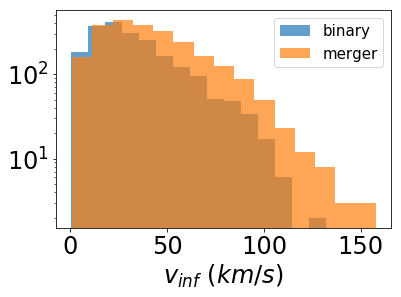

In [3]:
##plot the distribution of v_inf
vinf_init, vinf_finl, vinf_des = extract_key('vinf')

plt.figure()
plt.hist(vinf_init, bins = 15, alpha=0.7, label = 'binary')
plt.hist(vinf_des, bins = 15, alpha=0.7, label = 'merger')
plt.yscale('log')
plt.xlabel(r'$v_{inf}\ (km/s)$')
plt.legend(loc='best', fontsize=15)

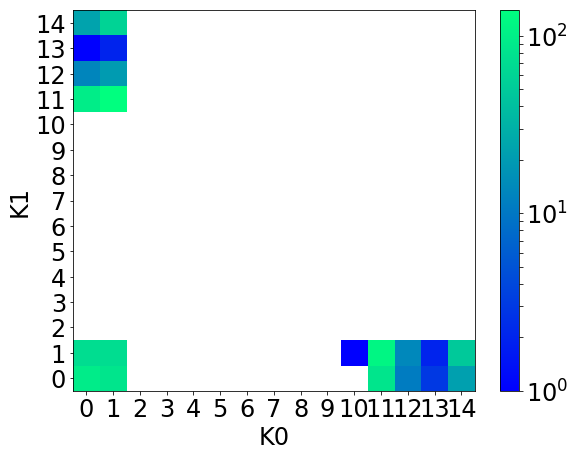

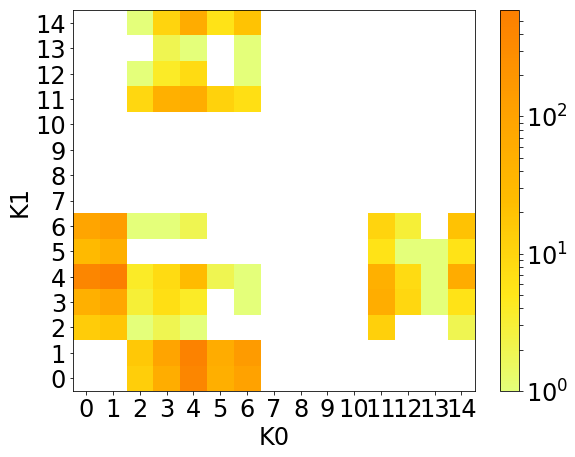

In [4]:
##plot the types of stars for tidal capture
tck0_init_index, tck0_finl_index, tck0_des_emp = extract_key_index('k0', index_tc_bin, 'bin')
tck1_init_index, tck1_finl_index, tck1_des_emp = extract_key_index('k1', index_tc_bin, 'bin')
tck0_init_emp, tck0_finl_emp, tck0_des_index = extract_key_index('k0', index_tc_des, 'des')
tck1_init_emp, tck1_finl_emp, tck1_des_index = extract_key_index('k1', index_tc_des, 'des')

tc_k0 = []; tc_k1 = []
for k in range(len(paths)):
    tc_k0.append(tck0_init_index[k] + tck0_des_index[k])
    tc_k1.append(tck1_init_index[k] + tck1_des_index[k])

#tc_k0 = np.take(prop_init['k0'], index_tc_bin)
#tc_k1 = np.take(prop_init['k1'], index_tc_bin)
#print(tc_k0, tc_k1)

K0 = []; K1 = []
for k in range(len(paths)):
    K0 = K0 + [x - 0.5 for x in tc_k0[k]]
    K1 = K1 + [Y - 0.5 for Y in tc_k1[k]]
    
plt.figure(figsize = (9, 7))
ax=plt.gca()
plt.hist2d(K0, K1, bins=np.arange(16)-0.5, norm=mpl.colors.LogNorm(), cmap='winter')
ax.xaxis.set_major_locator(plt.MaxNLocator(15))
ax.yaxis.set_major_locator(plt.MaxNLocator(15))    
plt.xlabel('K0')
plt.ylabel('K1')
plt.colorbar()


##plot the types of stars for giant-giant collisions
collk0_init_index, collk0_finl_index, collk0_des_emp = extract_key_index('k0', index_coll_bin, 'bin')
collk1_init_index, collk1_finl_index, collk1_des_emp = extract_key_index('k1', index_coll_bin, 'bin')
collk0_init_emp, collk0_finl_emp, collk0_des_index = extract_key_index('k0', index_coll_des, 'des')
collk1_init_emp, collk1_finl_emp, collk1_des_index = extract_key_index('k1', index_coll_des, 'des')

coll_k0 = []; coll_k1 = []
for k in range(len(paths)):
    coll_k0.append(collk0_init_index[k] + collk0_des_index[k])
    coll_k1.append(collk1_init_index[k] + collk1_des_index[k])

#coll_k0_bin = np.take(prop_init['k0'], index_coll_bin)
#coll_k1_bin = np.take(prop_init['k1'], index_coll_bin)
#coll_k0_des = np.take(prop_des['k0'], index_coll_des)
#coll_k1_des = np.take(prop_des['k1'], index_coll_des)
#print(coll_k0, coll_k1)

K0 = []; K1 = []
for k in range(len(paths)):
    K0 = K0 + [x - 0.5 for x in coll_k0[k]]
    K1 = K1 + [Y - 0.5 for Y in coll_k1[k]]
    
plt.figure(figsize = (9, 7))
ax=plt.gca()
plt.hist2d(K0, K1, bins=np.arange(16)-0.5, norm=mpl.colors.LogNorm(), cmap='Wistia')
ax.xaxis.set_major_locator(plt.MaxNLocator(15))
ax.yaxis.set_major_locator(plt.MaxNLocator(15))
plt.xlabel('K0')
plt.ylabel('K1')
plt.colorbar()

In [6]:
##Compare final and initial star types of tidal capture binaries
tck0_init_index, tck0_finl_index, tck0_des_emp = extract_key_index('k0', index_tc_bin, 'bin')
tck1_init_index, tck1_finl_index, tck1_des_emp = extract_key_index('k1', index_tc_bin, 'bin')

#tc_k0_init = np.take(prop_init['k0'], index_tc_bin)
#tc_k1_init = np.take(prop_init['k1'], index_tc_bin)
#tc_k0_finl = np.take(prop_finl['k0'], index_tc_bin)
#tc_k1_finl = np.take(prop_finl['k1'], index_tc_bin)


for i in range(len(paths)):
    k0_diff = [x - y for x, y in zip(tck0_finl_index[i], tck0_init_index[i])]
    k1_diff = [x - y for x, y in zip(tck1_finl_index[i], tck1_init_index[i])]
    #print(k0_diff, k1_diff)
    
    print(np.nonzero(k0_diff), np.nonzero(k1_diff))

    
##Check final giant-giant collisions star types
collk0_init_index, collk0_finl_index, collk0_des_emp = extract_key_index('k0', index_coll_bin, 'bin')
collk1_init_index, collk1_finl_index, collk1_des_emp = extract_key_index('k1', index_coll_bin, 'bin')
collid0_init_index, collid0_finl_index, collid0_des_emp = extract_key_index('id0', index_coll_bin, 'bin')
collid1_init_index, collid1_finl_index, collid1_des_emp = extract_key_index('id1', index_coll_bin, 'bin')

n_not7 = 0
for j in range(len(paths)):
    for i in range(len(collk0_init_index[j])):
        if 2<=collk0_init_index[j][i]<=9 and collk0_init_index[j][i]!=7:
            if collk0_finl_index[j][i]!=7: 
                print(collid0_init_index[j][i], collk0_init_index[j][i], collk0_finl_index[j][i])
                n_not7+=1
        if 2<=collk1_init_index[j][i]<=9 and collk1_init_index[j][i]!=7:
            if collk1_finl_index[j][i]!=7: 
                print(collid1_init_index[j][i], collk1_init_index[j][i], collk1_finl_index[j][i])
                n_not7+=1

print(n_not7)
##Does this look right?
##How exactly does stripping envelope work?

(array([], dtype=int64),) (array([], dtype=int64),)
789798 5 14
352674 5 14
31282 5 14
791314 5 13
3195194 5 8
604421 5 8
336768 5 8
329676 5 8
752030 5 8
591736 5 8
897130 5 8
3179672 5 8
3254772 5 8
3152850 5 8
3337959 5 8
3209424 5 8
508264 5 8
378993 5 8
1241638 5 8
516292 5 8
214829 5 8
372339 5 8
27853 5 8
80323 5 8
3366824 5 8
289969 5 8
747297 5 8
691872 5 8
634293 5 8
299540 5 8
571941 5 8
279154 5 8
39467 5 8
531758 5 8
3248794 5 8
487879 5 8
861252 5 8
180360 5 8
462997 5 8
60714 5 8
682828 5 8
488193 5 8
97343 5 8
473852 5 8
581562 5 8
444809 5 8
268317 5 8
346638 5 8
102225 5 8
159084 5 8
355718 5 8
3098944 5 8
582731 5 8
392597 5 8
485307 5 8
588816 5 8
3527418 5 8
72316 5 8
708980 5 8
456050 5 8
103280 5 8
527698 5 8
380111 5 8
3246096 5 8
94838 5 8
530017 5 8
541645 5 8
312426 5 8
573795 6 13
573609 5 8
3126568 6 13
94442 5 8
248083 6 13
3378378 5 8
59933 6 13
3122469 6 13
447294 6 13
121796 6 13
3404839 6 13
297499 6 12
744557 6 13
535073 6 12
458392 6 12
592445 6 12
2

Text(0,0.5,'$a/r_{peri}$')

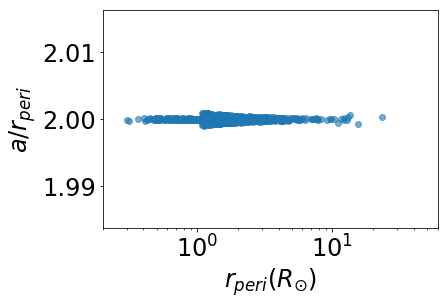

In [5]:
##check rperi and final sma of tidal capture binaries
tcrperi_init_index, tcrperi_finl_emp, tcrperi_des_emp = extract_key_index('rperi', index_tc_bin, 'bin')
tcsma_init_emp, tcsma_finl_index, tcsma_des_emp = extract_key_index('sma', index_tc_bin, 'bin')
tcecc_init_emp, tcecc_finl_index, tcecc_des_emp = extract_key_index('ecc', index_tc_bin, 'bin')

tc_sma = tcsma_finl_index
tc_rperi = tcrperi_init_index
#tc_rperi = np.take(prop_init['rperi'], index_tc_bin)
#tc_sma = np.take(prop_finl['sma'], index_tc_bin)
#tc_ecc = np.take(prop_finl['ecc'], index_tc_bin)

plt.figure()
for i in range(len(paths)):
    ratio = np.array(tc_sma[i])*AU_Rsun/np.array(tc_rperi[i])
    plt.scatter(tc_rperi[i], ratio, alpha=0.6)
    
#plt.scatter(tc_rperi, tc_ecc)
plt.xlim(0.2, 60)
plt.xscale('log')
plt.xlabel(r'$r_{peri}(R_{\odot})$')
plt.ylabel(r'$a/r_{peri}$')

unstable
unstable
unstable
unstable
unstable
unstable
unstable
unstable
4 4


/software/anaconda3.6/lib/python3.6/site-packages/ipykernel/__main__.py:143: RuntimeWarning: divide by zero encountered in true_divide
/software/anaconda3.6/lib/python3.6/site-packages/ipykernel/__main__.py:144: RuntimeWarning: divide by zero encountered in true_divide


Text(0,0.5,'$E_{orb}(M_\\odot \\cdot km/s^2)$')

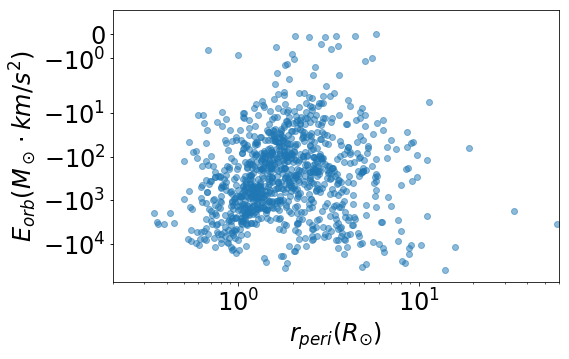

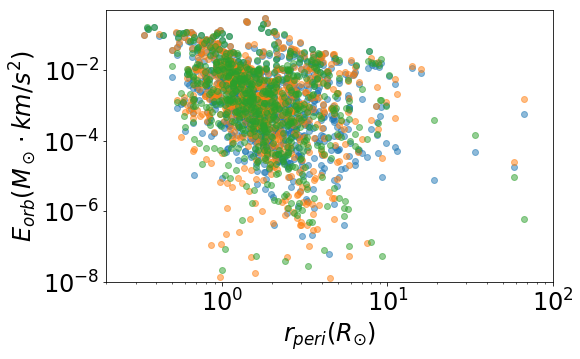

In [14]:
##check energy of tidal capture binaries
##Data from the fitting formulae
def Tl(order, polytropicindex, eta):
    l=order; n=polytropicindex; x=np.log10(eta); x2=x*x; x3=x*x2; x4=x2*x2; x5=x2*x3

    if l != 2 and l != 3:
        print("unknown order")
    
    ##From Portegies Zwart & Meinen 1993
    if n == 1.5:
        if l == 2: 
            return pow(10.0, -0.397 + 1.678*x + 1.277*x2 - 12.42*x3 + 9.446*x4 - 5.550*x5)
        else:
            return pow(10.0, -0.909 + 1.574*x + 12.37*x2 - 57.40*x3 + 80.10*x4 - 46.43*x5)
                
    elif n == 2.0:
        if l == 2:
            return pow(10.0, -0.517 - 0.906*x + 23.88*x2 - 93.49*x3 + 112.3*x4 - 44.15*x5)
        else:
            return pow(10.0, -1.040 - 1.354*x + 37.64*x2 - 139.9*x3 + 168.2*x4 - 66.53*x5)
                
    elif n == 3.0:
        if l == 2:
            return pow(10.0, -1.124 + 0.877*x - 13.37*x2 + 21.55*x3 - 16.48*x4 + 4.124*x5)
        else:
            return pow(10.0, -1.703 + 2.653*x - 14.34*x2 + 12.85*x3 - 0.492*x4 - 3.600*x5)
                
    else:
        printf("unknown polytropic index")
             
        

def E_oscillate(rperi, Mosc, Rosc, nosc, Mpert):
    eta=math.sqrt(Mosc/(Mosc+Mpert))*pow(rperi/Rosc, 1.5)
    #rperi = Rosc*pow((Mosc+Mpert)/Mosc,1/3)*pow(eta, 2/3)

    return Gconst_sun*PC_Rsun*Mpert**2/Rosc * (pow(Rosc/rperi, 6.0) * Tl(2, nosc, eta) + pow(Rosc/rperi, 8.0) * Tl(3, nosc, eta))
  
def E_star_binding(m0, r0, m1, r1, k0, k1):
    Eb0 = 0; Eb1 = 0
    if k0 < 2:
        Eb0 = Gconst_sun*m0*m0/(r0/PC_Rsun)
    if k1 < 2:
        Eb1 = Gconst_sun*m1*m1/(r1/PC_Rsun)
        
    return Eb0, Eb1
    
tcrperi_init_index, tcrperi_finl_emp, tcrperi_des_emp = extract_key_index('rperi', index_tc_bin, 'bin')
tcvinf_init_index, tcvinf_finl_emp, tcvinf_des_emp = extract_key_index('vinf', index_tc_bin, 'bin')
tcm0_init_index, tcm0_finl_index, tcm0_des_emp = extract_key_index('m0', index_tc_bin, 'bin')
tcm1_init_index, tcm1_finl_index, tcm1_des_emp = extract_key_index('m1', index_tc_bin, 'bin')
tcr0_init_index, tcr0_finl_index, tcr0_des_emp = extract_key_index('r0', index_tc_bin, 'bin')
tcr1_init_index, tcr1_finl_index, tcr1_des_emp = extract_key_index('r1', index_tc_bin, 'bin')
tck0_init_index, tck0_finl_index, tck0_des_emp = extract_key_index('k0', index_tc_bin, 'bin')
tck1_init_index, tck1_finl_index, tck1_des_emp = extract_key_index('k1', index_tc_bin, 'bin')

tc_m0 = tcm0_init_index; tc_r0 = tcr0_init_index; tc_k0 = tck0_init_index
tc_m1 = tcm1_init_index; tc_r1 = tcr1_init_index; tc_k1 = tck1_init_index
tc_rperi = tcrperi_init_index; tc_vinf = tcvinf_init_index
#tc_m0 = np.take(prop_init['m0'], index_tc_bin)
#tc_m1 = np.take(prop_init['m1'], index_tc_bin)
#tc_r0 = np.take(prop_init['r0'], index_tc_bin)
#tc_r1 = np.take(prop_init['r1'], index_tc_bin)
#tc_k0 = np.take(prop_init['k0'], index_tc_bin)
#tc_k1 = np.take(prop_init['k1'], index_tc_bin)
#tc_rperi = np.take(prop_init['rperi'], index_tc_bin)
#tc_vinf = np.take(prop_init['vinf'], index_tc_bin)

E_osc = []
E0_binding = []; E1_binding = []
E_binding = []
E0osc = []; E1osc = []
for jj in range(len(paths)):
    E_osc.append([])
    E0osc.append([]); E1osc.append([])
    E0_binding.append([]); E1_binding.append([])
    E_binding.append([])
    for i in range(len(tc_m0[jj])):
        m_reduce = tc_m0[jj][i]*tc_m1[jj][i]/(tc_m0[jj][i]+tc_m1[jj][i])
        E_kin = 0.5*m_reduce*tc_vinf[jj][i]**2
        
        if tc_k0[jj][i]==1: n0 = 3.0
        elif tc_k0[jj][i]==0 or tc_k0[jj][i]==7: n0 = 1.5
        else: n0 = -100
        
        if tc_k1[jj][i]==1: n1 = 3.0
        elif tc_k1[jj][i]==0 or tc_k1[jj][i]==7: n1 = 1.5
        else: n1 = -100
    
        if n0!=-100 and n1!=-100:
            E0_osc = E_oscillate(tc_rperi[jj][i], tc_m0[jj][i], tc_r0[jj][i], n0, tc_m1[jj][i])
            E1_osc = E_oscillate(tc_rperi[jj][i], tc_m1[jj][i], tc_r1[jj][i], n1, tc_m0[jj][i])
            E0osc[jj].append(E0_osc); E1osc[jj].append(E1_osc)
            
            E_osc[jj].append(E_kin - E0_osc - E1_osc)
            
        elif n1==-100:
            E0_osc = E_oscillate(tc_rperi[jj][i], tc_m0[jj][i], tc_r0[jj][i], n0, tc_m1[jj][i])
            E0osc[jj].append(E0_osc); E1osc[jj].append(-100)
            E_osc[jj].append(E_kin - E0_osc)
        
        elif n0==-100:
            E1_osc = E_oscillate(tc_rperi[jj][i], tc_m1[jj][i], tc_r1[jj][i], n1, tc_m0[jj][i])
            E0osc[jj].append(-100); E1osc[jj].append(E1_osc)
            E_osc[jj].append(E_kin - E1_osc)
        else:
            print('Oops, something is wrong')
            
        Eb_0, Eb_1 = E_star_binding(tc_m0[jj][i], tc_r0[jj][i], tc_m1[jj][i], tc_r1[jj][i], tc_k0[jj][i], tc_k1[jj][i])
        E0_binding[jj].append(Eb_0); E1_binding[jj].append(Eb_1)
        E_binding[jj].append(Eb_0+Eb_1)
        
    n0_unstable = 0; n1_unstable = 0
    for xx in range(len(E0_binding[jj])):
        mtot = tc_m0[jj][xx]+tc_m1[jj][xx]
        if E0_binding[jj][xx]!=0:
            if 0.15*E0_binding[jj][xx]<E0osc[jj][xx]: and (tc_rperi[jj][xx]/tc_r0[jj][xx])<1.3*(mtot/2./tc_m0[jj][xx])**(1./3.):
                print('unstable')
                n0_unstable+=1
        
        if E1_binding[jj][xx]!=0:
            if 0.15*E1_binding[jj][xx]<E1osc[jj][xx]: and (tc_rperi[jj][xx]/tc_r1[jj][xx])<1.3*(mtot/2./tc_m1[jj][xx])**(1./3.):
                print('unstable')
                n1_unstable+=1
                
    print(n0_unstable, n1_unstable)
        
    

plt.figure(figsize = (8, 5))
for jj in range(len(paths)):
    plt.scatter(tc_rperi[jj], E_osc[jj], alpha=0.5)
plt.yscale('symlog')
plt.xscale('log')
plt.xlim(0.2, 60)
plt.ylim(ymax=1)
plt.xlabel(r'$r_{peri}(R_{\odot})$')
plt.ylabel(r'$E_{orb}(M_\odot \cdot km/s^2)$')

plt.figure(figsize = (8, 5))
for jj in range(len(paths)):
    plt.scatter(tc_rperi[jj], np.absolute(np.array(E_osc[jj]))/np.array(E_binding[jj]), alpha=0.5)
    plt.scatter(tc_rperi[jj], np.absolute(np.array(E0osc[jj]))/np.array(E0_binding[jj]), alpha=0.5)
    plt.scatter(tc_rperi[jj], np.absolute(np.array(E1osc[jj]))/np.array(E1_binding[jj]), alpha=0.5)

plt.axhline(y=1)
plt.yscale('log')
plt.xscale('log')
plt.xlim(0.2, 100)
plt.ylim(ymax = 0.5)
plt.ylim(ymin = 1e-8)
plt.xlabel(r'$r_{peri}(R_{\odot})$')
plt.ylabel(r'$E_{orb}(M_\odot \cdot km/s^2)$')

(0.2, 60)

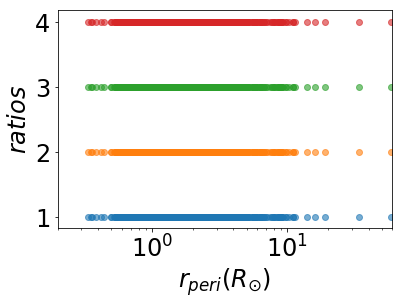

In [11]:
##Compare initial and final masses and radii of tidal capture binaries
tcm0_init_index, tcm0_finl_index, tcm0_des_emp = extract_key_index('m0', index_tc_bin, 'bin')
tcm1_init_index, tcm1_finl_index, tcm1_des_emp = extract_key_index('m1', index_tc_bin, 'bin')
tcr0_init_index, tcr0_finl_index, tcr0_des_emp = extract_key_index('r0', index_tc_bin, 'bin')
tcr1_init_index, tcr1_finl_index, tcr1_des_emp = extract_key_index('r1', index_tc_bin, 'bin')
tcrperi_init_index, tcrperi_finl_emp, tcrperi_des_emp = extract_key_index('rperi', index_tc_bin, 'bin')

tc_m0_init = tcm0_init_index; tc_r0_init = tcr0_init_index
tc_m1_init = tcm1_init_index; tc_r1_init = tcr1_init_index
tc_m0_finl = tcm0_finl_index; tc_r0_finl = tcr0_finl_index
tc_m1_finl = tcm1_finl_index; tc_r1_finl = tcr1_finl_index
tc_rperi = tcrperi_init_index

#tc_m0_init = np.take(prop_init['m0'], index_tc_bin)
#tc_m1_init = np.take(prop_init['m1'], index_tc_bin)
#tc_r0_init = np.take(prop_init['r0'], index_tc_bin)
#tc_r1_init = np.take(prop_init['r1'], index_tc_bin)
#
#tc_m0_finl = np.take(prop_finl['m0'], index_tc_bin)
#tc_m1_finl = np.take(prop_finl['m1'], index_tc_bin)
#tc_r0_finl = np.take(prop_finl['r0'], index_tc_bin)
#tc_r1_finl = np.take(prop_finl['r1'], index_tc_bin)
#
#tc_rperi = np.take(prop_init['rperi'], index_tc_bin)

plt.figure()
for jj in range(len(paths)):
    ratio_m0 = np.array(tc_m0_finl[jj])/np.array(tc_m0_init[jj])
    ratio_m1 = np.array(tc_m1_finl[jj])/np.array(tc_m1_init[jj])
    ratio_r0 = np.array(tc_r0_finl[jj])/np.array(tc_r0_init[jj])
    ratio_r1 = np.array(tc_r1_finl[jj])/np.array(tc_r1_init[jj])

    plt.scatter(tc_rperi[jj], ratio_m0, alpha = 0.6)
    plt.scatter(tc_rperi[jj], ratio_m1+1, alpha = 0.6)
    plt.scatter(tc_rperi[jj], ratio_r0+2, alpha = 0.6)
    plt.scatter(tc_rperi[jj], ratio_r1+3, alpha = 0.6)
    
plt.xlabel(r'$r_{peri}(R_{\odot})$')
plt.ylabel(r'$ratios$')
plt.xscale('log')
plt.xlim(0.2, 60)

In [3]:
##Check if the tidal capture binaries are mass transferring
def rochradius(m0, m1, sma):  ##sma is in AU, rl is in Rsun
    q = m0/m1   
    p = pow(q, 1.0/3.0)
    rl = 0.49*p*p/(0.6*p*p+math.log(1.0+p))*sma*AU_Rsun
    return rl
    

tcid0_init_index, tcid0_finl_index, tcid0_des_emp = extract_key_index('id0', index_tc_bin, 'bin')
tcid1_init_index, tcid1_finl_index, tcid1_des_emp = extract_key_index('id1', index_tc_bin, 'bin')
tck0_init_index, tck0_finl_index, tck0_des_emp = extract_key_index('k0', index_tc_bin, 'bin')
tck1_init_index, tck1_finl_index, tck1_des_emp = extract_key_index('k1', index_tc_bin, 'bin')

tc_id0 = tcid0_finl_index; tc_k0 = tck0_finl_index
tc_id1 = tcid1_finl_index; tc_k1 = tck1_finl_index


tcm0_init_index, tcm0_finl_index, tcm0_des_emp = extract_key_index('m0', index_tc_bin, 'bin')
tcm1_init_index, tcm1_finl_index, tcm1_des_emp = extract_key_index('m1', index_tc_bin, 'bin')
tcr0_init_index, tcr0_finl_index, tcr0_des_emp = extract_key_index('r0', index_tc_bin, 'bin')
tcr1_init_index, tcr1_finl_index, tcr1_des_emp = extract_key_index('r1', index_tc_bin, 'bin')
tcsma_init_emp, tcsma_finl_index, tcsma_des_emp = extract_key_index('sma', index_tc_bin, 'bin')

tc_m0 = tcm0_finl_index; tc_r0 = tcr0_finl_index
tc_m1 = tcm1_finl_index; tc_r1 = tcr1_finl_index
tc_sma = tcsma_finl_index

#tc_m0 = np.take(prop_finl['m0'], index_tc_bin)
#tc_m1 = np.take(prop_finl['m1'], index_tc_bin)
#tc_r0 = np.take(prop_finl['r0'], index_tc_bin)
#tc_r1 = np.take(prop_finl['r1'], index_tc_bin)
#tc_sma = np.take(prop_finl['sma'], index_tc_bin)


n_mt = 0
for jj in range(len(paths)):
    for i in range(len(tc_m0[jj])):
        rl0 = rochradius(tc_m0[jj][i], tc_m1[jj][i], tc_sma[jj][i])
        rl1 = rochradius(tc_m1[jj][i], tc_m0[jj][i], tc_sma[jj][i])
        if rl0<=tc_r0[jj][i] or rl1<=tc_r1[jj][i]:
            n_mt+=1
            print(jj, tc_id0[jj][i], tc_id1[jj][i], tc_k0[jj][i], tc_k1[jj][i], tc_m0[jj][i], tc_m1[jj][i], tc_sma[jj][i])
            #print('Oops, something is wrong')
print(n_mt)

0 721956 158620 14 1 25.2 1.43 0.02583
0 317989 394698 1 14 1.62 24.6 0.02692
0 206307 1176405 0 14 0.1 21.9 0.008066
0 340485 521134 14 1 13.6 0.938 0.0198
0 412186 87819 11 1 0.947 0.798 0.006978
0 196800 1127886 0 12 0.214 1.12 0.002921
0 678575 312666 11 0 0.902 0.269 0.00369
0 401437 816640 1 12 1.5 1.11 0.01955
0 138606 35554 11 1 0.957 0.892 0.009665
0 306211 344843 1 11 0.723 0.737 0.006568
0 498 139925 1 11 0.881 0.859 0.008713
0 710899 792038 11 1 0.642 1.16 0.01495
0 328505 423944 1 12 0.806 1.17 0.008535
0 383309 317760 11 1 0.957 0.711 0.007126
0 277387 507534 11 1 0.654 1.02 0.01127
0 180256 599354 1 11 1.08 0.87 0.01648
0 5641 434799 12 0 1.22 0.542 0.005171
0 516498 426599 0 12 0.126 1.25 0.002356
0 525521 163604 11 1 0.647 0.748 0.008494
0 19193 399083 11 0 1.03 0.341 0.003661
0 816365 659988 11 1 0.933 0.733 0.00673
0 641678 428413 1 11 0.962 0.957 0.01304
0 686827 277224 11 1 0.638 0.819 0.008839
0 263104 439333 12 1 1.2 0.93 0.01561
0 86670 131471 1 11 0.843 1.07 0.

0 1 0.201 19.0
0 1 0.244 11.2
0 1 0.363 7.07
0 1 0.243 5.59
0 1 0.0884 5.69
0 1 0.114 1.7
0 1 0.0817 2.36
0 1 0.156 1.79
0 0 0.107 0.647
0 1 0.143 0.906
0 1 0.119 0.797
0 1 0.214 1.11
0 0 0.114 0.594
1 1 0.71 0.943
0 0 0.188 0.583
618 618
15 0.024271844660194174
0 1 0.0843 8.08
0 1 0.475 34.6
0 1 0.134 8.52
0 1 0.123 1.26
0 1 0.178 2.39
0 1 0.0809 2.76
0 1 0.287 1.35
0 0 0.143 0.435
0 1 0.142 0.993
0 1 0.165 1.05
0 0 0.31 0.648
0 0 0.0887 0.652
424 424
12 0.02830188679245283
0 1 0.126 4.15
0 1 0.549 7.97
0 1 0.155 6.27
0 1 0.172 4.16
0 1 0.202 2.62
0 0 0.12 0.501
0 1 0.0982 3.03
0 0 0.099 0.61
0 1 0.122 1.34
0 0 0.132 0.385
0 0 0.209 0.57
0 1 0.429 1.05
0 1 0.285 0.83
11 1 0.557 0.727
279 279
14 0.05017921146953405
1 1 2.93 38.0
0 1 0.272 2.23
0 1 0.127 1.15
0 0 0.15 0.509
0 1 0.136 0.914
0 1 0.114 0.73
0 0 0.148 0.4
0 0 0.17 0.661
0 1 0.235 0.885
0 0 0.237 0.572
177 177
10 0.05649717514124294
0 1 0.185 2.75
0 0 0.105 0.396
0 0 0.139 0.522
75 75
3 0.04


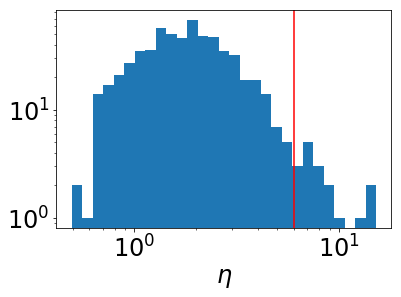

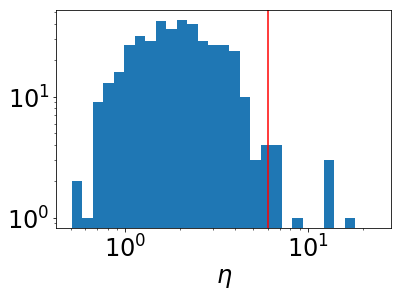

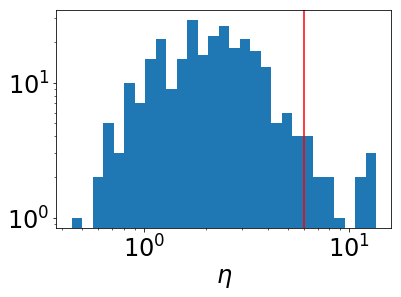

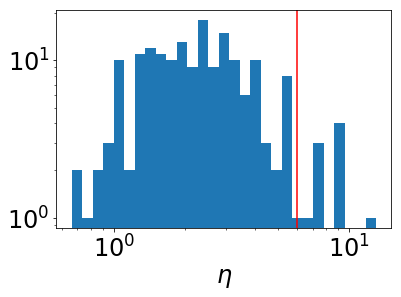

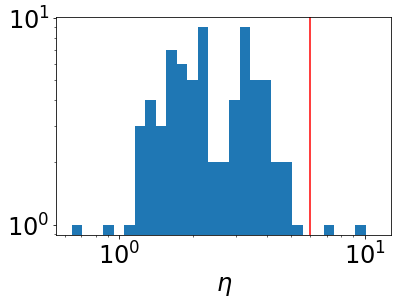

In [3]:
##Check eta for tidal capture process
def Eta(Mosc, Rosc, Mpert, rperi):
     return math.sqrt(Mosc/(Mosc+Mpert))*pow(rperi/Rosc, 1.5)
    
tcm0_init_index, tcm0_finl_index, tcm0_des_emp = extract_key_index('m0', index_tc_bin, 'bin')
tcm1_init_index, tcm1_finl_index, tcm1_des_emp = extract_key_index('m1', index_tc_bin, 'bin')
tcr0_init_index, tcr0_finl_index, tcr0_des_emp = extract_key_index('r0', index_tc_bin, 'bin')
tcr1_init_index, tcr1_finl_index, tcr1_des_emp = extract_key_index('r1', index_tc_bin, 'bin')
tck0_init_index, tck0_finl_index, tck0_des_emp = extract_key_index('k0', index_tc_bin, 'bin')
tck1_init_index, tck1_finl_index, tck1_des_emp = extract_key_index('k1', index_tc_bin, 'bin')
tcrperi_init_index, tcrperi_finl_emp, tcrperi_des_emp = extract_key_index('rperi', index_tc_bin, 'bin')
  
tc_m0 = tcm0_init_index; tc_r0 = tcr0_init_index; tc_k0 = tck0_init_index
tc_m1 = tcm1_init_index; tc_r1 = tcr1_init_index; tc_k1 = tck1_init_index
tc_rperi = tcrperi_init_index
#tc_m0 = np.take(prop_init['m0'], index_tc_bin)
#tc_m1 = np.take(prop_init['m1'], index_tc_bin)
#tc_r0 = np.take(prop_init['r0'], index_tc_bin)
#tc_r1 = np.take(prop_init['r1'], index_tc_bin)
#tc_k0 = np.take(prop_init['k0'], index_tc_bin)
#tc_k1 = np.take(prop_init['k1'], index_tc_bin)
#tc_rperi = np.take(prop_init['rperi'], index_tc_bin)

all_eta = []
n_eta = []
for jj in range(len(paths)):
    all_eta.append([])
    n_eta.append(0)
    for i in range(len(tc_k0[jj])):
        if tc_k0[jj][i]<=1 or tc_k0[jj][i]==7:
            all_eta[jj].append(Eta(tc_m0[jj][i], tc_r0[jj][i], tc_m1[jj][i], tc_rperi[jj][i]))
            if Eta(tc_m0[jj][i], tc_r0[jj][i], tc_m1[jj][i], tc_rperi[jj][i])>6:
                n_eta[jj]+=1
                print(tc_k0[jj][i], tc_k1[jj][i], tc_m0[jj][i], tc_m1[jj][i])
                
        elif tc_k1[jj][i]<=1 or tc_k1[jj][i]==7:
            all_eta[jj].append(Eta(tc_m1[jj][i], tc_r1[jj][i], tc_m0[jj][i], tc_rperi[jj][i]))
            if Eta(tc_m1[jj][i], tc_r1[jj][i], tc_m0[jj][i], tc_rperi[jj][i])>6:
                n_eta[jj]+=1
                print(tc_k0[jj][i], tc_k1[jj][i], tc_m0[jj][i], tc_m1[jj][i])

    print(len(all_eta[jj]), len(tc_k0[jj]))
    print(n_eta[jj], n_eta[jj]/len(tc_k0[jj]))

    plt.figure()
    plt.axvline(x=6, color='red')
    plt.hist(all_eta[jj], bins=np.logspace(np.log10(min(all_eta[jj])), np.log10(max(all_eta[jj])), 30))
    plt.yscale('log')
    plt.xscale('log')
    plt.xlabel(r'$\eta$')

Text(0,0.5,'$ratios$')

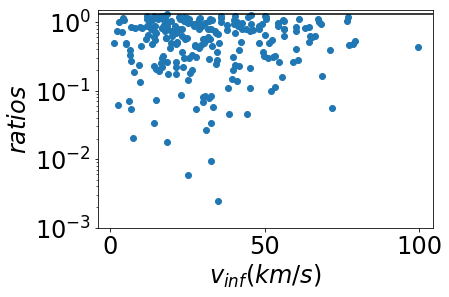

In [6]:
##Check the pericenter distance of all giant collision
collr0_init_index, collr0_finl_index, collr0_des_emp = extract_key_index('r0', index_coll_bin, 'bin')
collr1_init_index, collr1_finl_index, collr1_des_emp = extract_key_index('r1', index_coll_bin, 'bin')
collrperi_init_index, collrperi_finl_emp, collrperi_des_emp = extract_key_index('rperi', index_coll_bin, 'bin')
collvinf_init_index, collvinf_finl_emp, collvinf_des_emp = extract_key_index('vinf', index_coll_bin, 'bin')

collr0_init_emp, collr0_finl_emp, collr0_des_index = extract_key_index('r0', index_coll_des, 'des')
collr1_init_emp, collr1_finl_emp, collr1_des_index = extract_key_index('r1', index_coll_des, 'des')
collrperi_init_emp, collrperi_finl_emp, collrperi_des_index = extract_key_index('rperi', index_coll_des, 'des')
collvinf_init_emp, collvinf_finl_emp, collvinf_des_index = extract_key_index('vinf', index_coll_des, 'des')

#coll_r0_bin = np.take(prop_init['r0'], index_coll_bin)
#coll_r1_bin = np.take(prop_init['r1'], index_coll_bin)
#coll_rperi_bin = np.take(prop_init['rperi'], index_coll_bin)
#coll_vinf_bin = np.take(prop_init['vinf'], index_coll_bin)
#
#coll_r0_des = np.take(prop_des['r0'], index_coll_des)
#coll_r1_des = np.take(prop_des['r1'], index_coll_des)
#coll_rperi_des = np.take(prop_des['rperi'], index_coll_des)
#coll_vinf_des = np.take(prop_des['vinf'], index_coll_des)

#coll_r0 = np.concatenate((coll_r0_bin, coll_r0_des))
#coll_r1 = np.concatenate((coll_r1_bin, coll_r1_des))
#coll_rperi = np.concatenate((coll_rperi_bin, coll_rperi_des))
#coll_vinf = np.concatenate((coll_vinf_bin, coll_vinf_des))


plt.figure()
for jj in range(len(paths)):
    coll_rperi = np.array(collrperi_init_index[jj] + collrperi_des_index[jj])
    coll_r0 = np.array(collr0_init_index[jj] + collr0_des_index[jj])
    coll_r1 = np.array(collr1_init_index[jj] + collr1_des_index[jj])
    coll_vinf = np.array(collvinf_init_index[jj] + collvinf_des_index[jj])
    
    ratio = coll_rperi/(coll_r0+coll_r1)

    for i in range(len(ratio)):
        if ratio[i]>1.3:
            print(coll_r0[i], coll_r1[i])

    plt.scatter(coll_vinf, ratio)
    
plt.axhline(y=1.3, color = 'k')
plt.ylim(ymin = 0.001, ymax = 1.5)
plt.yscale('log')
plt.xlabel(r'$v_{inf}(km/s)$')
plt.ylabel(r'$ratios$')

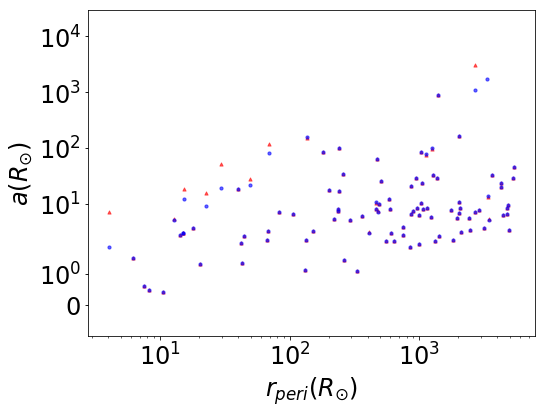

In [7]:
##Check the CE outcomes of giant-giant collisions and RLOF

def coll_CE(Mrg, Mint, Mwd, Rrg, vinf):
    alpha1 = 1.0
    lambdaf = 0.5

    ##a_f in unit of solar radius
    return(1.0/(2.0*Mrg*(Mrg-Mwd)/(Mwd*Mint*alpha1*lambdaf*Rrg)-(Mrg+Mint)/(Gconst_sun*PC_Rsun*Mwd*Mint*alpha1)*vinf*vinf))


def coll_CE_twogiants(M1, M2, Mc1, Mc2, R1, R2, vinf):
    alpha1 = 1.0
    lambdaf = 0.5

    E_bindi = Gconst_sun*PC_Rsun/lambdaf*(M1*(M1-Mc1)/R1+M2*(M2-Mc2)/R2)
    E_orbi = 0.5*(M1+M2)*vinf*vinf

    af = Gconst_sun*PC_Rsun*Mc1*Mc2*alpha1/(2*(E_bindi-E_orbi))

    return af

def rochradius(m0, m1, sma):  ##sma is in AU, rl is in Rsun
    q = m0/m1   
    p = pow(q, 1.0/3.0)
    rl = 0.49*p*p/(0.6*p*p+math.log(1.0+p))*sma*AU_Rsun
    return rl


collm0_init_index, collm0_finl_index, collm0_des_emp = extract_key_index('m0', index_coll_bin, 'bin')
collm1_init_index, collm1_finl_index, collm1_des_emp = extract_key_index('m1', index_coll_bin, 'bin')
collmc0_init_index, collmc0_finl_emp, collmc0_des_emp = extract_key_index('mc0', index_coll_bin, 'bin')
collmc1_init_index, collmc1_finl_emp, collmc1_des_emp = extract_key_index('mc1', index_coll_bin, 'bin')

collk0_init_index, collk0_finl_index, collk0_des_emp = extract_key_index('k0', index_coll_bin, 'bin')
collk1_init_index, collk1_finl_index, collk1_des_emp = extract_key_index('k1', index_coll_bin, 'bin')

collr0_init_index, collr0_finl_index, collr0_des_emp = extract_key_index('r0', index_coll_bin, 'bin')
collr1_init_index, collr1_finl_index, collr1_des_emp = extract_key_index('r1', index_coll_bin, 'bin')
collrc0_init_index, collrc0_finl_emp, collrc0_des_emp = extract_key_index('rc0', index_coll_bin, 'bin')
collrc1_init_index, collrc1_finl_emp, collrc1_des_emp = extract_key_index('rc1', index_coll_bin, 'bin')

collrperi_init_index, collrperi_finl_emp, collrperi_des_emp = extract_key_index('rperi', index_coll_bin, 'bin')
collvinf_init_index, collvinf_finl_emp, collvinf_des_emp = extract_key_index('vinf', index_coll_bin, 'bin')
collsma_init_emp, collsma_finl_index, collsma_des_emp = extract_key_index('sma', index_coll_bin, 'bin')

#coll_m0_init = np.take(prop_init['m0'], index_coll_bin)
#coll_m1_init = np.take(prop_init['m1'], index_coll_bin)
#coll_r0_init = np.take(prop_init['r0'], index_coll_bin)
#coll_r1_init = np.take(prop_init['r1'], index_coll_bin)
#coll_k0_init = np.take(prop_init['k0'], index_coll_bin)
#coll_k1_init = np.take(prop_init['k1'], index_coll_bin)

#coll_m0_finl = np.take(prop_finl['m0'], index_coll_bin)
#coll_m1_finl = np.take(prop_finl['m1'], index_coll_bin)
#coll_r0_finl = np.take(prop_finl['r0'], index_coll_bin)
#coll_r1_finl = np.take(prop_finl['r1'], index_coll_bin)

#coll_vinf = np.take(prop_init['vinf'], index_coll_bin)
#coll_sma = np.take(prop_finl['sma'], index_coll_bin)*AU_Rsun
#coll_rperi = np.take(prop_init['rperi'], index_coll_bin)

coll_k0_init = collk0_init_index; coll_m0_init = collm0_init_index; coll_r0_init = collr0_init_index
coll_k1_init = collk1_init_index; coll_m1_init = collm1_init_index; coll_r1_init = collr1_init_index

coll_mc0_init = collmc0_init_index; coll_rc0_init = collrc0_init_index
coll_mc1_init = collmc1_init_index; coll_rc1_init = collrc1_init_index

coll_k0_finl = collk0_finl_index; coll_m0_finl = collm0_finl_index; coll_r0_finl = collr0_finl_index
coll_k1_finl = collk1_finl_index; coll_m1_finl = collm1_finl_index; coll_r1_finl = collr1_finl_index
coll_vinf = collvinf_init_index; coll_rperi = collrperi_init_index
coll_sma = collsma_finl_index


plt.figure(figsize=(8, 6))
for jj in range(len(paths)):
    ce_af = []
    for i in range(len(coll_k0_init[jj])):
        if (2<=coll_k0_init[jj][i]<=9 and coll_k0_init[jj][i]!=7) and (2<=coll_k1_init[jj][i]<=9 and coll_k1_init[jj][i]!=7):
            af_temp = coll_CE_twogiants(coll_m0_init[jj][i], coll_m1_init[jj][i], coll_mc0_init[jj][i], coll_mc1_init[jj][i],
                                       coll_r0_init[jj][i], coll_r1_init[jj][i], coll_vinf[jj][i])
            ce_af.append(af_temp)
        elif 2<=coll_k0_init[jj][i]<=9 and coll_k0_init[jj][i]!=7:
            af_temp = coll_CE(coll_m0_init[jj][i], coll_m1_init[jj][i], coll_mc0_init[jj][i], coll_r0_init[jj][i], coll_vinf[jj][i])
            ce_af.append(af_temp)
        elif 2<=coll_k1_init[jj][i]<=9 and coll_k1_init[jj][i]!=7:
            af_temp = coll_CE(coll_m1_init[jj][i], coll_m0_init[jj][i], coll_mc1_init[jj][i], coll_r1_init[jj][i], coll_vinf[jj][i])
            ce_af.append(af_temp)
        
    plt.scatter(coll_rperi[jj], ce_af, s = 10, color = 'red', marker = '^', alpha=0.6)
    plt.scatter(coll_rperi[jj], np.array(coll_sma[jj])*AU_Rsun, s = 10, color = 'blue', alpha=0.6)
    
plt.yscale('symlog')
plt.xscale('log')
plt.ylim(-1, 30000)
plt.xlabel(r'$r_{peri}(R_{\odot})$')
plt.ylabel(r'$a(R_{\odot})$')
#plt.legend(loc='best', fontsize=12)

#ratio = coll_sma/(coll_r0_finl+coll_r1_finl)
#plt.figure()
#plt.scatter(coll_rperi, ratio)
#plt.yscale('log')
#plt.xscale('log')
#print(np.min(coll_sma)*AU_Rsun, np.min(ratio))

for kk in range(len(paths)):
    for i in range(len(coll_m0_init[kk])):
        if (2<=coll_k0_init[kk][i]<=9 and coll_k0_init[kk][i]!=7) and (2<=coll_k1_init[kk][i]<=9 and coll_k1_init[kk][i]!=7):
            rl0 = rochradius(coll_mc0_init[kk][i], coll_mc1_init[kk][i], coll_sma[kk][i])
            rl1 = rochradius(coll_mc1_init[kk][i], coll_mc0_init[kk][i], coll_sma[kk][i])
            
            if rl0<=coll_rc0_init[kk][i] or rl1<=coll_rc1_init[kk][i]:
                print('Oops, something is wrong')
                print(coll_k0_init[kk][i], coll_k1_init[kk][i], coll_m0_init[kk][i], coll_m1_init[kk][i])
                print(coll_k0_finl[kk][i], coll_k1_finl[kk][i], coll_m0_finl[kk][i], coll_m1_finl[kk][i])
                print(rl0, rl1, coll_r0_finl[kk][i], coll_r1_finl[kk][i])
                
        elif 2<=coll_k0_init[kk][i]<=9 and coll_k0_init[kk][i]!=7:
            rl0 = rochradius(coll_mc0_init[kk][i], coll_m1_init[kk][i], coll_sma[kk][i])
            rl1 = rochradius(coll_m1_init[kk][i], coll_mc0_init[kk][i], coll_sma[kk][i])
            
            if rl0<=coll_rc0_init[kk][i] or rl1<=coll_r1_init[kk][i]:
                print('Oops, something is wrong')
                print(coll_k0_init[kk][i], coll_k1_init[kk][i], coll_m0_init[kk][i], coll_m1_init[kk][i])
                print(coll_k0_finl[kk][i], coll_k1_finl[kk][i], coll_m0_finl[kk][i], coll_m1_finl[kk][i])
                print(rl0, rl1, coll_r0_finl[kk][i], coll_r1_finl[kk][i])
                
        elif 2<=coll_k1_init[kk][i]<=9 and coll_k1_init[kk][i]!=7:
            rl0 = rochradius(coll_m0_init[kk][i], coll_mc1_init[kk][i], coll_sma[kk][i])
            rl1 = rochradius(coll_mc1_init[kk][i], coll_m0_init[kk][i], coll_sma[kk][i])
            
            if rl0<=coll_r0_init[kk][i] or rl1<=coll_rc1_init[kk][i]:
                print('Oops, something is wrong')
                print(coll_k0_init[kk][i], coll_k1_init[kk][i], coll_m0_init[kk][i], coll_m1_init[kk][i])
                print(coll_k0_finl[kk][i], coll_k1_finl[kk][i], coll_m0_finl[kk][i], coll_m1_finl[kk][i])
                print(rl0, rl1, coll_r0_finl[kk][i], coll_r1_finl[kk][i])
            

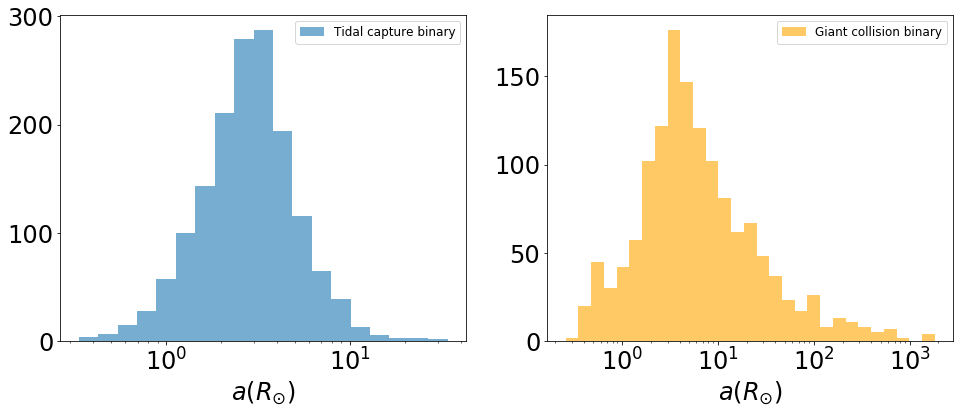

In [4]:
##Plot the distribution of SMA
collsma_init_emp, collsma_finl_index, collsma_des_emp = extract_key_index('sma', index_coll_bin, 'bin')
collrperi_init_index, collrperi_finl_emp, collrperi_des_emp = extract_key_index('rperi', index_coll_bin, 'bin')
tcsma_init_emp, tcsma_finl_index, tcsma_des_emp = extract_key_index('sma', index_tc_bin, 'bin')
tcrperi_init_index, tcrperi_finl_emp, tcrperi_des_emp = extract_key_index('rperi', index_tc_bin, 'bin')

#tc_sma = np.take(prop_finl['sma'], index_tc_bin)*AU_Rsun
#coll_sma = np.take(prop_finl['sma'], index_coll_bin)*AU_Rsun
#tc_rperi = np.take(prop_init['rperi'], index_tc_bin)
#coll_rperi = np.take(prop_init['rperi'], index_coll_bin)
tc_sma = []; coll_sma = []
for jj in range(len(paths)):
    tc_sma = tc_sma + [x*AU_Rsun for x in tcsma_finl_index[jj]]
    coll_sma = coll_sma + [y*AU_Rsun for y in collsma_finl_index[jj]]
    

fig, axs = plt.subplots(ncols = 2, figsize=(16, 6))
axs[0].hist(tc_sma, bins=np.logspace(np.log10(min(tc_sma)), np.log10(max(tc_sma)), 20), alpha=0.6, label = 'Tidal capture binary')
#axs[0].hist(tc_rperi, bins=np.logspace(np.log10(min(tc_rperi)), np.log10(max(tc_rperi)), 20), alpha=0.6)

axs[0].set_xscale('log')
axs[0].locator_params(axis='x', numticks = 6)
axs[0].set_xlabel(r'$a(R_{\odot})$')
axs[0].legend(loc='best', fontsize = 12)

axs[1].hist(coll_sma, bins=np.logspace(np.log10(min(coll_sma)), np.log10(max(coll_sma)), 30), color = 'orange', alpha=0.6, label = 'Giant collision binary')
axs[1].set_xscale('log')
axs[1].locator_params(axis='x', numticks = 6)
axs[1].set_xlabel(r'$a(R_{\odot})$')
axs[1].legend(loc='best', fontsize = 12)


In [34]:
##Check the hardness of tidal capture binaries
tc_hardness = []; coll_hardness = []
tc_length_ratio = []; coll_length_ratio = []

mave = 1.; v_sigma = 10. ##mave in solar unit, v_sigma in km/s
kt = mave*v_sigma**2

nloc = 10000.   ##pc^-3
length_factor = 0.1
lloc = length_factor*nloc**(-1/3)*PC_AU

for jj in range(len(paths)):
    for i in range(len(index_tc_bin[jj])):
        number_tc = int(index_tc_bin[jj][i])
        ebind_temp = Gconst_sun*prop_finl[str(jj)]['m0'][number_tc]*prop_finl[str(jj)]['m1'][number_tc]/(prop_finl[str(jj)]['sma'][number_tc]/PC_AU)
        tc_hardness.append(ebind_temp/kt)   
        tc_length_ratio.append(prop_finl[str(jj)]['sma'][number_tc]/lloc)


    for j in range(len(index_coll_bin[jj])):
        number_coll = int(index_coll_bin[jj][j])
        ebind_temp = Gconst_sun*prop_finl[str(jj)]['m0'][number_coll]*prop_finl[str(jj)]['m1'][number_coll]/(prop_finl[str(jj)]['sma'][number_coll]/PC_AU)
        coll_hardness.append(ebind_temp/kt)
        coll_length_ratio.append(prop_finl[str(jj)]['sma'][number_coll]/lloc)
    

    #print(tc_hardness, coll_hardness)
    print(jj, np.mean(tc_hardness), np.mean(coll_hardness))
    #print(tc_length_ratio, coll_length_ratio)
    print(jj, np.mean(tc_length_ratio), np.mean(coll_length_ratio))

0 1273.6344016038558 nan
0 1.5564741185534923e-05 nan


/software/anaconda3.6/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/software/anaconda3.6/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


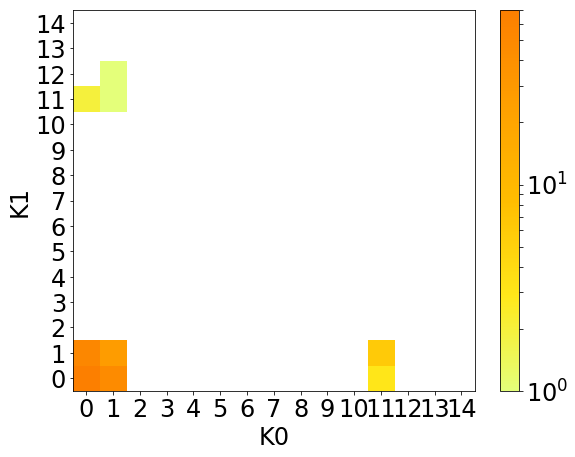

In [9]:
##Check sticky sphere collisions
K0 = []; K1 = []
for jj in range(len(paths)):
    sticky_k0 = np.take(all_sscoll[str(jj)]['k0'], index_sticky[jj])
    sticky_k1 = np.take(all_sscoll[str(jj)]['k1'], index_sticky[jj])
    sticky_id0 = np.take(all_sscoll[str(jj)]['id0'], index_sticky[jj])
    sticky_id1 = np.take(all_sscoll[str(jj)]['id1'], index_sticky[jj])

    K0=K0 + [x - 0.5 for x in sticky_k0]
    K1=K1 + [Y - 0.5 for Y in sticky_k1]
    
    for i in range(len(sticky_k0)):
        if 2<=sticky_k0[i]<=9 or 2<=sticky_k1[i]<=9:
            print(jj, sticky_id0[i], sticky_id1[i])
    
plt.figure(figsize = (9, 7))
ax=plt.gca()
plt.hist2d(K0, K1, bins=np.arange(16)-0.5, norm=mpl.colors.LogNorm(), cmap='Wistia')
ax.xaxis.set_major_locator(plt.MaxNLocator(15))
ax.yaxis.set_major_locator(plt.MaxNLocator(15))
plt.xlabel('K0')
plt.ylabel('K1')
plt.colorbar()

In [12]:
##Check tidal capture that leads to tidal disruption
def rochradius(m0, m1, sma):  ##sma is in AU, rl is in Rsun
    q = m0/m1   
    p = pow(q, 1.0/3.0)
    rl = 0.49*p*p/(0.6*p*p+math.log(1.0+p))*sma*AU_Rsun
    return rl
    
    
tcid0_init_index, tcid0_finl_index, tcid0_des_emp = extract_key_index('id0', index_tc_bin, 'bin')
tcid1_init_index, tcid1_finl_index, tcid1_des_emp = extract_key_index('id1', index_tc_bin, 'bin')
tcm0_init_index, tcm0_finl_index, tcm0_des_emp = extract_key_index('m0', index_tc_bin, 'bin')
tcm1_init_index, tcm1_finl_index, tcm1_des_emp = extract_key_index('m1', index_tc_bin, 'bin')
tcr0_init_index, tcr0_finl_index, tcr0_des_emp = extract_key_index('r0', index_tc_bin, 'bin')
tcr1_init_index, tcr1_finl_index, tcr1_des_emp = extract_key_index('r1', index_tc_bin, 'bin')
tck0_init_index, tck0_finl_index, tck0_des_emp = extract_key_index('k0', index_tc_bin, 'bin')
tck1_init_index, tck1_finl_index, tck1_des_emp = extract_key_index('k1', index_tc_bin, 'bin')
tcrperi_init_index, tcrperi_finl_emp, tcrperi_des_emp = extract_key_index('rperi', index_tc_bin, 'bin')
tcsma_init_emp, tcsma_finl_index, tcsma_des_emp = extract_key_index('sma', index_tc_bin, 'bin')
  
tc_m0 = tcm0_init_index; tc_r0 = tcr0_init_index; tc_k0 = tck0_init_index
tc_m1 = tcm1_init_index; tc_r1 = tcr1_init_index; tc_k1 = tck1_init_index
tc_id0 = tcid0_init_index; tc_id1 = tcid1_init_index
tc_rperi = tcrperi_init_index
tc_sma = tcsma_finl_index
n=[]
for jj in range(len(paths)):
    n.append(0)
    
    
    #tde_m0 = np.take(all_sscoll[str(jj)]['m0'], index_tde[jj])
    #tde_m1 = np.take(all_sscoll[str(jj)]['m1'], index_tde[jj])
    #tde_r0 = np.take(all_sscoll[str(jj)]['r0'], index_tde[jj])
    #tde_r1 = np.take(all_sscoll[str(jj)]['r1'], index_tde[jj])
    #tde_k0 = np.take(all_sscoll[str(jj)]['k0'], index_tde[jj])
    #tde_k1 = np.take(all_sscoll[str(jj)]['k1'], index_tde[jj])
    #tde_id0 = np.take(all_sscoll[str(jj)]['id0'], index_tde[jj])
    #tde_id1 = np.take(all_sscoll[str(jj)]['id1'], index_tde[jj])
    #tde_sma = np.take(all_sscoll[str(jj)]['rperi'], index_tde[jj])*2./AU_Rsun


    #print(tde_k0, tde_k1)
    #print(tde_id0, tde_id1)

    #for i in range(len(tde_m0)):
    #    rl0 = rochradius(tde_m0[i], tde_m1[i], tde_sma[i])
    #    rl1 = rochradius(tde_m1[i], tde_m0[i], tde_sma[i])
    #    if rl1>=tde_r1[i] and rl0>=tde_r0[i]:
    #        print(jj, tde_id0[i], tde_id1[i], tde_k0[i], tde_k1[i])
    
    for i in range(len(tc_m0[jj])):
        rl0 = rochradius(tc_m0[jj][i], tc_m1[jj][i], tc_sma[jj][i])
        rl1 = rochradius(tc_m1[jj][i], tc_m0[jj][i], tc_sma[jj][i])
        if rl1>=tc_r1[jj][i] and rl0>=tc_r0[jj][i]:
            if (tc_m0[jj][i]>1 or tc_m1[jj][i]>1) and (tc_k0[jj][i]!=14 and tc_k1[jj][i]!=14) and (tc_m0[jj][i]+tc_m1[jj][i])>1.4:
                n[jj]+=1
                print(jj, tc_id0[jj][i], tc_id1[jj][i], tc_k0[jj][i], tc_k1[jj][i], tc_m0[jj][i], tc_m1[jj][i])
                
print(n)

0 219279 462713 0 1 0.201 19.0
0 350208 18967 0 1 0.244 11.2
0 514504 232138 0 1 0.363 7.07
0 223797 36640 0 1 0.244 3.32
0 229688 264999 0 1 0.243 5.59
0 700374 476228 0 1 0.307 2.93
0 741492 568303 0 1 0.0884 5.69
0 12295 687427 1 1 6.83 0.691
0 73126 257141 1 1 0.766 2.01
0 96721 644563 1 1 5.6 1.04
0 199809 452454 1 0 1.52 0.449
0 134869 645796 0 1 0.25 2.29
0 434151 282908 0 12 0.0865 1.34
0 463367 577676 1 0 4.47 0.139
0 632489 168567 1 0 3.85 0.177
0 459531 616939 0 1 0.114 1.7
0 9141 633150 0 1 0.579 1.14
0 182266 704221 1 0 1.9 0.108
0 207110 717434 1 0 2.43 0.294
0 546795 177073 11 1 1.05 0.891
0 250647 293002 0 1 0.0821 1.78
0 505404 222353 0 1 0.0817 2.36
0 573686 321507 1 0 1.07 0.554
0 49189 773039 1 0 2.13 0.432
0 448081 22051 11 1 0.981 1.48
0 122671 429540 1 0 1.93 0.557
0 324580 453547 1 0 1.57 0.379
0 101905 603523 0 1 0.156 1.79
0 365374 369091 0 12 0.399 1.21
0 454810 263720 1 0 1.51 0.197
0 394184 3168 1 0 1.06 0.473
0 332258 625399 12 0 1.2 0.578
0 421521 660048 

In [11]:
##Check giant-giant collision that lead to merger
def coll_CE(Mrg, Mint, Mwd, Rrg, vinf):
    alpha1 = 1.0
    lambdaf = 0.5

    ##a_f in unit of solar radius
    return 1.0/(2.0*Mrg*(Mrg-Mwd)/(Mwd*Mint*alpha1*lambdaf*Rrg)-(Mrg+Mint)/(Gconst_sun*PC_Rsun*Mwd*Mint*alpha1)*vinf*vinf)


def coll_CE_twogiants(M1, M2, Mc1, Mc2, R1, R2, vinf):
    alpha1 = 1.0
    lambdaf = 0.5

    E_bindi = Gconst_sun*PC_Rsun/lambdaf*(M1*(M1-Mc1)/R1+M2*(M2-Mc2)/R2)
    E_orbi = 0.5*(M1+M2)*vinf*vinf

    af = Gconst_sun*PC_Rsun*Mc1*Mc2*alpha1/(2*(E_bindi-E_orbi))

    return af

def rochradius(m0, m1, sma):  ##sma is in AU, rl is in Rsun
    q = m0/m1   
    p = pow(q, 1.0/3.0)
    rl = 0.49*p*p/(0.6*p*p+math.log(1.0+p))*sma*AU_Rsun
    return rl


for jj in range(len(paths)):
    #gmerge_m0 = np.take(all_sscoll[str(jj)]['m0'], index_gmerge[jj])
    #gmerge_m1 = np.take(all_sscoll[str(jj)]['m1'], index_gmerge[jj])
    #gmerge_r0 = np.take(all_sscoll[str(jj)]['r0'], index_gmerge[jj])
    #gmerge_r1 = np.take(all_sscoll[str(jj)]['r1'], index_gmerge[jj])
    #gmerge_k0 = np.take(all_sscoll[str(jj)]['k0'], index_gmerge[jj])
    #gmerge_k1 = np.take(all_sscoll[str(jj)]['k1'], index_gmerge[jj])
    #gmerge_id0 = np.take(all_sscoll[str(jj)]['id0'], index_gmerge[jj])
    #gmerge_id1 = np.take(all_sscoll[str(jj)]['id1'], index_gmerge[jj])
    
    coll_m0_des = np.take(prop_des[str(jj)]['m0'], index_coll_des[jj])
    coll_m1_des = np.take(prop_des[str(jj)]['m1'], index_coll_des[jj])
    coll_mc0_des = np.take(prop_des[str(jj)]['mc0'], index_coll_des[jj])
    coll_mc1_des = np.take(prop_des[str(jj)]['mc1'], index_coll_des[jj])
   
    coll_r0_des = np.take(prop_des[str(jj)]['r0'], index_coll_des[jj])
    coll_r1_des = np.take(prop_des[str(jj)]['r1'], index_coll_des[jj])
    coll_rc0_des = np.take(prop_des[str(jj)]['rc0'], index_coll_des[jj])
    coll_rc1_des = np.take(prop_des[str(jj)]['rc1'], index_coll_des[jj])
    
    coll_k0_des = np.take(prop_des[str(jj)]['k0'], index_coll_des[jj])
    coll_k1_des = np.take(prop_des[str(jj)]['k1'], index_coll_des[jj])
    coll_id0_des = np.take(prop_des[str(jj)]['id0'], index_coll_des[jj])
    coll_id1_des = np.take(prop_des[str(jj)]['id1'], index_coll_des[jj])
    coll_vinf_des = np.take(prop_des[str(jj)]['vinf'], index_coll_des[jj])
    coll_rperi_des = np.take(prop_des[str(jj)]['rperi'], index_coll_des[jj])

    #print(gmerge_id0-coll_id0_des)
    
    ce_af = []
    n = 0
    for i in range(len(coll_k0_des)):
        if (2<=coll_k0_des[i]<=9 and coll_k0_des[i]!=7) and (2<=coll_k1_des[i]<=9 and coll_k1_des[i]!=7):
            ace_temp = coll_CE_twogiants(coll_m0_des[i], coll_m1_des[i], coll_mc0_des[i], coll_mc1_des[i],coll_r0_des[i], coll_r1_des[i], coll_vinf_des[i])
            ce_af.append(ace_temp)
            
            rl0 = rochradius(coll_mc0_des[i], coll_mc1_des[i], ace_temp/AU_Rsun)
            rl1 = rochradius(coll_mc1_des[i], coll_mc0_des[i], ace_temp/AU_Rsun)
            if rl1>=coll_rc1_des[i] and rl0>=coll_rc0_des[i] :
                print('Oops, something is wrong', jj, ace_temp, rl0, rl1, coll_rc0_des[i], coll_rc1_des[i], coll_rperi_des[i], 
                      coll_k0_des[i], coll_k1_des[i], coll_id0_des[i], coll_id1_des[i])
            
        elif 2<=coll_k0_des[i]<=9 and coll_k0_des[i]!=7:
            ecoll = 0.88 - coll_rperi_des[i]/(3.0*coll_r0_des[i])
            acoll = coll_rperi_des[i]/(3.3*(1.0-ecoll*ecoll))
            
            ace_temp = coll_CE(coll_m0_des[i], coll_m1_des[i], coll_mc0_des[i], coll_r0_des[i], coll_vinf_des[i])
            
            if acoll<=ace_temp:
                af_temp = acoll
            else:
                af_temp = ace_temp
            
            ce_af.append(af_temp)
            
            rl0 = rochradius(coll_mc0_des[i], coll_m1_des[i], af_temp/AU_Rsun)
            rl1 = rochradius(coll_m1_des[i], coll_mc0_des[i], af_temp/AU_Rsun)
            if rl1>=coll_r1_des[i] and rl0>=coll_rc0_des[i]:
                print('Oops, something is wrong', jj, af_temp, rl0, rl1, coll_rc0_des[i], coll_r1_des[i], coll_rperi_des[i], 
                      coll_k0_des[i], coll_k1_des[i], coll_id0_des[i], coll_id1_des[i], coll_r0_des[i], coll_r1_des[i])
                print(ace_temp, acoll)
                
        elif 2<=coll_k1_des[i]<=9 and coll_k1_des[i]!=7:
            ecoll = 0.88 - coll_rperi_des[i]/(3.0*coll_r1_des[i])
            acoll = coll_rperi_des[i]/(3.3*(1.0-ecoll*ecoll))
            
            ace_temp = coll_CE(coll_m1_des[i], coll_m0_des[i], coll_mc1_des[i], coll_r1_des[i], coll_vinf_des[i])
            
            if acoll<=ace_temp:
                af_temp = acoll
            else:
                af_temp = ace_temp
            
            ce_af.append(af_temp)  
            
            rl0 = rochradius(coll_m0_des[i], coll_mc1_des[i], af_temp/AU_Rsun)
            rl1 = rochradius(coll_mc1_des[i], coll_m0_des[i], af_temp/AU_Rsun)
            if rl1>=coll_rc1_des[i] and rl0>=coll_r0_des[i]:
                n+=1
                print('Oops, something is wrong', jj, af_temp, rl0, rl1, coll_r0_des[i], coll_rc1_des[i], coll_rperi_des[i], 
                      coll_k0_des[i], coll_k1_des[i], coll_id0_des[i], coll_id1_des[i], coll_r0_des[i], coll_r1_des[i])
                print(ace_temp, acoll)
    #print(len(coll_k0_des))
print(n)
#Something is wrong but I don't know why!

Oops, something is wrong 0 3.4103827836977425 2.5576189151353272 0.2696292113037442 2.52603 0.242529 3218.04 4 0 187930 310330 3777.54 0.242529
3.4103827836977425 1512.4927181819114
0


0 1 1 0.705 5.63 0.643295 2.09038
0 1 0 16.7 0.231 6.33671 0.243109
0 1 0 11.0 0.197 4.54174 0.215196
0 1 1 10.3 0.874 7.40899 0.797245
0 1 14 8.8 40.5 6.89164 0.00017172
1 1 0 10.5 0.234 3.03436 0.245111
1 0 1 0.205 39.4 0.22225 8.60654
1 1 14 12.4 14.6 6.15186 6.19227e-05
1 0 1 0.139 5.63 0.159785 2.3432
1 14 1 40.5 6.95 0.00017172 4.52093
1 14 1 29.5 6.72 0.000125197 5.91418
1 0 1 0.16 6.33 0.181616 5.35434
2 0 1 0.547 25.6 0.483549 5.75484
2 1 1 11.8 63.1 3.41654 13.5811
2 1 0 24.7 0.121 12.8325 0.138592
2 1 0 9.2 0.568 3.99774 0.50373
2 0 1 0.14 6.08 0.160345 2.6275
2 1 1 1.88 5.74 1.10508 3.03357
3 1 0 19.6 0.136 4.6042 0.155975
3 1 0 66.4 0.581 11.2714 0.516591
3 1 0 9.59 0.134 3.037 0.154005
4 1 1 43.3 14.2 10.2589 3.95255
4 1 1 40.7 5.41 14.9558 2.05624
4 1 14 5.98 18.1 3.32493 7.67923e-05
5 1 0 14.1 0.291 3.80201 0.285807
5 1 0 85.8 0.641 36.2193 0.577031
5 0 1 0.283 13.5 0.280753 4.1915
5 14 1 13.6 6.18 5.76363e-05 4.48243
6 1 0 5.68 0.6 2.44919 0.535329
7 1 0 5.64 0.329 2.6

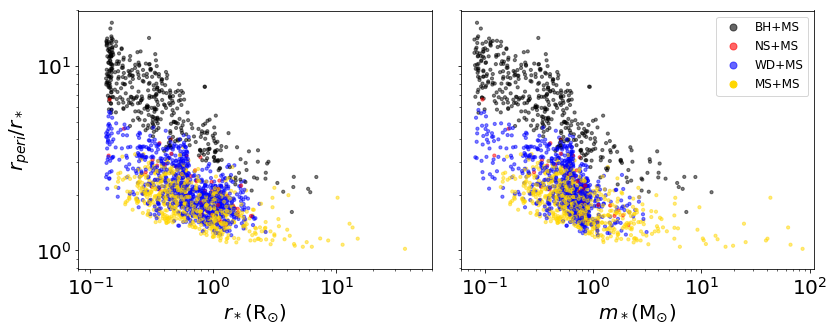

In [13]:
# M-Rperi relation of tidal capture
tcm0_init_index, tcm0_finl_index, tcm0_des_emp = extract_key_index('m0', index_tc_bin, 'bin')
tcm1_init_index, tcm1_finl_index, tcm1_des_emp = extract_key_index('m1', index_tc_bin, 'bin')
tcr0_init_index, tcr0_finl_index, tcr0_des_emp = extract_key_index('r0', index_tc_bin, 'bin')
tcr1_init_index, tcr1_finl_index, tcr1_des_emp = extract_key_index('r1', index_tc_bin, 'bin')
tck0_init_index, tck0_finl_index, tck0_des_emp = extract_key_index('k0', index_tc_bin, 'bin')
tck1_init_index, tck1_finl_index, tck1_des_emp = extract_key_index('k1', index_tc_bin, 'bin')
tcrperi_init_index, tcrperi_finl_emp, tcrperi_des_emp = extract_key_index('rperi', index_tc_bin, 'bin')

#tc_rperi = np.take(prop_init['rperi'], index_tc_bin)
#tc_k0 = np.take(prop_init['k0'], index_tc_bin)
#tc_k1 = np.take(prop_init['k1'], index_tc_bin)
#tc_m0 = np.take(prop_init['m0'], index_tc_bin)
#tc_m1 = np.take(prop_init['m1'], index_tc_bin)
#tc_r0 = np.take(prop_init['r0'], index_tc_bin)
#tc_r1 = np.take(prop_init['r1'], index_tc_bin)

tc_rperi = tcrperi_init_index
tc_k0 = tck0_init_index; tc_m0 = tcm0_init_index; tc_r0 = tcr0_init_index
tc_k1 = tck1_init_index; tc_m1 = tcm1_init_index; tc_r1 = tcr1_init_index

matplotlib.rcParams.update({'font.size': 20})

kdot=mlines.Line2D([], [],  linestyle = 'None', color='k', marker='o',
                  markersize=7, alpha=0.6, label='BH+MS')
rdot=mlines.Line2D([], [],  linestyle = 'None', color='r', marker='o',
                  markersize=7, alpha=0.6, label='NS+MS')
bdot=mlines.Line2D([], [],  linestyle = 'None', color='b', marker='o',
                  markersize=7, alpha=0.6, label='WD+MS')
ydot=mlines.Line2D([], [],  linestyle = 'None', color='gold', marker='o',
                  markersize=7, label='MS+MS')


fig, axs = plt.subplots(ncols=2, sharey = True, figsize = (12, 5))
for jj in range(len(paths)):
    rstar = []; mstar = []; cs = []
    for i in range(len(tc_k0[jj])):
        if tc_k0[jj][i] < 10 and tc_k1[jj][i] < 10:
            rstar.append(max(tc_r0[jj][i], tc_r1[jj][i]))
            mstar.append(max(tc_m0[jj][i], tc_m1[jj][i]))
            cs.append('gold')
            
        elif tc_k0[jj][i] < 10:
            rstar.append(tc_r0[jj][i]); mstar.append(tc_m0[jj][i])
            if 10 <= tc_k1[jj][i] <= 12: cs.append('b')
            elif tc_k1[jj][i] == 13: cs.append('r')
            elif tc_k1[jj][i] == 14: cs.append('k')
            
        elif tc_k1[jj][i] < 10:
            rstar.append(tc_r1[jj][i]); mstar.append(tc_m1[jj][i])
            if 10 <= tc_k0[jj][i] <= 12: cs.append('b')
            elif tc_k0[jj][i] == 13: cs.append('r')
            elif tc_k0[jj][i] == 14: cs.append('k')
        
        else:
            print("What's going on?")
        
        if (tc_k0[jj][i]<=1 and tc_m0[jj][i]>=5) or (tc_k1[jj][i]<=1 and tc_m1[jj][i]>=5):
            print(jj, tc_k0[jj][i], tc_k1[jj][i], tc_m0[jj][i], tc_m1[jj][i], tc_r0[jj][i], tc_r1[jj][i])
            
    rstar = np.array(rstar); mstar = np.array(mstar)    
    axs[0].scatter(rstar, tc_rperi[jj]/rstar, alpha=0.5, s = 10, color = cs)
    axs[1].scatter(mstar, tc_rperi[jj]/rstar, alpha=0.5, s = 10, color = cs)

axs[0].set_xlim(0.08, 60)
axs[0].set_ylabel(r'$r_{peri}/r_*$')
axs[0].set_xlabel(r'$r_* (\rm{R_{\odot}})$')
#axs[1].set_ylabel(r'$r_{peri}/r_*$')

axs[1].set_xlim(0.06, 110)
axs[1].set_xlabel(r'$m_* (\rm{M_{\odot}})$')

axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[1].set_yscale('log')
axs[1].set_xscale('log')
axs[1].legend(handles=[kdot, rdot, bdot, ydot], loc='best', prop={'size': 12}, numpoints=1, frameon=True)

fig.tight_layout()
#plt.savefig('/projects/b1095/syr904/projects/massive_clusters/tc_model_rperi.pdf', bbox_inches='tight', dpi=300)
#plt.suptitle('Tidal Capture')

697 695 1392
626 376 1002
0.44089456869009586
1081 1075 764
1084 644 726
0.15498154981549817
1358 1348 550
1501 865 638
0.08527648234510327
1525 1511 330
1796 980 410
0.045657015590200446
1659 1645 268
2038 1088 350
0.029440628066732092
1757 1743 196
2283 1187 344
0.024529128339903637
1795 1781 76
2422 1246 198
0.012386457473162676
1817 1803 44
2522 1286 140
0.007137192704203013
1819 1805 4
2580 1304 76
0.0034883720930232558
1822 1808 6
2602 1310 28
0.002690238278247502


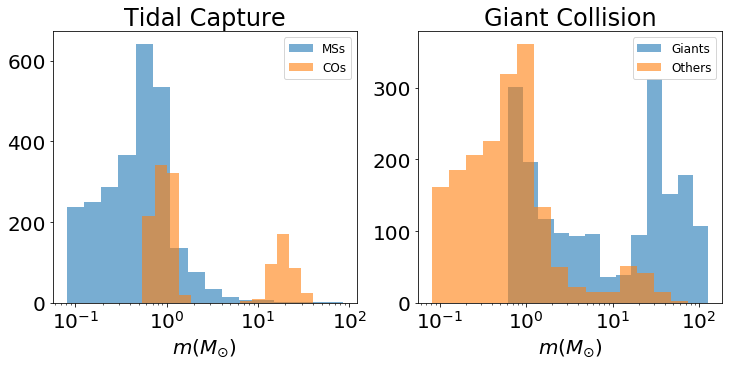

In [14]:
##Mass distribution of giant collision and tidal capture
tcm0_init_index, tcm0_finl_index, tcm0_des_emp = extract_key_index('m0', index_tc_bin, 'bin')
tcm1_init_index, tcm1_finl_index, tcm1_des_emp = extract_key_index('m1', index_tc_bin, 'bin')
tck0_init_index, tck0_finl_index, tck0_des_emp = extract_key_index('k0', index_tc_bin, 'bin')
tck1_init_index, tck1_finl_index, tck1_des_emp = extract_key_index('k1', index_tc_bin, 'bin')
collm0_init_index, collm0_finl_index, collm0_des_emp = extract_key_index('m0', index_coll_bin, 'bin')
collm1_init_index, collm1_finl_index, collm1_des_emp = extract_key_index('m1', index_coll_bin, 'bin')
collk0_init_index, collk0_finl_index, collk0_des_emp = extract_key_index('k0', index_coll_bin, 'bin')
collk1_init_index, collk1_finl_index, collk1_des_emp = extract_key_index('k1', index_coll_bin, 'bin')

tc_k0 = tck0_init_index; tc_m0 = tcm0_init_index
tc_k1 = tck1_init_index; tc_m1 = tcm1_init_index
coll_k0 = collk0_init_index; coll_m0 = collm0_init_index
coll_k1 = collk1_init_index; coll_m1 = collm1_init_index

#tc_k0 = np.take(prop_init['k0'], index_tc_bin)
#tc_k1 = np.take(prop_init['k1'], index_tc_bin)
#tc_m0 = np.take(prop_init['m0'], index_tc_bin)
#tc_m1 = np.take(prop_init['m1'], index_tc_bin)
#coll_m0 = np.take(prop_init['m0'], index_coll_bin)
#coll_m1 = np.take(prop_init['m1'], index_coll_bin)
#coll_k0 = np.take(prop_init['k0'], index_coll_bin)
#coll_k1 = np.take(prop_init['k1'], index_coll_bin)

tc_msm = []; tc_com = []
coll_giantm = []; coll_otherm = []
n_masscut = []  ##mass cut at 0.7 msun
for jj in range(len(paths)):
    tc_totm = tc_m0[jj]+tc_m1[jj]
    coll_totm = coll_m0[jj]+coll_m1[jj]
    
    n_masscut.append(0)
    
    for i in range(len(coll_k0[jj])):
        if 2<=coll_k0[jj][i]<=9 and coll_k0[jj][i]!=7:
            coll_giantm.append(coll_m0[jj][i])
        else:
            coll_otherm.append(coll_m0[jj][i])
        
        if 2<=coll_k1[jj][i]<=9 and coll_k1[jj][i]!=7:
            coll_giantm.append(coll_m1[jj][i])
        else:
            coll_otherm.append(coll_m1[jj][i])
    print(len(coll_giantm), len(coll_otherm), len(coll_totm))
    
    
    for i in range(len(tc_k0[jj])):
        if tc_k0[jj][i] <= 1 or tc_k0[jj][i] == 7:
            tc_msm.append(tc_m0[jj][i])
            if tc_m0[jj][i]>=0.7:
                n_masscut[jj]+=1
        else:
            tc_com.append(tc_m0[jj][i])
            
        if tc_k1[jj][i] <= 1 or tc_k1[jj][i] == 7:
            tc_msm.append(tc_m1[jj][i])
            if tc_m1[jj][i]>=0.7:
                n_masscut[jj]+=1
        else:
            tc_com.append(tc_m1[jj][i])
            
    print(len(tc_msm), len(tc_com), len(tc_totm))
    
    print(n_masscut[jj]/len(tc_msm))

fig, axs = plt.subplots(ncols = 2, figsize = (12, 5))
#axs[0].hist(tc_totm, bins = np.logspace(np.log10(min(tc_totm)), np.log10(max(tc_totm)), 20), label = 'Tidal Capture', alpha=0.6)
#axs[1].hist(coll_totm, bins = np.logspace(np.log10(min(coll_totm)), np.log10(max(coll_totm)), 20), histtype= 'step', color = 'k', lw = 4, alpha=0.6)
axs[0].hist(tc_msm, bins = np.logspace(np.log10(min(tc_msm)), np.log10(max(tc_msm)), 17), alpha=0.6, label = 'MSs')
axs[0].hist(tc_com, bins = np.logspace(np.log10(min(tc_com)), np.log10(max(tc_com)), 15), alpha=0.6, label = 'COs')

axs[1].hist(coll_giantm, bins = np.logspace(np.log10(min(coll_giantm)), np.log10(max(coll_giantm)), 14), alpha=0.6, label = 'Giants')
axs[1].hist(coll_otherm, bins = np.logspace(np.log10(min(coll_otherm)), np.log10(max(coll_otherm)), 16), alpha=0.6, label = 'Others')


axs[0].set_xlabel(r'$m (M_{\odot})$')
axs[1].set_xlabel(r'$m (M_{\odot})$')

axs[0].set_xscale('log')
axs[1].set_xscale('log')

axs[0].set_title('Tidal Capture')
axs[1].set_title('Giant Collision')

axs[0].legend(loc='best', fontsize=12)
axs[1].legend(loc='best', fontsize=12)


5938 5708 11646
0 0 0.292 0.418
14 0 20.7 0.554
0 1 0.341 3.34
0 0 0.21 0.503
0 0 0.257 0.634
0 14 0.613 11.4
0 14 0.628 16.3
0 1 0.466 4.73
0 0 0.333 0.411
0 1 0.16 3.03
0 1 0.22 2.56
0 1 0.149 1.58
0 1 0.594 1.04
0 1 0.169 6.42
0 1 0.472 3.18
0 1 0.163 1.61
0 14 0.422 34.1
0 0 0.589 0.355
0 0 0.481 0.278
0 14 0.5 13.7
1 14 0.681 15.9
0 0 0.174 0.449
0 1 0.427 3.85
14 0 13.4 0.331
0 0 0.268 0.4
14 0 16.8 0.466
14 0 16.2 0.392
0 1 0.509 3.33
0 1 0.266 4.6
0 1 0.381 1.71
0 1 0.361 1.42
1 1 0.675 3.59
0 0 0.167 0.443
0 1 0.169 1.17
1 0 0.679 0.539
0 0 0.132 0.575
0 1 0.564 1.98
0 14 0.191 13.6
0 0 0.524 0.202
0 0 0.56 0.317
0 14 0.129 16.6
0 0 0.203 0.254
0 0 0.141 0.442
11 0 0.971 0.531
0 0 0.639 0.184
0 1 0.317 0.686
1 1 0.681 2.2
0 0 0.363 0.533
0 1 0.478 1.28
0 1 0.547 2.64
0 0 0.612 0.614
0 1 0.323 1.12
0 0 0.431 0.0955
0 1 0.585 0.955
0 0 0.137 0.485
0 1 0.649 0.793
14 0 13.9 0.58
0 0 0.377 0.648
0 1 0.638 1.62
1 14 0.668 16.1
0 11 0.473 0.892
0 1 0.386 0.761
0 14 0.435 16.5
1 14 0

ValueError: min() arg is an empty sequence

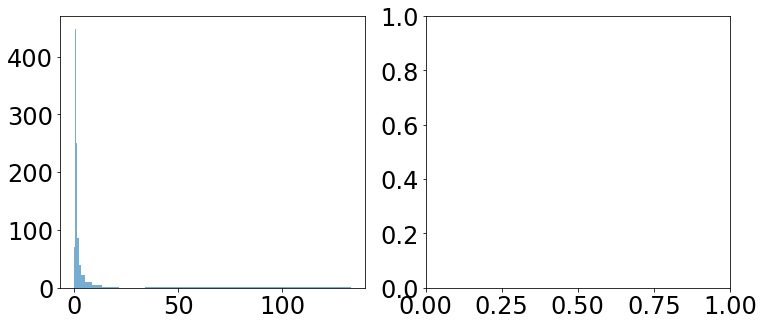

In [6]:
##All mass distribution of giant collision and tidal capture (including merging systems)
tcm0_init_index, tcm0_finl_index, tcm0_des_emp = extract_key_index('m0', index_tc_bin, 'bin')
tcm1_init_index, tcm1_finl_index, tcm1_des_emp = extract_key_index('m1', index_tc_bin, 'bin')
tck0_init_index, tck0_finl_index, tck0_des_emp = extract_key_index('k0', index_tc_bin, 'bin')
tck1_init_index, tck1_finl_index, tck1_des_emp = extract_key_index('k1', index_tc_bin, 'bin')
collm0_init_index, collm0_finl_index, collm0_des_emp = extract_key_index('m0', index_coll_bin, 'bin')
collm1_init_index, collm1_finl_index, collm1_des_emp = extract_key_index('m1', index_coll_bin, 'bin')
collk0_init_index, collk0_finl_index, collk0_des_emp = extract_key_index('k0', index_coll_bin, 'bin')
collk1_init_index, collk1_finl_index, collk1_des_emp = extract_key_index('k1', index_coll_bin, 'bin')

tc_k0 = tck0_init_index; tc_m0 = tcm0_init_index
tc_k1 = tck1_init_index; tc_m1 = tcm1_init_index
coll_k0 = collk0_init_index; coll_m0 = collm0_init_index
coll_k1 = collk1_init_index; coll_m1 = collm1_init_index

tcm0_init_emp, tcm0_finl_emp, tcm0_des_index = extract_key_index('m0', index_tc_des, 'des')
tcm1_init_emp, tcm1_finl_emp, tcm1_des_index = extract_key_index('m1', index_tc_des, 'des')
tck0_init_emp, tck0_finl_emp, tck0_des_index = extract_key_index('k0', index_tc_des, 'des')
tck1_init_emp, tck1_finl_emp, tck1_des_index = extract_key_index('k1', index_tc_des, 'des')
collm0_init_emp, collm0_finl_emp, collm0_des_index = extract_key_index('m0', index_coll_des, 'des')
collm1_init_emp, collm1_finl_emp, collm1_des_index = extract_key_index('m1', index_coll_des, 'des')
collk0_init_emp, collk0_finl_emp, collk0_des_index = extract_key_index('k0', index_coll_des, 'des')
collk1_init_emp, collk1_finl_emp, collk1_des_index = extract_key_index('k1', index_coll_des, 'des')

tc_k0_des = tck0_des_index; tc_m0_des = tcm0_des_index
tc_k1_des = tck1_des_index; tc_m1_des = tcm1_des_index
coll_k0_des = collk0_des_index; coll_m0_des = collm0_des_index
coll_k1_des = collk1_des_index; coll_m1_des = collm1_des_index

#tc_bin_m0 = np.take(prop_init['m0'], index_tc_bin)
#tc_bin_m1 = np.take(prop_init['m1'], index_tc_bin)
#tc_bin_k0 = np.take(prop_init['k0'], index_tc_bin)
#tc_bin_k1 = np.take(prop_init['k1'], index_tc_bin)
#coll_bin_m0 = np.take(prop_init['m0'], index_coll_bin)
#coll_bin_m1 = np.take(prop_init['m1'], index_coll_bin)
#coll_bin_k0 = np.take(prop_init['k0'], index_coll_bin)
#coll_bin_k1 = np.take(prop_init['k1'], index_coll_bin)
#
#tc_des_m0 = np.take(prop_des['m0'], index_tc_des)
#tc_des_m1 = np.take(prop_des['m1'], index_tc_des)
#tc_des_k0 = np.take(prop_des['k0'], index_tc_des)
#tc_des_k1 = np.take(prop_des['k1'], index_tc_des)
#coll_des_m0 = np.take(prop_des['m0'], index_coll_des)
#coll_des_m1 = np.take(prop_des['m1'], index_coll_des)
#coll_des_k0 = np.take(prop_des['k0'], index_coll_des)
#coll_des_k1 = np.take(prop_des['k1'], index_coll_des)
#
#tc_all_m0 = np.concatenate((tc_bin_m0, tc_des_m0))
#tc_all_m1 = np.concatenate((tc_bin_m1, tc_des_m1))
#tc_all_k0 = np.concatenate((tc_bin_k0, tc_des_k0))
#tc_all_k1 = np.concatenate((tc_bin_k1, tc_des_k1))
#coll_all_m0 = np.concatenate((coll_bin_m0, coll_des_m0))
#coll_all_m1 = np.concatenate((coll_bin_m1, coll_des_m1))
#coll_all_k0 = np.concatenate((coll_bin_k0, coll_des_k0))
#coll_all_k1 = np.concatenate((coll_bin_k1, coll_des_k1))
#
#tc_all_totm = np.concatenate((tc_all_m0, tc_all_m1))
#coll_all_totm = np.concatenate((coll_all_m0, coll_all_m1))

tc_all_msm = []; tc_all_com = []
coll_all_giantm = []; coll_all_otherm = []
for jj in range(len(paths)):
    tc_all_m0 = tc_m0[jj]+tc_m0_des[jj]
    tc_all_m1 = tc_m1[jj]+tc_m1_des[jj]
    tc_all_k0 = tc_k0[jj]+tc_k0_des[jj]
    tc_all_k1 = tc_k1[jj]+tc_k1_des[jj]
    
    coll_all_m0 = coll_m0[jj]+coll_m0_des[jj]
    coll_all_m1 = coll_m1[jj]+coll_m1_des[jj]
    coll_all_k0 = coll_k0[jj]+coll_k0_des[jj]
    coll_all_k1 = coll_k1[jj]+coll_k1_des[jj]
    
    tc_all_totm = tc_all_m0 + tc_all_m1
    coll_all_totm = coll_all_m0 + coll_all_m1
    
    n_masscut=0 ##mass cut at 0.7 msun
    
    for i in range(len(coll_all_k0)):
        if 2<=coll_all_k0[i]<=9 and coll_all_k0[i]!=7:
            coll_all_giantm.append(coll_all_m0[i])
        else:
            coll_all_otherm.append(coll_all_m0[i])
        
        if 2<=coll_all_k1[i]<=9 and coll_all_k1[i]!=7:
            coll_all_giantm.append(coll_all_m1[i])
        else:
            coll_all_otherm.append(coll_all_m1[i])
    print(len(coll_all_giantm), len(coll_all_otherm), len(coll_all_totm))


    for i in range(len(tc_all_k0)):
        if tc_all_k0[i] <= 1 or tc_all_k0[i] == 7:
            tc_all_msm.append(tc_all_m0[i])
            if tc_all_m0[i]<=0.7:
                n_masscut+=1
                print(tc_all_k0[i], tc_all_k1[i], tc_all_m0[i], tc_all_m1[i])
        #else:
        #    tc_all_com.append(tc_all_m0[i])
            
        elif tc_all_k1[i] <= 1 or tc_all_k1[i] == 7:
            tc_all_msm.append(tc_all_m1[i])
            if tc_all_m1[i]<=0.7:
                n_masscut+=1
                print(tc_all_k0[i], tc_all_k1[i], tc_all_m0[i], tc_all_m1[i])
        #else:
        #    tc_all_com.append(tc_all_m1[i])
            
    print(len(tc_all_msm), len(tc_all_com), len(tc_all_totm))
    print(n_masscut/len(tc_all_msm))

fig, axs = plt.subplots(ncols = 2, figsize = (12, 5))
#axs[0].hist(tc_totm, bins = np.logspace(np.log10(min(tc_totm)), np.log10(max(tc_totm)), 20), label = 'Tidal Capture', alpha=0.6)
#axs[1].hist(coll_totm, bins = np.logspace(np.log10(min(coll_totm)), np.log10(max(coll_totm)), 20), histtype= 'step', color = 'k', lw = 4, alpha=0.6)
axs[0].hist(tc_all_msm, bins = np.logspace(np.log10(min(tc_all_msm)), np.log10(max(tc_all_msm)), 17), alpha=0.6, label = 'MSs')
axs[0].hist(tc_all_com, bins = np.logspace(np.log10(min(tc_all_com)), np.log10(max(tc_all_com)), 15), alpha=0.6, label = 'COs')

axs[1].hist(coll_all_giantm, bins = np.logspace(np.log10(min(coll_all_giantm)), np.log10(max(coll_all_giantm)), 14), alpha=0.6, label = 'Giants')
axs[1].hist(coll_all_otherm, bins = np.logspace(np.log10(min(coll_all_otherm)), np.log10(max(coll_all_otherm)), 16), alpha=0.6, label = 'Others')

axs[0].set_xlabel(r'$m (M_{\odot})$')
axs[1].set_xlabel(r'$m (M_{\odot})$')

axs[0].set_xscale('log')
axs[1].set_xscale('log')

axs[0].set_title('Tidal Capture')
axs[1].set_title('Giant Collision')

axs[0].legend(loc='best', fontsize=12)
axs[1].legend(loc='best', fontsize=12)


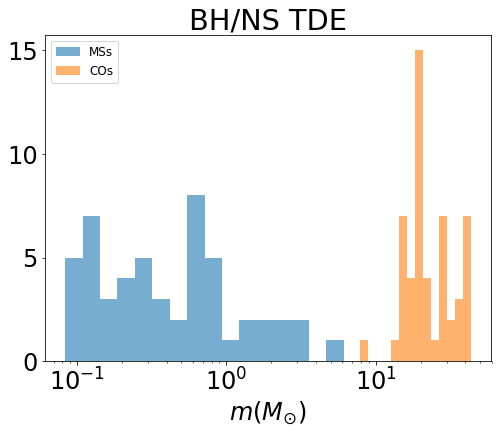

In [41]:
##Mass distribution of BHNS TDE
bhns_tde_msm = []; bhns_tde_com = []
for jj in range(len(paths)):
    bhns_tde_m0 = np.take(all_sscoll[str(jj)]['m0'], index_bhns_tde[jj])
    bhns_tde_m1 = np.take(all_sscoll[str(jj)]['m1'], index_bhns_tde[jj])
    bhns_tde_k0 = np.take(all_sscoll[str(jj)]['k0'], index_bhns_tde[jj])
    bhns_tde_k1 = np.take(all_sscoll[str(jj)]['k1'], index_bhns_tde[jj])
    
    for i in range(len(bhns_tde_k0)):
        if bhns_tde_k0[i] <= 1:
            bhns_tde_msm.append(bhns_tde_m0[i])
        else:
            bhns_tde_com.append(bhns_tde_m0[i])
            
        if bhns_tde_k1[i] <= 1:
            bhns_tde_msm.append(bhns_tde_m1[i])
        else:
            bhns_tde_com.append(bhns_tde_m1[i])
        
        
fig, axs = plt.subplots(figsize = (8,6))

axs.hist(bhns_tde_msm, bins = np.logspace(np.log10(min(bhns_tde_msm)), np.log10(max(bhns_tde_msm)), 17), alpha=0.6, label = 'MSs')
axs.hist(bhns_tde_com, bins = np.logspace(np.log10(min(bhns_tde_com)), np.log10(max(bhns_tde_com)), 15), alpha=0.6, label = 'COs')


axs.set_xlabel(r'$m (M_{\odot})$')
axs.set_xscale('log')
axs.set_title('BH/NS TDE')
axs.legend(loc='best', fontsize=12)

In [5]:
##Check binary types of tidal capture and giant collision binaries
from IPython.display import display_html, display
def display_side_by_side(*args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'), raw=True)


tc_init = np.zeros([15, 15]); tc_finl = np.zeros([15, 15])
coll_init = np.zeros([15, 15]); coll_finl = np.zeros([15, 15])
for jj in range(len(paths)):
    tc_k0_finl = np.take(prop_finl[str(jj)]['k0'], index_tc_bin[jj])
    tc_k1_finl = np.take(prop_finl[str(jj)]['k1'], index_tc_bin[jj])
    tc_k0_init = np.take(prop_init[str(jj)]['k0'], index_tc_bin[jj])
    tc_k1_init = np.take(prop_init[str(jj)]['k1'], index_tc_bin[jj])
    
    
    coll_k0_finl = np.take(prop_finl[str(jj)]['k0'], index_coll_bin[jj])
    coll_k1_finl = np.take(prop_finl[str(jj)]['k1'], index_coll_bin[jj])
    coll_k0_init = np.take(prop_init[str(jj)]['k0'], index_coll_bin[jj])
    coll_k1_init = np.take(prop_init[str(jj)]['k1'], index_coll_bin[jj])
    

    for i in range(len(tc_k0_init)):
        x_tmp = tc_k0_init[i]; y_tmp = tc_k1_init[i]
        if x_tmp < y_tmp: 
            xvalue = x_tmp; yvalue = y_tmp
        else: 
            xvalue = y_tmp; yvalue = x_tmp
            
        tc_init[xvalue, yvalue]+=1
    
    for x in range(len(tc_k0_finl)):
        x_tmp = tc_k0_finl[x]; y_tmp = tc_k1_finl[x]
        if x_tmp < y_tmp: 
            xvalue = x_tmp; yvalue = y_tmp
        else: 
            xvalue = y_tmp; yvalue = x_tmp
            
        tc_finl[xvalue, yvalue]+=1
    
    for j in range(len(coll_k0_init)):
        x_tmp = coll_k0_init[j]; y_tmp = coll_k1_init[j]
        if x_tmp < y_tmp: 
            xvalue = x_tmp; yvalue = y_tmp
        else: 
            xvalue = y_tmp; yvalue = x_tmp
            
        coll_init[xvalue, yvalue]+=1

    for y in range(len(coll_k0_finl)):
        x_tmp = coll_k0_finl[y]; y_tmp = coll_k1_finl[y]
        if x_tmp < y_tmp: 
            xvalue = x_tmp; yvalue = y_tmp
        else: 
            xvalue = y_tmp; yvalue = x_tmp
            
        coll_finl[xvalue, yvalue]+=1
    

df1 = pd.DataFrame(tc_init, columns=(np.linspace(0, 14, num=15, dtype=int)), dtype=np.int)
df2 = pd.DataFrame(tc_finl, columns=(np.linspace(0, 14, num=15, dtype=int)), dtype=np.int)
df3 = pd.DataFrame(coll_init, columns=(np.linspace(0, 14, num=15, dtype=int)), dtype=np.int)
df4 = pd.DataFrame(coll_finl, columns=(np.linspace(0, 14, num=15, dtype=int)), dtype=np.int)

display_side_by_side(df1, df2)
display_side_by_side(df3, df4)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,206,163,0,0,0,0,0,0,0,0,1,290,96,19,200
1,0,54,0,0,0,0,0,0,0,0,0,289,137,34,84
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,0,0,0,31,515,48,93,0,0,0,0,0,0,0,0
1,0,0,0,29,163,36,37,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2
3,0,0,0,0,2,1,0,0,0,0,0,110,52,19,15
4,0,0,0,0,3,0,0,0,0,0,0,68,32,5,56
5,0,0,0,0,0,0,0,0,0,0,0,12,5,2,9
6,0,0,0,0,0,0,0,0,0,0,0,24,11,1,5
7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


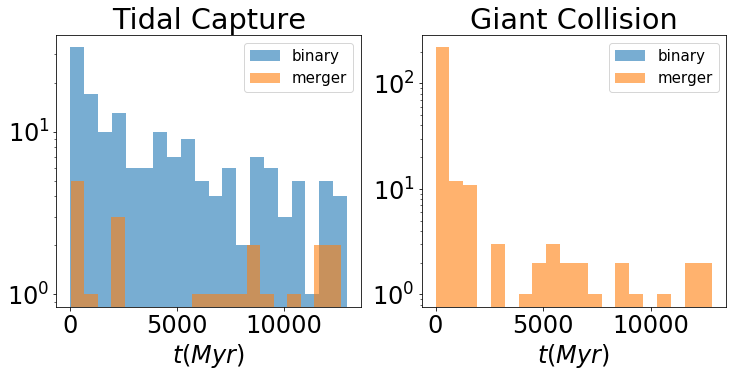

In [43]:
### Check time distribution of tidal capture and giant collision
tc_bin_time = []; tc_des_time = []
coll_bin_time = []; coll_des_time = []
for jj in range(len(paths)):
    tconv = dyn.conv('t', paths[jj]+'initial.conv.sh')

    tc_bin_time_temp = list(np.take(prop_init[str(jj)]['time'], index_tc_bin[jj])*tconv)
    tc_des_time_temp = list(np.take(prop_des[str(jj)]['time'], index_tc_des[jj])*tconv)
    coll_bin_time_temp = list(np.take(prop_init[str(jj)]['time'], index_coll_bin[jj])*tconv)
    coll_des_time_temp = list(np.take(prop_des[str(jj)]['time'], index_coll_des[jj])*tconv)
    
    tc_bin_time = tc_bin_time + tc_bin_time_temp
    tc_des_time = tc_des_time + tc_des_time_temp
    coll_bin_time = coll_bin_time + coll_bin_time_temp
    coll_des_time = coll_des_time + coll_des_time_temp


fig, axs = plt.subplots(ncols = 2, figsize = (12, 5))
axs[0].hist(tc_bin_time, bins = 20, alpha = 0.6, label = 'binary')
axs[0].hist(tc_des_time, bins = 20, alpha = 0.6, label = 'merger')
axs[1].hist(coll_bin_time, bins = 20, alpha = 0.6, label = 'binary')
axs[1].hist(coll_des_time, bins = 20, alpha = 0.6, label = 'merger')

axs[0].set_xlabel(r'$t(Myr)$')
axs[1].set_xlabel(r'$t(Myr)$')

axs[0].set_title('Tidal Capture')
axs[1].set_title('Giant Collision')

axs[0].set_yscale('log')
axs[1].set_yscale('log')

axs[0].legend(loc='best', fontsize=15)
axs[1].legend(loc='best', fontsize=15)

1.17 0.653 0.607411 9.18995 1.98925 0.681309349197295
1.24 0.844 0.985579 20.8676 1.97616 0.6310325930508003
1.24 1.71 1.0948 15.214 1.80427 0.46269317235023893
1.24 0.866 1.11392 27.3966 1.63202 0.4712328220885963
1.24 0.894 1.30745 5.1272 2.58428 0.9326173019930174
1.24 0.754 0.788117 2.02663 2.52133 0.9295173261785745
1.24 0.844 1.12259 4.1882 2.68399 0.9984056061491704
1.24 0.656 0.623475 3.82674 1.48237 0.4295911120277609
1.24 0.876 1.58362 18.859 2.66266 0.9795400017942132
1.24 0.844 1.14972 13.1765 2.37332 0.830190579599426
1.24 0.448 0.405395 16.5543 1.18285 0.32480507925181745
1.35 0.378 0.350129 11.6992 1.01088 0.2534916435870279
1.24 0.677 0.661709 6.29731 1.67246 0.5120724220405428
1.24 0.706 0.713188 5.68267 1.93821 0.6339430235503689
1.24 0.849 1.58631 11.2977 2.54455 0.9209400961681895
1.26 1.1 1.15837 9.73001 1.66763 0.45973718113967993
1.24 1.89 1.58115 6.74919 2.45041 0.7108175737698113
1.26 0.809 1.09886 0.634793 1.80279 0.5515023956761104
1.24 0.767 0.888268 8.11555

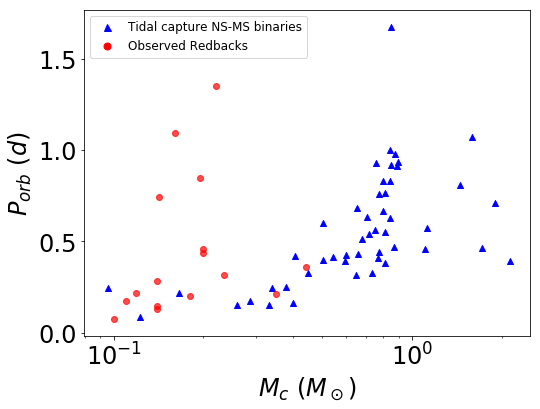

In [3]:
##Compare model tidal capture NS-MS with observed redbacks
##Tidal capture NS-MS binaries
rb_mns = []; rb_mms = []; rb_pb = []
for jj in range(len(paths)):
    m0 = np.take(prop_finl[str(jj)]['m0'], index_tc_bin[jj])
    m1 = np.take(prop_finl[str(jj)]['m1'], index_tc_bin[jj])
    k0 = np.take(prop_finl[str(jj)]['k0'], index_tc_bin[jj])
    k1 = np.take(prop_finl[str(jj)]['k1'], index_tc_bin[jj])
    sma = np.take(prop_finl[str(jj)]['sma'], index_tc_bin[jj])
    vinf = np.take(prop_init[str(jj)]['vinf'], index_tc_bin[jj])
    rperi = np.take(prop_init[str(jj)]['rperi'], index_tc_bin[jj])
    r0 = np.take(prop_init[str(jj)]['r0'], index_tc_bin[jj])
    r1 = np.take(prop_init[str(jj)]['r1'], index_tc_bin[jj])
    
    for x in range(len(k0)):
        if k0[x] == 13 and k1[x]<=1:
            rb_mns.append(m0[x]); rb_mms.append(m1[x])
            period = uc.au_to_period(sma[x], m0[x], m1[x])
            rb_pb.append(period)
            print(m0[x], m1[x], r1[x], vinf[x], rperi[x], period)
        if k1[x] == 13 and k0[x]<=1:
            rb_mns.append(m1[x]); rb_mms.append(m0[x])
            period = uc.au_to_period(sma[x], m0[x], m1[x])
            rb_pb.append(period)
            print(m1[x], m0[x], r0[x], vinf[x], rperi[x], period)
                                    
##GC redbacks and blackwidows
P, Pdot, Binflag, Namespin, Period, Ecc, Mc, Names, Pall, Bfall, Nameall = pc.readdata_freire()
print(len(Pall), len(Bfall))
print(Ecc)
datarb=np.genfromtxt('/projects/b1095/syr904/projects/PULSAR/data_observed/GCredback.dat', dtype=str)
databw=np.genfromtxt('/projects/b1095/syr904/projects/PULSAR/data_observed/GCblackwidow.dat', dtype=str)
namerb=datarb[:,0]; namebw=databw[:,0]

plt.rcParams['figure.figsize'] = [8,6]
rdot=mlines.Line2D([], [],  linestyle = 'None', color='r', marker='o',
                  markersize=7, label='Observed Redbacks')
btri=mlines.Line2D([], [],  linestyle = 'None', color='b', marker='^',
                  markersize=7, label='Tidal capture NS-MS binaries')

fig, axs = plt.subplots()
for i in range(len(Mc)):
    if Mc[i][0] != '>':
        if Names[i] in namerb:
            axs.scatter(float(Mc[i]), float(Period[i]), color='red', alpha=0.7, zorder=2)
            print(Nameall[i], Mc[i], Period[i], Ecc[i])
                  
        #elif Names[i] in namebw:
        #    axs.scatter(float(Mc[i]), float(Period[i]), color='k', alpha=0.7, zorder=2)

axs.scatter(rb_mms, rb_pb, marker = '^', color = 'b')

axs.set_xscale('log')
axs.set_xlabel(r'$M_c\ (M_\odot)$')
axs.set_ylabel(r'$P_{orb}\ (d)$')
axs.legend(handles=[btri, rdot], loc='upper left', prop={'size': 12}, numpoints=1, frameon=True)

In [3]:
##Extract cluster properties from the tidal capture model and the standard model
dyn_tc = []; bh_tc = []; ns_tc = []
dyn_comp = []; bh_comp = []; ns_comp = []

paths_tcon = np.genfromtxt('/projects/b1095/syr904/cmc/cmc-mpi-tidalcapture/rvgrid/standard_models_tcon/test18_mpi1/path_text18_tcon.dat', dtype=str)
paths_comp = np.genfromtxt('/projects/b1095/syr904/cmc/cmc-mpi-tidalcapture/rvgrid/standard_models_tctdegiantoff/test18_mpi1/path_text18_alloff.dat', dtype=str)

for jj in range(len(paths_tcon)):
    print(jj)
    dyn_tc.append(np.genfromtxt(paths_tcon[jj]+'initial.dyn.dat'))
    #bin_tc.append(np.genfromtxt(paths[jj]+'initial.bin.dat'))
    dyn_comp.append(np.genfromtxt(paths_comp[jj]+'initial.dyn.dat'))
    #bin_comp.append(np.genfromtxt(paths_comp[jj]+'initial.bin.dat'))
    bh_tc.append(np.genfromtxt(paths_tcon[jj]+'initial.bh.dat'))
    bh_comp.append(np.genfromtxt(paths_comp[jj]+'initial.bh.dat'))
    ns_tc.append(np.genfromtxt(paths_tcon[jj]+'initial.ns.dat'))
    ns_comp.append(np.genfromtxt(paths_comp[jj]+'initial.ns.dat'))
    
#print(ns_tc)
#print(dyn_tc[9][:,3])

0
1
2


In [4]:
def addColorbar(
    ax,cmap,
    vmin,vmax,
    label,logflag = 0,
    fontsize=16,cmap_number=0,
    tick_tuple=None):
    if logflag:
        from matplotlib.colors import LogNorm as norm
        ticks = np.linspace(np.log10(vmin),np.log10(vmax),5,endpoint=True)
        tick_labels= [r"$10^{%.1f}$"%tick for tick in ticks]
        ticks = 10**ticks
    else:
        from matplotlib.colors import Normalize as norm
        ticks = np.linspace(vmin,vmax,5,endpoint=True)
        tick_labels= ticks
    
    if tick_tuple is not None:
        ticks,tick_labels = tick_tuple

    fig = ax.get_figure()
    
    ## x,y of bottom left corner, width,height in percentage of figure size
    ## matches the default aspect ratio of matplotlib
    cur_size = fig.get_size_inches()*fig.dpi        

    cur_height = cur_size[1]
    cur_width = cur_size[0]
    offset = 0.00 + cmap_number*(25/cur_width+50/cur_width)

    ax1 = fig.add_axes([0.91 + offset, 0.135, 25./cur_width, 0.75])

    cb1 = matplotlib.colorbar.ColorbarBase(
        ax1, cmap=cmap,
        #extend='both',
        extendfrac=0.05,
        norm=norm(vmin=vmin,vmax=vmax),
        orientation='vertical')


    #cb1.set_label(label,fontsize=fontsize)

    cb1.set_ticks(ticks)
    cb1.set_ticklabels(tick_labels)
    cb1.ax.tick_params(labelsize=fontsize-2)
    return cb1,ax1

(500, 28137.921294521682)

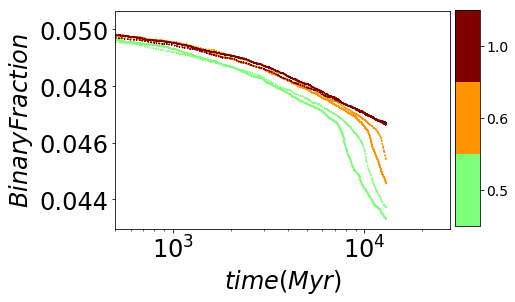

In [8]:
##Compare binary fraction of tidal capture model and standard model
#cb = cm.Blues(np.linspace(0.5, 1, 12))
#cmapb=matplotlib.colors.ListedColormap([cb[0], cb[2], cb[4], cb[6], cb[8], cb[10]])
#cr = cm.Reds(np.linspace(0.5, 1, 12))
#cmapr=matplotlib.colors.ListedColormap([cr[0], cr[2], cr[4], cr[6], cr[8], cr[10]])

cs = cm.jet(np.linspace(0.5, 1, 3))
cmap=matplotlib.colors.ListedColormap([cs[0], cs[1], cs[2]])

bin_tc = []; bin_comp = []

fig, ax=plt.subplots()
#plt.figure()
for jj in range(len(paths_tcon)):
    bin_tc=np.genfromtxt(paths_tcon[jj]+'initial.bin.dat')
    bin_comp=np.genfromtxt(paths_comp[jj]+'initial.bin.dat')
    N_tc = dyn_tc[jj][:,3]; t_tc = dyn_tc[jj][:,0]; Nb_tc = bin_tc[:,1]
    N_comp = dyn_comp[jj][:,3]; t_comp = dyn_comp[jj][:,0]; Nb_comp = bin_comp[:,1]

    conv_tc = dyn.conv('t', paths_tcon[jj]+'initial.conv.sh')
    conv_comp = dyn.conv('t', paths_comp[jj]+'initial.conv.sh')

    tmyr_tc = conv_tc*np.array(t_tc)
    tmyr_comp = conv_comp*np.array(t_comp)
    binfrac_tc = np.array(Nb_tc)/np.array(N_tc)
    binfrac_comp = np.array(Nb_comp)/np.array(N_comp)

    #ax.plot(tmyr_tc, binfrac_tc, color = cr[jj])
    #ax.plot(tmyr_comp, binfrac_comp, ls = ':', color = cb[jj])
    
    ax.plot(tmyr_tc, binfrac_tc, color = cs[jj])
    ax.plot(tmyr_comp, binfrac_comp, ls = ':', color = cs[jj])
        
#addColorbar(ax, cmapb, 0, 12, label=None, tick_tuple=([1.,3.,5.,7.,9.,11.],[0.5,0.6,0.8,1.0,2.0,5.0]))
#addColorbar(ax, cmapr, 0, 12, label=None, tick_tuple=([1.,3.,5.,7.,9.,11.],[0.5,0.6,0.8,1.0,2.0,5.0]))
addColorbar(ax, cmap, 0, 6, label=None, tick_tuple=([1.,3.,5.],[0.5,0.6,1.0]))

ax.set_xlabel(r'$time(Myr)$')
ax.set_ylabel(r'$Binary Fraction$')
ax.set_xscale('log')
ax.set_xlim(xmin = 500)

#plt.legend(loc='best', fontsize=12)

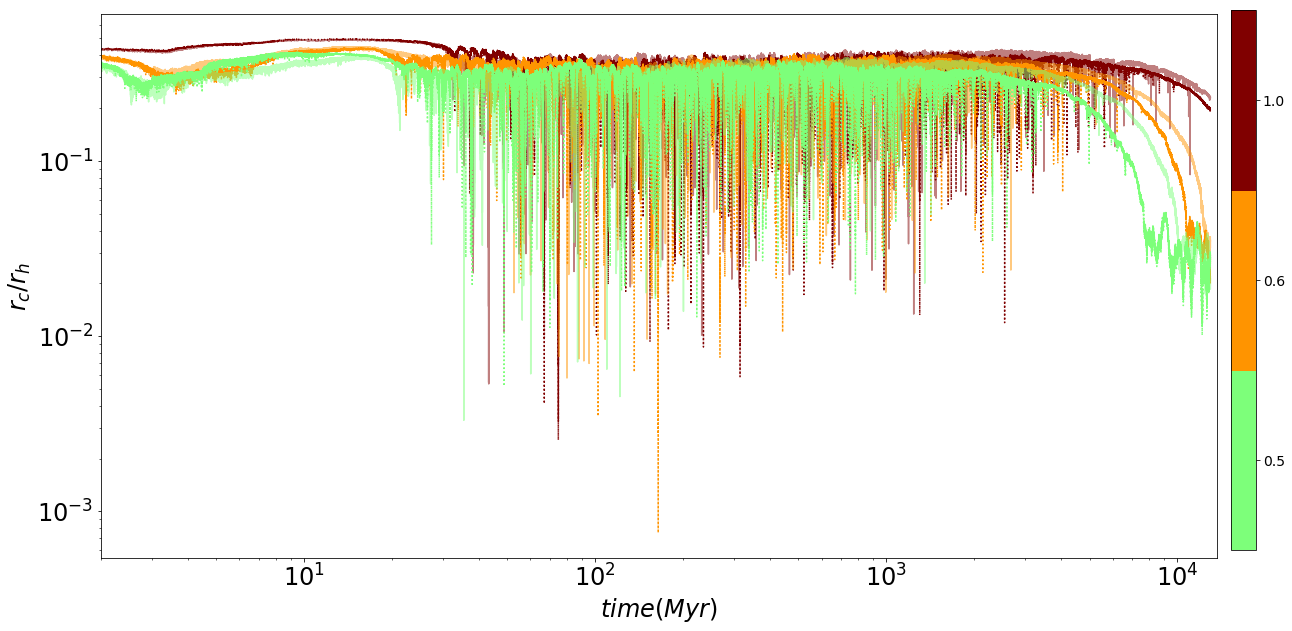

In [23]:
##Compare rc/rh of tidal capture model and standard model
#cb = cm.Blues(np.linspace(0.5, 1, 6))
#cmapb=matplotlib.colors.ListedColormap([cb[0], cb[1], cb[2], cb[3], cb[4], cb[5]])
#cr = cm.Reds(np.linspace(0.5, 1, 6))
#cmapr=matplotlib.colors.ListedColormap([cr[0], cr[1], cr[2], cr[3], cr[4], cr[5]])

cs = cm.jet(np.linspace(0.5, 1, 3))
cmap=matplotlib.colors.ListedColormap([cs[0], cs[1], cs[2]])

fig, ax=plt.subplots(figsize=(20, 10))
for jj in range(len(paths_tcon)-1, -1, -1): #len(paths_tcon)-1
    conv_tc = dyn.conv('t', paths_tcon[jj]+'initial.conv.sh')
    conv_comp = dyn.conv('t', paths_comp[jj]+'initial.conv.sh')
    
    rc_tc = dyn_tc[jj][:,7]; rh_tc = dyn_tc[jj][:,20]; t_tc = dyn_tc[jj][:,0]
    rc_comp = dyn_comp[jj][:,7]; rh_comp = dyn_comp[jj][:,20]; t_comp = dyn_comp[jj][:,0]

    tmyr_tc = conv_tc*np.array(t_tc)
    tmyr_comp = conv_comp*np.array(t_comp)
    r_ratio_tc = np.array(rc_tc)/np.array(rh_tc)
    r_ratio_comp = np.array(rc_comp)/np.array(rh_comp)

    #ax.plot(tmyr_comp, r_ratio_comp, color = cb[jj])
    #ax.plot(tmyr_tc, r_ratio_tc, color = cr[jj])
    
    ax.plot(tmyr_comp, r_ratio_comp, color = cs[jj], alpha=0.5)
    ax.plot(tmyr_tc, r_ratio_tc, ls = 'dotted', color = cs[jj])
    
    
#addColorbar(ax, cmapr, 0, 12, label=None, tick_tuple=([1.,3.,5.,7.,9.,11.],[0.5,0.6,0.8,1.0,2.0,5.0]))
addColorbar(ax, cmap, 0, 6, label=None, tick_tuple=([1.,3.,5.],[0.5,0.6,1.0]))

ax.set_xlabel(r'$time(Myr)$')
ax.set_ylabel(r'$r_c/r_h$')
ax.set_xlim(xmin = 2)
ax.set_yscale('log')
ax.set_xscale('log')

#plt.legend(loc='best', fontsize=12)

484844.0 484844.0
484844.0 484844.0
484844.0 484844.0


Text(0,0.5,'$M_{tot}(M_{\\odot})$')

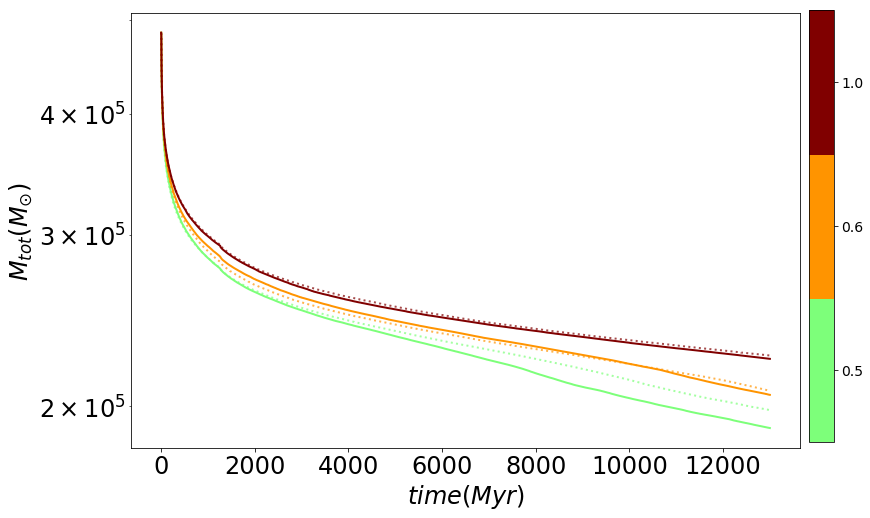

In [25]:
##Compare the mass evolution of the two models
#cb = cm.Blues(np.linspace(0.5, 1, 6))
#cmapb=matplotlib.colors.ListedColormap([cb[0], cb[1], cb[2], cb[3], cb[4], cb[5]])
#cr = cm.Reds(np.linspace(0.5, 1, 6))
#cmapr=matplotlib.colors.ListedColormap([cr[0], cr[1], cr[2], cr[3], cr[4], cr[5]])

cs = cm.jet(np.linspace(0.5, 1, 3))
cmap=matplotlib.colors.ListedColormap([cs[0], cs[1], cs[2]])

fig, ax=plt.subplots(figsize=(12, 8))
for jj in range(len(paths_tcon)):
    m_tc = dyn_tc[jj][:,4]; t_tc = dyn_tc[jj][:,0]
    m_comp = dyn_comp[jj][:,4]; t_comp = dyn_comp[jj][:,0]

    tconv_tc = dyn.conv('t', paths_tcon[jj]+'initial.conv.sh')
    tconv_comp = dyn.conv('t', paths_comp[jj]+'initial.conv.sh')
    mconv_tc = dyn.conv('m', paths_tcon[jj]+'initial.conv.sh')
    mconv_comp = dyn.conv('m', paths_comp[jj]+'initial.conv.sh')
    print(mconv_tc, mconv_comp)

    tmyr_tc = tconv_tc*np.array(t_tc)
    tmyr_comp = tconv_comp*np.array(t_comp)
    msun_tc = mconv_tc*np.array(m_tc)
    msun_comp = mconv_comp*np.array(m_comp)

    #ax.plot(tmyr_tc, msun_tc, lw = 2, color = cr[jj])
    #ax.plot(tmyr_comp, msun_comp, lw = 2, color = cb[jj])
    
    ax.plot(tmyr_tc, msun_tc, lw = 2, color = cs[jj])
    ax.plot(tmyr_comp, msun_comp, lw = 2, ls = 'dotted', color = cs[jj], alpha=0.7)

#addColorbar(ax, cmapr, 0, 12, label=None, tick_tuple=([1.,3.,5.,7.,9.,11.],[0.5,0.6,0.8,1.0,2.0,5.0]))
addColorbar(ax, cmap, 0, 6, label=None, tick_tuple=([1.,3.,5.],[0.5,0.6,1.0]))

ax.set_yscale('log')
#ax.set_xscale('log')

ax.set_xlabel(r'$time(Myr)$')
ax.set_ylabel(r'$M_{tot}(M_{\odot})$')
#ax.set_legend(loc='best', fontsize=12)

/software/anaconda3.6/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


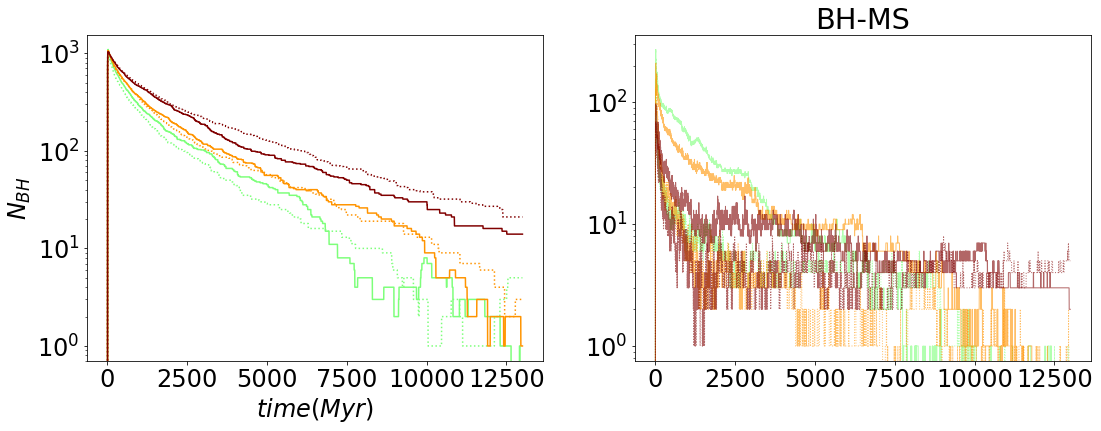

In [31]:
##Comapre number of BH
#cb = cm.Blues(np.linspace(0.5, 1, 6))
#cmapb=matplotlib.colors.ListedColormap([cb[0], cb[1], cb[2], cb[3], cb[4], cb[5]])
#cr = cm.Reds(np.linspace(0.5, 1, 6))
#cmapr=matplotlib.colors.ListedColormap([cr[0], cr[1], cr[2], cr[3], cr[4], cr[5]])

cs = cm.jet(np.linspace(0.5, 1, 3))
cmap=matplotlib.colors.ListedColormap([cs[0], cs[1], cs[2]])

fig, axs = plt.subplots(ncols = 2, figsize = (18, 6))
for jj in range(len(paths_tcon)):
    t_tc = bh_tc[jj][:,1]; Nbh_tc = bh_tc[jj][:,2]
    Nbhms_tc = bh_tc[jj][:,10]; Nbhwd_tc = bh_tc[jj][:,8]
    
    t_comp = bh_comp[jj][:,1]; Nbh_comp = bh_comp[jj][:,2]
    Nbhms_comp = bh_comp[jj][:,10]; Nbhwd_comp = bh_comp[jj][:,8]
    
    conv_tc = dyn.conv('t', paths_tcon[jj]+'initial.conv.sh')
    conv_comp = dyn.conv('t', paths_comp[jj]+'initial.conv.sh')
    
    tmyr_tc = conv_tc*np.array(t_tc)
    tmyr_comp = conv_comp*np.array(t_comp)
    

    #axs[0].plot(tmyr_tc, Nbh_tc, color = cr[jj])
    #axs[0].plot(tmyr_comp, Nbh_comp, color = cb[jj])
    #
    #axs[1].plot(tmyr_tc, Nbhms_tc, color = cr[jj], lw=1, alpha=0.6)
    #axs[1].plot(tmyr_comp, Nbhms_comp, color = cb[jj], lw=1, alpha=0.6)
    
    #axs[2].plot(tmyr_tc, Nbhwd_tc, color = cr[jj], lw=1, alpha=0.6)
    #axs[2].plot(tmyr_comp, Nbhwd_comp, color = cb[jj], lw=1, alpha=0.6)
    
    axs[0].plot(tmyr_tc, Nbh_tc, color = cs[jj])
    axs[0].plot(tmyr_comp, Nbh_comp, color = cs[jj], ls = 'dotted')
    
    axs[1].plot(tmyr_tc, Nbhms_tc, color = cs[jj], lw=1, alpha=0.6)
    axs[1].plot(tmyr_comp, Nbhms_comp, color = cs[jj], lw=1, ls = 'dotted', alpha=0.6)

#addColorbar(axs[1], cmapr, 0, 12, label=None, tick_tuple=([1.,3.,5.,7.,9.,11.],[0.5,0.6,0.8,1.0,2.0,5.0]))
addColorbar(ax, cmap, 0, 6, label=None, tick_tuple=([1.,3.,5.],[0.5,0.6,1.0]))
    
axs[0].set_xlabel(r'$time(Myr)$')
axs[0].set_ylabel(r'$N_{BH}$')
axs[1].set_title('BH-MS')
axs[0].set_yscale('log')
axs[1].set_yscale('log')
#axs[0].set_xscale('log')
#axs[1].set_xscale('log')
#axs[0].set_xlim(xmin = 1)
#axs[1].set_xlim(xmin = 1)

#axs[2].set_title('BH-WD')
#axs[0].legend(loc='best', fontsize = 12)    
#axs[1].legend(loc='best', fontsize = 12)
#axs[1].set_yscale('symlog')
#axs[1].set_ylim(-1, 30)


Text(0.5,0,'$time(Myr)$')

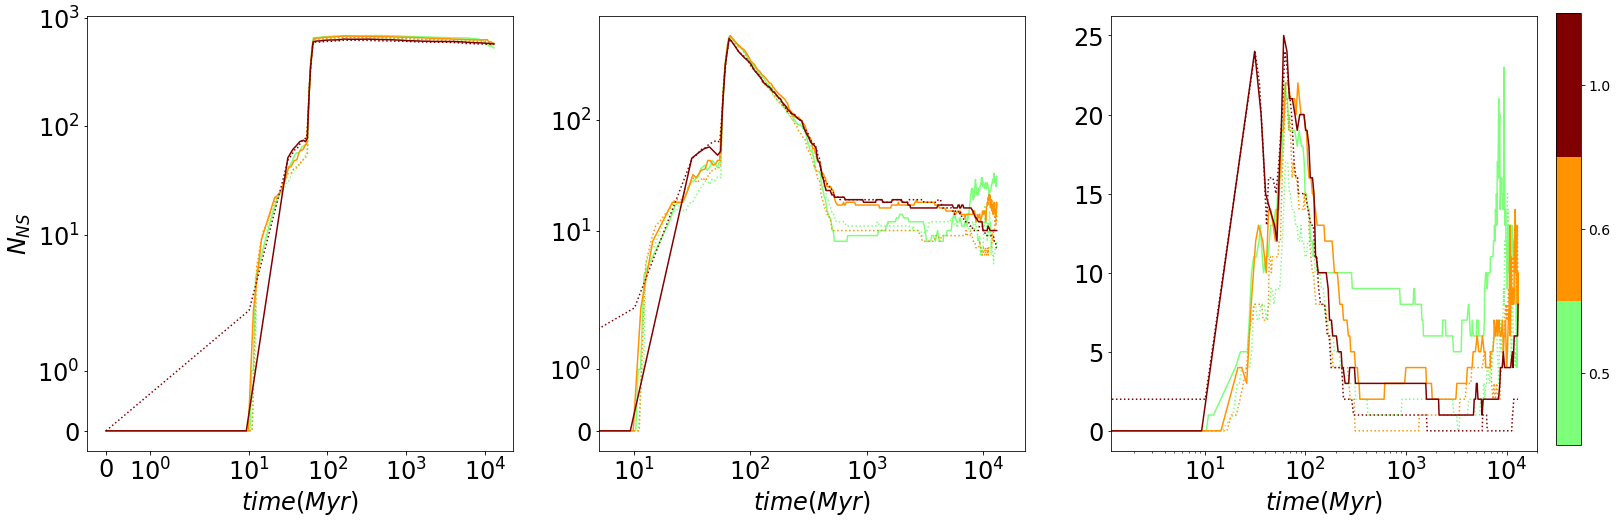

In [6]:
##Compare the number of pulsars and neutron star binaries in general in the two models
#cb = cm.Blues(np.linspace(0.5, 1, 6))
#cmapb=matplotlib.colors.ListedColormap([cb[0], cb[1], cb[2], cb[3], cb[4], cb[5]])
#cr = cm.Reds(np.linspace(0.5, 1, 6))
#cmapr=matplotlib.colors.ListedColormap([cr[0], cr[1], cr[2], cr[3], cr[4], cr[5]])
#cs = ['r', 'b']

cs = cm.jet(np.linspace(0.5, 1, 3))
cmap=matplotlib.colors.ListedColormap([cs[0], cs[1], cs[2]])

fig, axs = plt.subplots(ncols = 3, figsize = (26, 8))
for jj in range(len(paths_tcon)):
    t_tc = ns_tc[jj][:,0]; Nns_tc = ns_tc[jj][:,1]
    Nnsms_tc = ns_tc[jj][:,10]; Nnswd_tc = ns_tc[jj][:,9]
    Npsr_tc = ns_tc[jj][:,5]; Nmsp_tc = ns_tc[jj][:,6]

    t_comp = ns_comp[jj][:,0]; Nns_comp = ns_comp[jj][:,1]
    Nnsms_comp = ns_comp[jj][:,10]; Nnswd_comp = ns_comp[jj][:,9]
    Npsr_comp = ns_comp[jj][:,5]; Nmsp_comp = ns_comp[jj][:,6]

    conv_tc = dyn.conv('t', paths_tcon[jj]+'initial.conv.sh')
    conv_comp = dyn.conv('t', paths_comp[jj]+'initial.conv.sh')

    tmyr_tc = conv_tc*np.array(t_tc)
    tmyr_comp = conv_comp*np.array(t_comp)

#fig, axs = plt.subplots(ncols = 3, figsize = (22, 6))
    #axs[0].plot(tmyr_tc, Nns_tc, color = cr[jj])
    #axs[0].plot(tmyr_comp, Nns_comp, color=cb[jj])

    #axs[1].plot(tmyr_tc, Npsr_tc, color = cr[jj])
    #axs[1].plot(tmyr_comp, Npsr_comp, color = cb[jj])
    #axs[1].plot(tmyr_tc, Nmsp_tc, color = cr[jj])
    #axs[1].plot(tmyr_comp, Nmsp_comp, color = cb[jj])

    #axs[2].plot(tmyr_tc, Nnsms_tc, color = cr[jj])
    #axs[2].plot(tmyr_comp, Nnsms_comp, color = cb[jj])
    #axs[2].plot(tmyr_tc, Nnswd_tc, color = cr[jj])
    #axs[2].plot(tmyr_comp, Nnswd_comp, color = cb[jj])
    
    axs[0].plot(tmyr_comp, Nns_comp, color=cs[jj], ls = 'dotted')
    axs[0].plot(tmyr_tc, Nns_tc, color = cs[jj])

    axs[1].plot(tmyr_tc, Npsr_tc, color = cs[jj])
    axs[1].plot(tmyr_comp, Npsr_comp, color = cs[jj], ls = 'dotted')

    axs[2].plot(tmyr_tc, Nnsms_tc, color = cs[jj])
    axs[2].plot(tmyr_comp, Nnsms_comp, color = cs[jj], ls = 'dotted')
    
#addColorbar(axs[1], cmapr, 0, 12, label=None, tick_tuple=([1.,3.,5.,7.,9.,11.],[0.5,0.6,0.8,1.0,2.0,5.0]))
addColorbar(axs[2], cmap, 0, 6, label=None, tick_tuple=([1.,3.,5.],[0.5,0.6,1.0]))

#axs[0].legend(loc='best', fontsize = 12)
axs[0].set_xscale('symlog')
axs[0].set_yscale('symlog')
axs[0].set_xlabel(r'$time(Myr)$')
axs[0].set_ylabel(r'$N_{NS}$')

axs[1].set_xscale('symlog')
axs[1].set_yscale('symlog')
axs[1].set_xlim(xmin = 5)
axs[1].set_xlabel(r'$time(Myr)$')
#axs[1].set_ylabel(r'$$')
#axs[1].legend(loc='best', fontsize = 12)

axs[2].set_xscale('log')
axs[2].set_xlabel(r'$time(Myr)$')
#axs[2].set_ylabel(r'$NS\ binaries$')
#axs[2].legend(loc='center right', fontsize = 12)

##Check why there are more NSs and pulsars and NS binaries in the tidal capture model
##How many MSPs in the NS-MS and NS-WD binaries

Text(0,0.5,'number')

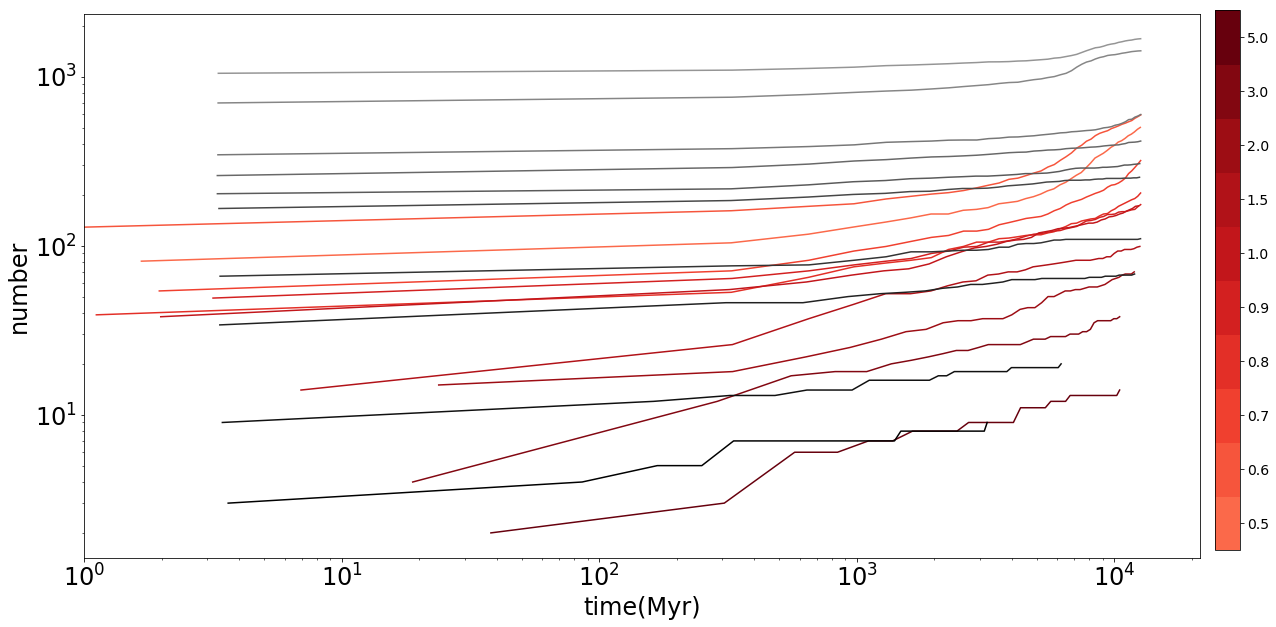

In [4]:
##Plot the cumulative number of TCs and giant collisions vesus time
cg = cm.Greys(np.linspace(0.5, 1, 10))
cmapg=matplotlib.colors.ListedColormap([cg[0], cg[1], cg[2], cg[3], cg[4], cg[5], cg[6], cg[7], cg[8], cg[9]])
cr = cm.Reds(np.linspace(0.5, 1, 10))
cmapr=matplotlib.colors.ListedColormap([cr[0], cr[1], cr[2], cr[3], cr[4], cr[5], cr[6], cr[7], cr[8], cr[9]])
cs = ['r', 'b']

#tctime_init_index, tctime_finl_index, tctime_des_emp = extract_key_index('time', index_tc_bin, 'bin')
#colltime_init_index, colltime_finl_index, colltime_des_emp = extract_key_index('time', index_coll_bin, 'bin')
#colltime_init_emp, colltime_finl_emp, colltime_des_index = extract_key_index('time', index_coll_des, 'des')

fig, ax=plt.subplots(figsize=(20, 10))
for kk in range(len(paths)):
    tconv = dyn.conv('t', paths[kk]+'initial.conv.sh')
    tc_bin_time_temp = list(np.take(prop_init[str(kk)]['time'], index_tc_bin[kk])*tconv)
    tc_des_time_temp = list(np.take(prop_des[str(kk)]['time'], index_tc_des[kk])*tconv)
    coll_bin_time_temp = list(np.take(prop_init[str(kk)]['time'], index_coll_bin[kk])*tconv)
    coll_des_time_temp = list(np.take(prop_des[str(kk)]['time'], index_coll_des[kk])*tconv)

    times_tc = tc_bin_time_temp
    times_coll = coll_bin_time_temp+coll_des_time_temp
    
    # evaluate the histogram
    values_tc, base_tc = np.histogram(times_tc, bins=40)
    values_coll, base_coll = np.histogram(times_coll, bins=40)
    #evaluate the cumulative
    cumulative_tc = np.cumsum(values_tc)
    cumulative_coll = np.cumsum(values_coll)
    # plot the cumulative function
    ax.plot(base_tc[:-1], cumulative_tc, c=cr[kk])
    ax.plot(base_coll[:-1], cumulative_coll, c=cg[kk])

addColorbar(ax, cmapr, 0, 20, label=None, tick_tuple=([1.,3.,5.,7.,9.,11.,13.,15.,17.,19.],[0.5,0.6,0.7,0.8,0.9,1.0,1.5,2.0,3.0,5.0]))
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlim(xmin=1)
ax.set_xlabel('time(Myr)')
ax.set_ylabel('number')
    

[41 15  3  2  5  3  1  0  1  1  0  1  0  0  0  0  0  0  0  1  0  0  2  0
  0  1  0  0  1  1] [5.01776011e+00 2.23834278e+02 4.42650796e+02 6.61467314e+02
 8.80283832e+02 1.09910035e+03 1.31791687e+03 1.53673339e+03
 1.75554990e+03 1.97436642e+03 2.19318294e+03 2.41199946e+03
 2.63081598e+03 2.84963249e+03 3.06844901e+03 3.28726553e+03
 3.50608205e+03 3.72489857e+03 3.94371508e+03 4.16253160e+03
 4.38134812e+03 4.60016464e+03 4.81898116e+03 5.03779767e+03
 5.25661419e+03 5.47543071e+03 5.69424723e+03 5.91306375e+03
 6.13188026e+03 6.35069678e+03 6.56951330e+03]
[49 28 10  3  3  1  2  3  1  0  2  0  0  0  0  0  1  0  0  1  0  0  0  0
  0  0  0  1  0  1] [6.09691278e+00 2.11842505e+02 4.17588097e+02 6.23333690e+02
 8.29079282e+02 1.03482487e+03 1.24057047e+03 1.44631606e+03
 1.65206165e+03 1.85780724e+03 2.06355284e+03 2.26929843e+03
 2.47504402e+03 2.68078961e+03 2.88653521e+03 3.09228080e+03
 3.29802639e+03 3.50377198e+03 3.70951757e+03 3.91526317e+03
 4.12100876e+03 4.32675435e+03 4.53

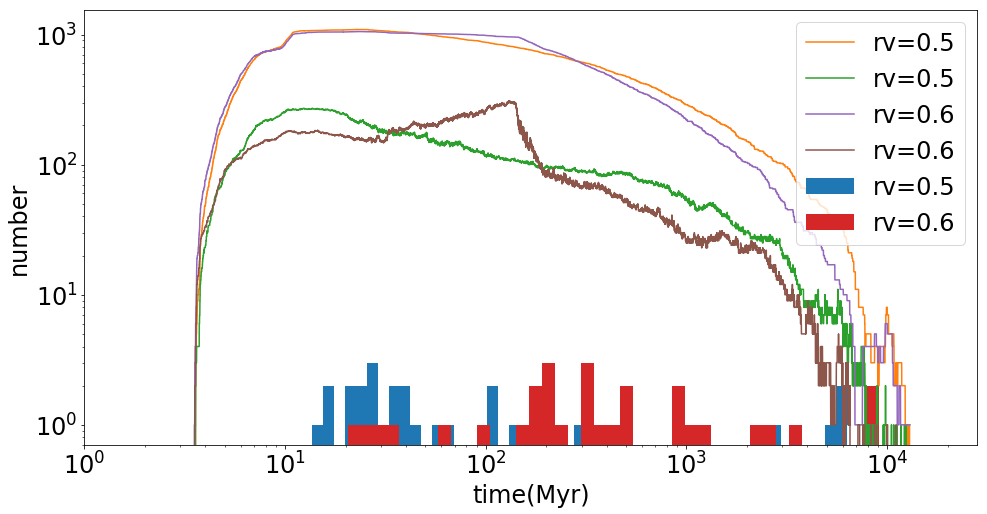

In [8]:
##Plot the number of BHs vs. tidal capture time

#tctime_init_index, tctime_finl_index, tctime_des_emp = extract_key_index('time', index_tc_bin, 'bin')
#colltime_init_index, colltime_finl_index, colltime_des_emp = extract_key_index('time', index_coll_bin, 'bin')
#colltime_init_emp, colltime_finl_emp, colltime_des_index = extract_key_index('time', index_coll_des, 'des')

names = ['rv=0.5', 'rv=0.6']

fig, ax=plt.subplots(figsize=(16, 8))
for kk in range(len(paths)):
    if kk == 0 or kk == 1:# or kk == 3 or kk == 5:
        tconv = dyn.conv('t', paths[kk]+'initial.conv.sh')
        tc_bin_time_temp = list(np.take(prop_init[str(kk)]['time'], index_tc_bin[kk])*tconv)
        tc_des_time_temp = list(np.take(prop_des[str(kk)]['time'], index_tc_des[kk])*tconv)
        coll_bin_time_temp = list(np.take(prop_init[str(kk)]['time'], index_coll_bin[kk])*tconv)
        coll_des_time_temp = list(np.take(prop_des[str(kk)]['time'], index_coll_des[kk])*tconv)
    
        tc_bin_k0_temp = list(np.take(prop_init[str(kk)]['k0'], index_tc_bin[kk]))
        tc_des_k0_temp = list(np.take(prop_des[str(kk)]['k0'], index_tc_des[kk]))
        coll_bin_k0_temp = list(np.take(prop_init[str(kk)]['k0'], index_coll_bin[kk]))
        coll_des_k0_temp = list(np.take(prop_des[str(kk)]['k0'], index_coll_des[kk]))
    
        tc_bin_k1_temp = list(np.take(prop_init[str(kk)]['k1'], index_tc_bin[kk]))
        tc_des_k1_temp = list(np.take(prop_des[str(kk)]['k1'], index_tc_des[kk]))
        coll_bin_k1_temp = list(np.take(prop_init[str(kk)]['k1'], index_coll_bin[kk]))
        coll_des_k1_temp = list(np.take(prop_des[str(kk)]['k1'], index_coll_des[kk]))
    
        times_tc_bin = []; times_tc_des = []
        times_coll_bin = []; times_coll_des = []
        for xa in range(len(tc_bin_k0_temp)):
            if tc_bin_k0_temp[xa]==14 or tc_bin_k1_temp[xa]==14:
                times_tc_bin.append(tc_bin_time_temp[xa])
    
        for xb in range(len(tc_des_k0_temp)):
            if tc_des_k0_temp[xb]==14 or tc_des_k1_temp[xb]==14:
                times_tc_des.append(tc_des_time_temp[xb])
    
        for xc in range(len(coll_bin_k0_temp)):
            if coll_bin_k0_temp[xc]==14 or coll_bin_k1_temp[xc]==14:
                times_coll_bin.append(coll_bin_time_temp[xc])   
    
        for xd in range(len(coll_des_k0_temp)):
            if coll_des_k0_temp[xd]==14 or coll_des_k1_temp[xd]==14:
                times_coll_des.append(coll_des_time_temp[xd])
    
        databh = np.genfromtxt(paths[kk]+'initial.bh.dat')
        Tbh = np.array(databh[:,1])*tconv; Nbh_tot = databh[:,2]; Nbhms = databh[:,10]
        
    
        # evaluate the histogram
        values_tc_bin, base_tc_bin = np.histogram(times_tc_bin, 30)
        values_tc_des, base_tc_des = np.histogram(times_tc_des, 30)
        values_coll_bin, base_coll_bin = np.histogram(times_coll_bin, 30)
        print(values_tc_bin, base_tc_bin)
        #values_coll_des, base_coll_des = np.histogram(times_coll_des, bins=np.logspace(np.log10(min(times_coll_des)), np.log10(max(times_coll_des)), 30))

        #ax.hist(times_tc_des, bins=np.logspace(np.log10(min(times_tc_des)), np.log10(max(times_tc_des)), 30), alpha=0.6, histtype = 'step', lw=3)
        #ax.hist(times_tc_bin, bins=np.logspace(np.log10(min(times_tc_bin)), np.log10(max(times_tc_bin)), 50), alpha=0.6, label = names[kk])
        ax.hist(times_coll_bin, bins=np.logspace(np.log10(min(times_coll_bin)), np.log10(max(times_coll_bin)), 50), label = names[kk])
        #ax.hist(times_tc_bin, bins=30, alpha=0.6, label = names[kk])
        #ax.hist(times_coll_bin, bins=30, alpha=0.6, label = names[kk], histtype='step')
        ax.plot(Tbh, Nbh_tot, label = names[kk])
        ax.plot(Tbh, Nbhms, label = names[kk])

#addColorbar(ax, cmapr, 0, 20, label=None, tick_tuple=([1.,3.,5.,7.,9.,11.,13.,15.,17.,19.],[0.5,0.6,0.7,0.8,0.9,1.0,1.5,2.0,3.0,5.0]))
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlim(xmin=1)
ax.set_xlabel('time(Myr)')
ax.set_ylabel('number')
ax.legend(loc = 'upper right')
    

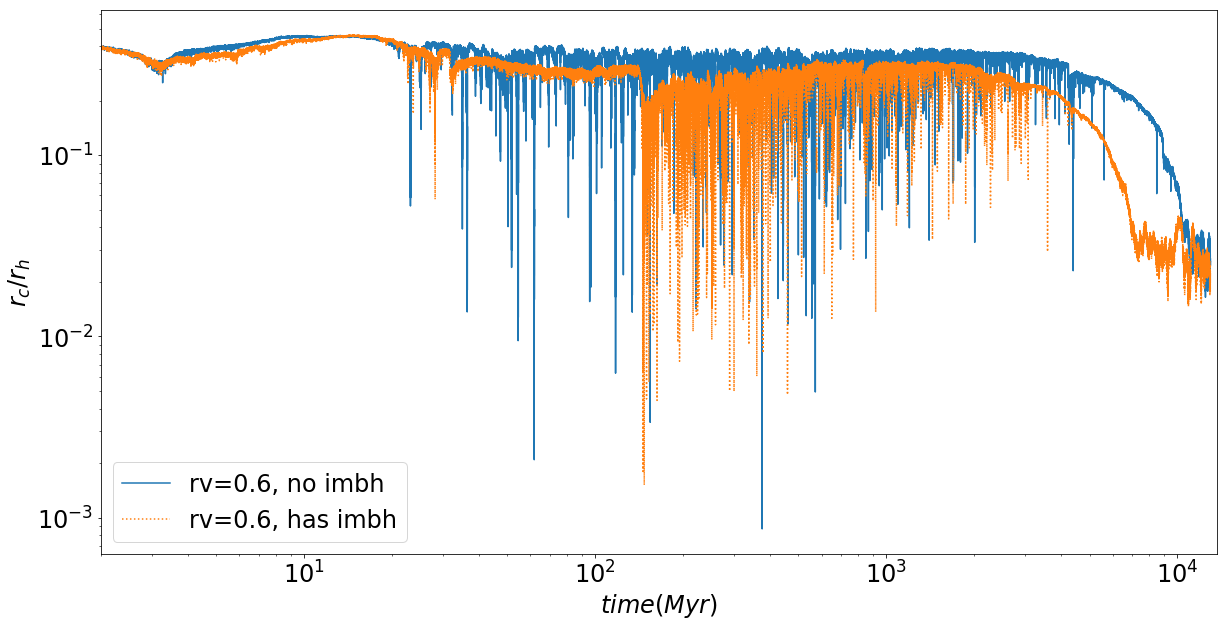

In [2]:
##Compare rc/rh of two models
path_imbh = '/projects/b1095/syr904/cmc/cmc-mpi-tidalcapture/rvgrid/standard_models_tcon/mpi1/8e5_rvgrid_0.6_mpi1_rerun/'
path_noimbh = '/projects/b1095/syr904/cmc/cmc-mpi-tidalcapture/rvgrid/standard_models_tcon/mpi1/8e5_rvgrid_0.6_mpi1_rererun/'

dyn_imbh = np.genfromtxt(path_imbh+'initial.dyn.dat')
dyn_noimbh = np.genfromtxt(path_noimbh+'initial.dyn.dat')


fig, ax=plt.subplots(figsize=(20, 10))
conv_imbh = dyn.conv('t', path_imbh+'initial.conv.sh')
conv_noimbh = dyn.conv('t', path_noimbh+'initial.conv.sh')
    
rc_imbh = dyn_imbh[:,7]; rh_imbh = dyn_imbh[:,20]; t_imbh = dyn_imbh[:,0]
rc_noimbh = dyn_noimbh[:,7]; rh_noimbh = dyn_noimbh[:,20]; t_noimbh = dyn_noimbh[:,0]

tmyr_imbh = conv_imbh*np.array(t_imbh)
tmyr_noimbh = conv_noimbh*np.array(t_noimbh)
r_ratio_imbh = np.array(rc_imbh)/np.array(rh_imbh)
r_ratio_noimbh = np.array(rc_noimbh)/np.array(rh_noimbh)


ax.plot(tmyr_noimbh, r_ratio_noimbh, label = 'rv=0.6, no imbh')
ax.plot(tmyr_imbh, r_ratio_imbh, ls = 'dotted', label = 'rv=0.6, has imbh')


ax.set_xlabel(r'$time(Myr)$')
ax.set_ylabel(r'$r_c/r_h$')
ax.set_xlim(xmin = 2)
ax.set_yscale('log')
ax.set_xscale('log')
ax.legend(loc = 'best')

#plt.legend(loc='best', fontsize=12)

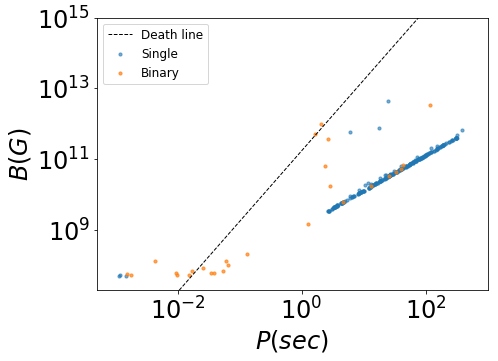

In [45]:
##Check the B-P plot
snaps_tc = dyn.get_snapshots(testpath+'initial')
lastsnap_tc = snaps_tc[-1]
B_s, B_b, P_s, P_b = ns.get_snap_BP(lastsnap_tc)

x=np.logspace(-4.0, 2.0, num=50)

plt.figure(figsize = (7, 5))
plt.plot(x, (x**2)*(0.17*10**12), 'k--', lw = 1, label = 'Death line')
plt.scatter(P_s, B_s, s=10, label = 'Single', alpha = 0.6)
plt.scatter(P_b, B_b, s=10, label = 'Binary', alpha = 0.7)

plt.xlim(0.5*10**-3, 1000.)
plt.ylim(2*10**7, 10**15)

plt.yscale('log')
plt.xscale('log')

plt.xlabel(r'$P(sec)$')
plt.ylabel(r'$B(G)$')

plt.legend(loc='best', fontsize=12)

##What's the straightline that all the pulsars stop at?

In [8]:
##Compare model pulsars Mc_Period with observed ones.

###Get model data
datamsp=np.genfromtxt('/projects/b1095/syr904/cmc/cmc-mpi-tidalcapture/rvgrid/standard_models_tcon/msp_last_rvgrid_tcon.dat')
datapsr=np.genfromtxt('/projects/b1095/syr904/cmc/cmc-mpi-tidalcapture/rvgrid/standard_models_tcon/normalpsr_last_rvgrid_tcon.dat')
m0_msp=datamsp[:,10]; m1_msp=datamsp[:,11]; sma_msp=datamsp[:,16]; ecc_msp=datamsp[:,17]
k0_msp=datamsp[:,14]; k1_msp=datamsp[:,15]; B_msp=datamsp[:,4]; P_msp=datamsp[:,5]
m0_psr=datapsr[:,10]; m1_psr=datapsr[:,11]; sma_psr=datapsr[:,16]; ecc_psr=datapsr[:,17]
k0_psr=datapsr[:,14]; k1_psr=datapsr[:,15]; B_psr=datapsr[:,4]; P_psr=datapsr[:,5]

Pdot_psr=Kconst*yearsc*B_psr*B_psr/P_psr
Pdot_msp=Kconst*yearsc*B_msp*B_msp/P_msp
Pdot_msp=Pdot_msp *10**19*1000; Pdot_psr=Pdot_psr*10**19*1000
print(P_psr)
P_msp = P_msp*1000; P_psr = P_psr*1000
print(P_psr)

###Get observed data
P, Pdot, Binflag, Namespin, Period, Ecc, Mc, Names, Pall, Bfall, Nameall = pc.readdata_freire()
print(len(Pall), len(Bfall))
print(Ecc)
datarb=np.genfromtxt('/projects/b1095/syr904/projects/PULSAR/GCredback.dat', dtype=str)
databw=np.genfromtxt('/projects/b1095/syr904/projects/PULSAR/GCblackwidow.dat', dtype=str)
namerb=datarb[:,0]; namebw=databw[:,0]


###Plotting
plt.rcParams['figure.figsize'] = [8,24]
rdot=mlines.Line2D([], [],  linestyle = 'None', color='r', marker='o',
                  markersize=7, label='Redbacks')
kdot=mlines.Line2D([], [],  linestyle = 'None', color='k', marker='o',
                  markersize=7, label='Black widows')
bdot=mlines.Line2D([], [],  linestyle = 'None', color='b', marker='o',
                  markersize=7, label='Others')
gtri=mlines.Line2D([], [],  linestyle = 'None', color='g', marker='^',
                  markersize=7, label='Others')

fig, axs = plt.subplots(nrows=3, sharey=False)
fig.subplots_adjust(wspace=0.05)

for jj in range(len(k0_psr)):
    if k1_psr[jj]!=-100:
        pb_psr = uc.au_to_period(sma_psr[jj], m0_psr[jj], m1_psr[jj])
        if 0<=k1_psr[jj]<=1:
            axs[0].scatter(m1_psr[jj], pb_psr, color='red', marker = 'd', lw = 1, facecolors='none')
            axs[1].scatter(ecc_psr[jj], pb_psr,  color='red', marker = 'd', lw = 1, facecolors='none')
            axs[2].scatter(P_psr[jj], Pdot_psr[jj], marker='>', color='red', lw = 1, facecolors='none')
        elif k1_psr[jj]==10:
            axs[0].scatter(m1_psr[jj], pb_psr, color='gold', marker = 'd', lw = 1, facecolors='none')
            axs[1].scatter(ecc_psr[jj], pb_psr,  color='gold', marker = 'd', lw = 1, facecolors='none')
            axs[2].scatter(P_psr[jj], Pdot_psr[jj], marker='>', color='gold', lw = 1, facecolors='none')
        elif k1_psr[jj]>=11 and m1_psr[jj]<0.1:
            axs[0].scatter(m1_psr[jj], pb_psr, color='k', marker = 'd', lw = 1, facecolors='none')
            axs[1].scatter(ecc_psr[jj], pb_psr,  color='k', marker = 'd', lw = 1, facecolors='none')
            axs[2].scatter(P_psr[jj], Pdot_psr[jj], marker='>', color='k', lw = 1, facecolors='none')
        elif k1_psr[jj]>=11 and m1_psr[jj]>=0.1:
            axs[0].scatter(m1_psr[jj], pb_psr, color='b', marker = 'd', lw = 1, facecolors='none')
            axs[1].scatter(ecc_psr[jj], pb_psr,  color='b', marker = 'd', lw = 1, facecolors='none')
            axs[2].scatter(P_psr[jj], Pdot_psr[jj], marker='>', color='g', lw = 1, facecolors='none')
    else:
        axs[2].scatter(P_psr[jj], Pdot_psr[jj], marker='>', color='g', lw = 1, facecolors='none')
        

for kk in range(len(k0_msp)):
    if k1_msp[kk]!=-100:
        pb_msp = uc.au_to_period(sma_msp[kk], m0_msp[kk], m1_msp[kk])
        if 0<=k1_msp[kk]<=1:
            print(m0_msp[kk], m1_msp[kk])
            axs[0].scatter(m1_msp[kk], pb_msp, color='red', marker = 's', lw = 1, facecolors='none')
            axs[1].scatter(ecc_msp[kk], pb_msp,  color='red', marker = 's', lw = 1, facecolors='none')
            axs[2].scatter(P_msp[kk], Pdot_msp[kk], marker='^', color='red', lw = 1, facecolors='none')
        elif k1_msp[kk]==10:
            axs[0].scatter(m1_msp[kk], pb_msp, color='gold', marker = 's', lw = 1, facecolors='none')
            axs[1].scatter(ecc_msp[kk], pb_msp,  color='gold', marker = 's', lw = 1, facecolors='none')
            axs[2].scatter(P_msp[kk], Pdot_msp[kk], marker='^', color='gold', lw = 1, facecolors='none')
        elif k1_msp[kk]>=11 and m1_msp[kk]<0.1:
            axs[0].scatter(m1_msp[kk], pb_msp, color='k', marker = 's', lw = 1, facecolors='none')
            axs[1].scatter(ecc_msp[kk], pb_msp,  color='k', marker = 's', lw = 1, facecolors='none')
            axs[2].scatter(P_msp[kk], Pdot_msp[kk], marker='^', color='k', lw = 1, facecolors='none')
        elif k1_msp[kk]>=11 and m1_msp[kk]>=0.1:
            axs[0].scatter(m1_msp[kk], pb_msp, color='b', marker = 's', lw = 1, facecolors='none')
            axs[1].scatter(ecc_msp[kk], pb_msp,  color='b', marker = 's', lw = 1, facecolors='none')
            axs[2].scatter(P_msp[kk], Pdot_msp[kk], marker='^', color='g', lw = 1, facecolors='none')
    else:
        axs[2].scatter(P_msp[kk], Pdot_msp[kk], marker='^', color='g', lw = 1, facecolors='none')
        
        

for i in range(len(Mc)):
    if Mc[i][0] != '>':
        if Names[i] in namerb:
            axs[0].scatter(float(Mc[i]), float(Period[i]), color='red', alpha=0.7, zorder=2)
            if Ecc[i][0]!='<' and Ecc[i][0]!='-':
                axs[1].scatter(float(Ecc[i]), float(Period[i]),  color='red', alpha=0.7, zorder=2)
            elif Ecc[i][0]!='-':
                axs[1].errorbar(float(Ecc[i].split('<')[1]), float(Period[i]), xerr=0.02, 
                                xuplims=True,  marker='o', color='red', linestyle='none')
                
            
        elif Names[i] in namebw:
            axs[0].scatter(float(Mc[i]), float(Period[i]), color='k', alpha=0.7, zorder=2)
            if Ecc[i][0]!='<':
                axs[1].scatter(float(Ecc[i]), float(Period[i]), color='k', alpha=0.7, zorder=2)
            else:
                axs[1].errorbar(float(Ecc[i].split('<')[1]), float(Period[i]), xerr=0.02, 
                                xuplims=True,  marker='o', color='k', linestyle='none')
                
            
        else:
            axs[0].scatter(float(Mc[i]), float(Period[i]), color='b', alpha=0.7, zorder=1)
            if Ecc[i][0]!='<':
                axs[1].scatter(float(Ecc[i]), float(Period[i]), color='b', alpha=0.7, zorder=1)
            else:
                #print(Ecc[i])
                axs[1].errorbar(float(Ecc[i].split('<')[1]), float(Period[i]), xerr=0.02, 
                                xuplims=True,  marker='o', color='b', linestyle='none')
                
    
    else:
        axs[0].errorbar(float(Mc[i].split('>')[1]), float(Period[i].split('>')[1]), xerr=0.002, yerr=0.2, lolims=True, 
                        xlolims=True, marker='o', markerfacecolor='none', color='b', linestyle='none')
        axs[1].errorbar(float(Ecc[i].split('>')[1]), float(Period[i].split('>')[1]), xerr=0.02, yerr=0.2, lolims=True, 
                        xlolims=True, marker='o', markerfacecolor='none', color='b', linestyle='none')
        

for j in range(len(P)):
    if Binflag[j]==0:
        axs[2].scatter(float(P[j]), float(Pdot[j])*10**22, marker='^', color='g')
    else:
        if Namespin[j] in namerb:
            axs[2].scatter(float(P[j]), float(Pdot[j])*10**22, marker='o', color='r')
        elif Namespin[j] in namebw:
            axs[2].scatter(float(P[j]), float(Pdot[j])*10**22, marker='o', color='k')
        else:
            axs[2].scatter(float(P[j]), float(Pdot[j])*10**22, marker='^', color='g')
            
            
        
axs[0].set_yscale('log')
axs[0].set_xscale('log')
axs[0].set_ylim(0.01, 3000)
axs[0].set_xlim(0.001, 20)
axs[0].set_xlabel(r'$M_c\ (M_\odot)$')
axs[0].set_ylabel(r'$P_{orb}\ (d)$')
axs[0].legend(handles=[bdot, kdot, rdot], loc='upper left', prop={'size': 12}, numpoints=1, frameon=True)

axs[1].set_yscale('log')
#axs[1].set_xscale('symlog')
axs[1].set_ylim(0.01, 3000)
#axs[1].set_xlim(-0.1, 1)
axs[1].set_ylabel(r'$P_{orb}\ (d)$')
axs[1].set_xlabel(r'$eccentricity$')
#axs[1].set_ylabel(r'$P_{orb}\ (d)$')

axs[2].set_xlim(0.1, 20000)
axs[2].set_yscale('symlog')
axs[2].set_xscale('log')
axs[2].legend(handles=[gtri, kdot, rdot], loc='center right', prop={'size': 12}, numpoints=1, frameon=True)
axs[2].set_xlabel(r'$P\,(ms)$')
axs[2].set_ylabel(r'$\dot{P}\,(\times 10^{-22})$')
axs[2].locator_params(numticks=8)
yticks =plt.gca().yaxis.get_major_ticks()
yticks[4].set_visible(False)

OSError: /projects/b1095/syr904/cmc/cmc-mpi-tidalcapture/rvgrid/standard_models_tcon/msp_last_rvgrid_tcon.dat not found.

223
223 223
['0.00031', '0.07056', '<0.0004', '<0.00004', '<0.00016', '0.0', '0.00008', '0.0', '0.00039', '0.00040', '0.00014', '0.0', '0.0', '0.0000005', '0.000003', '0', '0', '0.88798', '<0.01', '0.0', '0.0', '0.0753', '0.13784', '0.0', '0.0', '0.0', '0.0', '0.0', '0.02532', '0.000002', '0.0005730', '0.00012', '0.0', '0.000004', '<0.00007', '<0.00006', '0.00045', '0.0', '0.0', '0.000907', '0', '<0.005', '0', '0', '0', '<0.0001', '0.0', '0.02', '0.428', '0.350', '0', '0.000045', '0', '0', '0.722', '0.60498', '0', '0.015', '0.3024', '0.00002', '0.7608', '0', '0', '0.4400', '0.20475', '0.0065856', '0.57016', '0.00', '0.0531', '0.71243', '0.00404', '0.038', '0.21206', '0.0', '0.74703', '0', '0.380466', '0.84704372', '0.776334', '0.0', '0.0', '0.0', '0.0', '0.001524', '0.0', '0', '0.000021', '0.0', '0', '0.0', '<0.00001', '<0.00013', '0.0', '0.68139', '<0.00012', '>0.52']
057850
3545474


Text(0.5,0,'$eccentricity$')

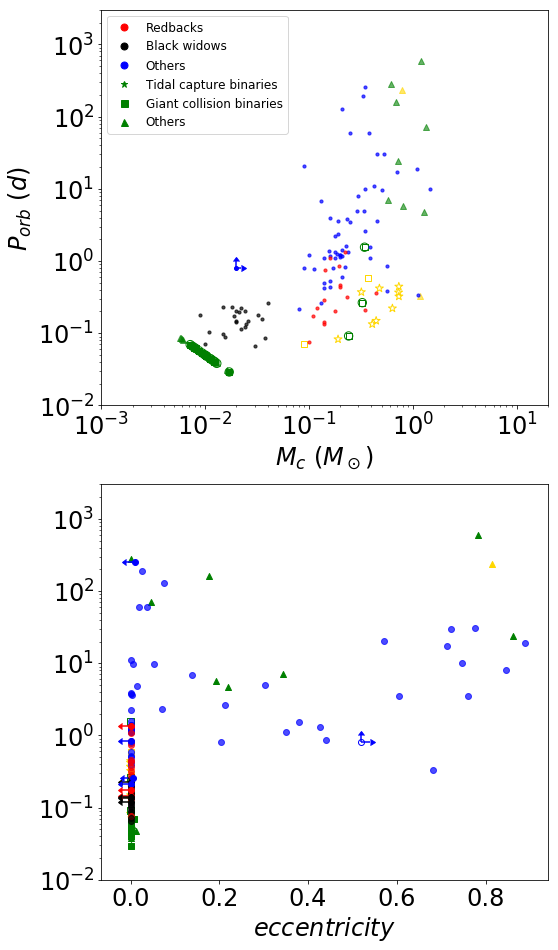

In [9]:
##Compare model pulsars Mc_Period with observed ones.

###Get model data
##Pulsars at the last timestep
datamsp=np.genfromtxt('/projects/b1095/syr904/cmc/cmc-mpi-tidalcapture/add_tc_bin_rlof_flag/msp_last_tc_rlof.dat')
datapsr=np.genfromtxt('/projects/b1095/syr904/cmc/cmc-mpi-tidalcapture/add_tc_bin_rlof_flag/normalpsr_last_tc_rlof.dat')
m0_msp=datamsp[:,10]; m1_msp=datamsp[:,11]; sma_msp=datamsp[:,16]; ecc_msp=datamsp[:,17]
k0_msp=datamsp[:,14]; k1_msp=datamsp[:,15]; B_msp=datamsp[:,4]; P_msp=datamsp[:,5]
id0_msp=datamsp[:,12]; id1_msp=datamsp[:,13]; model_msp=datamsp[:,0]

m0_psr=datapsr[:,10]; m1_psr=datapsr[:,11]; sma_psr=datapsr[:,16]; ecc_psr=datapsr[:,17]
k0_psr=datapsr[:,14]; k1_psr=datapsr[:,15]; B_psr=datapsr[:,4]; P_psr=datapsr[:,5]
id0_psr=datapsr[:,12]; id1_psr=datapsr[:,13]; model_psr=datapsr[:,0]

Pdot_psr=Kconst*yearsc*B_psr*B_psr/P_psr
Pdot_msp=Kconst*yearsc*B_msp*B_msp/P_msp
Pdot_msp=Pdot_msp *10**19*1000; Pdot_psr=Pdot_psr*10**19*1000
P_msp = P_msp*1000; P_psr = P_psr*1000


##Create distinc ids for different models
id0_new_psr = []
for x in range(len(model_psr)):
    id0_new_psr.append(str(int(model_psr[x]))+str(int(id0_psr[x])))
    
id0_new_msp = []
for y in range(len(model_msp)):
    id0_new_msp.append(str(int(model_msp[y]))+str(int(id0_msp[y])))



##NSWD and NSMS binaries that are not MSPs or young pulsars at the last timestep
data13ms=np.genfromtxt('/projects/b1095/syr904/cmc/cmc-mpi-tidalcapture/add_tc_bin_rlof_flag/NSMS_last_tc_rlof.dat')
data13wd=np.genfromtxt('/projects/b1095/syr904/cmc/cmc-mpi-tidalcapture/add_tc_bin_rlof_flag/NSWD_last_tc_rlof.dat')

id0_13ms=data13ms[:,2]; id1_13ms=data13ms[:,3]; m0_13ms=data13ms[:,4]; m1_13ms=data13ms[:,5]
sma_13ms=data13ms[:,8]; ecc_13ms=data13ms[:,9]; tcflag_13ms=data13ms[:,14]
model_13ms=data13ms[:,0]
k0_13ms=data13ms[:,6]; k1_13ms=data13ms[:,7]

id0_13wd=data13wd[:,2]; id1_13wd=data13wd[:,3]; m0_13wd=data13wd[:,4]; m1_13wd=data13wd[:,5]
sma_13wd=data13wd[:,8]; ecc_13wd=data13wd[:,9]; tcflag_13wd=data13wd[:,14]
model_13wd=data13wd[:,0]
k0_13wd=data13wd[:,6]; k1_13wd=data13wd[:,7]

##Create distinct ids for different models
id0_new_13ms = []
for x in range(len(model_13ms)):
    id0_new_13ms.append(str(int(model_13ms[x]))+str(int(id0_13ms[x])))
    
id0_new_13wd = []
for y in range(len(model_13wd)):
    id0_new_13wd.append(str(int(model_13wd[y]))+str(int(id0_13wd[y])))

                                        
###Get observed data
P, Pdot, Binflag, Namespin, Period, Ecc, Mc, Names, Pall, Bfall, Nameall = pc.readdata_freire()
print(len(Pall), len(Bfall))
print(Ecc)
datarb=np.genfromtxt('/projects/b1095/syr904/projects/PULSAR/data_observed/GCredback.dat', dtype=str)
databw=np.genfromtxt('/projects/b1095/syr904/projects/PULSAR/data_observed/GCblackwidow.dat', dtype=str)
namerb=datarb[:,0]; namebw=databw[:,0]


###Plotting
plt.rcParams['figure.figsize'] = [8,16]
rdot=mlines.Line2D([], [],  linestyle = 'None', color='r', marker='o',
                  markersize=7, label='Redbacks')
kdot=mlines.Line2D([], [],  linestyle = 'None', color='k', marker='o',
                  markersize=7, label='Black widows')
bdot=mlines.Line2D([], [],  linestyle = 'None', color='b', marker='o',
                  markersize=7, label='Others')
gtri=mlines.Line2D([], [],  linestyle = 'None', color='g', marker='^',
                  markersize=7, label='Others')
star=mlines.Line2D([], [],  linestyle = 'None', color='g', marker='*',
                  markersize=7, label='Tidal capture binaries')
square=mlines.Line2D([], [],  linestyle = 'None', color='g', marker='s',
                  markersize=7, label='Giant collision binaries')
tri=mlines.Line2D([], [],  linestyle = 'None', color='g', marker='^',
                  markersize=7, label='Others')


fig, axs = plt.subplots(nrows=2, sharey=False)
fig.subplots_adjust(wspace=0.05)

clrs = ['gold', 'green', 'green', 'gold']
##Model data
for ii in range(len(id0_new_13ms)):
    pb_13ms = uc.au_to_period(sma_13ms[ii], m0_13ms[ii], m1_13ms[ii])
    if m1_13ms[ii]<0.04:
        print(m1_13ms[ii], pb_13ms, id0_new_13ms[ii], id1_13ms[ii], k1_13ms[ii], tcflag_13ms[ii])
    if tcflag_13ms[ii]==91:
        if id0_new_13ms[ii] in id0_new_msp:# or id0_new_13ms[ii] in id0_new_psr:
            axs[0].scatter(m1_13ms[ii], pb_13ms, color=clrs[0], marker = '*', s=70, lw = 1)
            #axs[0].scatter(m1_13ms[ii], pb_13ms, color='red', marker = 'o', 
            #               lw = 1, facecolor = 'none')
            axs[1].scatter(ecc_13ms[ii], pb_13ms,  color=clrs[0], marker = '*', s=70, lw = 1)
        else:
            axs[0].scatter(m1_13ms[ii], pb_13ms, color=clrs[0], marker = '*', s=70, 
                           lw = 1, facecolors='none')
            axs[1].scatter(ecc_13ms[ii], pb_13ms,  color=clrs[0], marker = '*', s=70, 
                           lw = 1, facecolors='none')
    elif tcflag_13ms[ii]==81:
        if id0_new_13ms[ii] in id0_new_msp:# or id0_new_13ms[ii] in id0_new_psr:
            axs[0].scatter(m1_13ms[ii], pb_13ms, color=clrs[0], marker = 's', lw = 1)
            axs[1].scatter(ecc_13ms[ii], pb_13ms,  color=clrs[0], marker = 's', lw = 1)
        else:
            axs[0].scatter(m1_13ms[ii], pb_13ms, color=clrs[0], marker = 's', 
                           lw = 1, facecolors='none')
            axs[1].scatter(ecc_13ms[ii], pb_13ms,  color=clrs[0], marker = 's', 
                           lw = 1, facecolors='none')
        
    else:
        if id0_new_13ms[ii] in id0_new_msp:# or id0_new_13ms[ii] in id0_new_psr:
            print(id0_new_13ms[ii])
            axs[0].scatter(m1_13ms[ii], pb_13ms, color=clrs[0], marker = '^', 
                           lw = 1, alpha=0.6)
            axs[1].scatter(ecc_13ms[ii], pb_13ms,  color=clrs[0], marker = '^', lw = 1)
        #else:
        #    axs[0].scatter(m1_13ms[ii], pb_13ms, color='red', marker = '^', lw = 1, facecolors='none')
        #    axs[1].scatter(ecc_13ms[ii], pb_13ms,  color='red', marker = '^', lw = 1, facecolors='none')

            
for hh in range(len(id0_new_13wd)):
    pb_13wd = uc.au_to_period(sma_13wd[hh], m0_13wd[hh], m1_13wd[hh])
    #if m1_13wd[hh]<0.04:
    #    print(m1_13wd[hh], pb_13wd, id0_new_13wd[hh], id1_13wd[hh], k1_13wd[hh], tcflag_13wd[hh])
    #if ecc_13wd[hh]>1:
    #    print(id0_13wd[hh], id1_13wd[hh])
    if tcflag_13wd[hh]==91:
        if k1_13wd[hh]==10:
            if m1_13wd[hh]>0.06:
                if id0_new_13wd[hh] in id0_new_msp:# or id0_new_13wd[hh] in id0_new_psr:
                    axs[0].scatter(m1_13wd[hh], pb_13wd, color=clrs[1], marker = '*', s=70, lw = 1)
                    axs[0].scatter(m1_13wd[hh], pb_13wd, color=clrs[1], marker = 'o', 
                                   lw = 1, facecolor = 'none', s=70)
                    axs[1].scatter(ecc_13wd[hh], pb_13wd,  color=clrs[1], marker = '*', s=70, lw = 1) 
                else:
                    axs[0].scatter(m1_13wd[hh], pb_13wd, color=clrs[1], marker = '*', s=70, 
                                   lw = 1, facecolors='none')
                    axs[0].scatter(m1_13wd[hh], pb_13wd, color=clrs[1], marker = 'o', 
                                   lw = 1, facecolor = 'none', s=70)
                    axs[1].scatter(ecc_13wd[hh], pb_13wd,  color=clrs[1], marker = '*', s=70, 
                                   lw = 1, facecolors='none') 
            else:
                if id0_new_13wd[hh] in id0_new_msp:# or id0_new_13wd[hh] in id0_new_psr:
                    axs[0].scatter(m1_13wd[hh], pb_13wd, color=clrs[2], marker = '*', s=70, lw = 1)
                    axs[0].scatter(m1_13wd[hh], pb_13wd, color=clrs[2], marker = 'o', 
                                   lw = 1, facecolor = 'none', s=70)
                    axs[1].scatter(ecc_13wd[hh], pb_13wd,  color=clrs[2], marker = '*', s=70, lw = 1) 
                else:
                    axs[0].scatter(m1_13wd[hh], pb_13wd, color=clrs[2], marker = '*', s=70, 
                                   lw = 1, facecolors='none')
                    axs[0].scatter(m1_13wd[hh], pb_13wd, color=clrs[2], marker = 'o', 
                                   lw = 1, facecolor = 'none', s=70)
                    axs[1].scatter(ecc_13wd[hh], pb_13wd,  color=clrs[2], marker = '*', s=70, 
                                   lw = 1, facecolors='none') 
                
    
        elif k1_13wd[hh]>10:
            if m1_13wd[hh]>0.06:
                if id0_new_13wd[hh] in id0_new_msp:# or id0_new_13wd[hh] in id0_new_psr:
                    axs[0].scatter(m1_13wd[hh], pb_13wd, color=clrs[1], marker = '*', s=70, lw = 1)
                    axs[1].scatter(ecc_13wd[hh], pb_13wd,  color=clrs[1], marker = '*', s=70, lw = 1) 
                else:
                    axs[0].scatter(m1_13wd[hh], pb_13wd, color=clrs[1], marker = '*', s=70,
                                   lw = 1, facecolors='none')
                    axs[1].scatter(ecc_13wd[hh], pb_13wd,  color=clrs[1], marker = '*', s=70,
                                   lw = 1, facecolors='none') 
            else:
                if id0_new_13wd[hh] in id0_new_msp:# or id0_new_13wd[hh] in id0_new_psr:
                    axs[0].scatter(m1_13wd[hh], pb_13wd, color=clrs[2], marker = '*', s=70, lw = 1)
                    axs[1].scatter(ecc_13wd[hh], pb_13wd,  color=clrs[2], marker = '*', s=70, lw = 1) 
                else:
                    axs[0].scatter(m1_13wd[hh], pb_13wd, color=clrs[2], marker = '*', s=70,
                                   lw = 1, facecolors='none')
                    axs[1].scatter(ecc_13wd[hh], pb_13wd,  color=clrs[2], marker = '*', s=70,
                                   lw = 1, facecolors='none')
    
    elif tcflag_13wd[hh]==81:
        if k1_13wd[hh]==10:
            if m1_13wd[hh]>0.06:
                if id0_new_13wd[hh] in id0_new_msp:# or id0_new_13wd[hh] in id0_new_psr:
                    axs[0].scatter(m1_13wd[hh], pb_13wd, color=clrs[1], marker = 's', lw = 1)
                    axs[0].scatter(m1_13wd[hh], pb_13wd, color=clrs[1], marker = 'o', 
                                   lw = 1, facecolor = 'none', s=70)
                    axs[1].scatter(ecc_13wd[hh], pb_13wd,  color=clrs[1], marker = 's', lw = 1) 
                else:
                    axs[0].scatter(m1_13wd[hh], pb_13wd, color=clrs[1], marker = 's', 
                                   lw = 1, facecolors='none')
                    axs[0].scatter(m1_13wd[hh], pb_13wd, color=clrs[1], marker = 'o', 
                                   lw = 1, facecolor = 'none', s=70)
                    axs[1].scatter(ecc_13wd[hh], pb_13wd,  color=clrs[1], marker = 's', s=50, 
                                   lw = 1, facecolors='none')
                    
            else:
                if id0_new_13wd[hh] in id0_new_msp:# or id0_new_13wd[hh] in id0_new_psr:
                    axs[0].scatter(m1_13wd[hh], pb_13wd, color=clrs[2], marker = 's', lw = 1)
                    axs[0].scatter(m1_13wd[hh], pb_13wd, color=clrs[2], marker = 'o', 
                                   lw = 1, facecolor = 'none', s=70)
                    axs[1].scatter(ecc_13wd[hh], pb_13wd,  color=clrs[2], marker = 's', lw = 1) 
                else:
                    axs[0].scatter(m1_13wd[hh], pb_13wd, color=clrs[2], marker = 's', 
                                   lw = 1, facecolors='none')
                    axs[0].scatter(m1_13wd[hh], pb_13wd, color=clrs[2], marker = 'o', 
                                   lw = 1, facecolor = 'none', s=70)
                    axs[1].scatter(ecc_13wd[hh], pb_13wd,  color=clrs[2], marker = 's', s=50, 
                                   lw = 1, facecolors='none')
                
    
        elif k1_13wd[hh]>10:
            if m1_13wd[hh]>0.06:
                if id0_new_13wd[hh] in id0_new_msp:# or id0_new_13wd[hh] in id0_new_psr:
                    axs[0].scatter(m1_13wd[hh], pb_13wd, color=clrs[1], marker = 's', lw = 1)
                    axs[1].scatter(ecc_13wd[hh], pb_13wd,  color=clrs[1], marker = 's', lw = 1) 
                else:
                    axs[0].scatter(m1_13wd[hh], pb_13wd, color=clrs[1], marker = 's', 
                                   lw = 1, facecolors='none')
                    axs[1].scatter(ecc_13wd[hh], pb_13wd,  color=clrs[1], marker = 's', 
                                   lw = 1, facecolors='none') 
            else:
                if id0_new_13wd[hh] in id0_new_msp:# or id0_new_13wd[hh] in id0_new_psr:
                    axs[0].scatter(m1_13wd[hh], pb_13wd, color=clrs[2], marker = 's', lw = 1)
                    axs[1].scatter(ecc_13wd[hh], pb_13wd,  color=clrs[2], marker = 's', lw = 1) 
                else:
                    axs[0].scatter(m1_13wd[hh], pb_13wd, color=clrs[2], marker = 's', 
                                   lw = 1, facecolors='none')
                    axs[1].scatter(ecc_13wd[hh], pb_13wd,  color=clrs[2], marker = 's', 
                                   lw = 1, facecolors='none') 
                
    else: 
        if k1_13wd[hh]==10:
            if m1_13wd[hh]>0.06:
                if id0_new_13wd[hh] in id0_new_msp:# or id0_new_13wd[hh] in id0_new_psr:
                    axs[0].scatter(m1_13wd[hh], pb_13wd, color=clrs[1], marker = '^', 
                                   lw = 1, alpha=0.6)
                    axs[0].scatter(m1_13wd[hh], pb_13wd, color=clrs[1], marker = 'o', 
                                   lw = 1, facecolor = 'none', s=70)
                    axs[1].scatter(ecc_13wd[hh], pb_13wd,  color=clrs[1], marker = '^', lw = 1) 
            else:
                if id0_new_13wd[hh] in id0_new_msp:# or id0_new_13wd[hh] in id0_new_psr:
                    axs[0].scatter(m1_13wd[hh], pb_13wd, color=clrs[2], marker = '^', 
                                   lw = 1, alpha=0.6)
                    axs[0].scatter(m1_13wd[hh], pb_13wd, color=clrs[2], marker = 'o', 
                                   lw = 1, facecolor = 'none', s=70)
                    axs[1].scatter(ecc_13wd[hh], pb_13wd,  color=clrs[2], marker = '^', lw = 1) 
        elif k1_13wd[hh]>10:
            if m1_13wd[hh]>0.06:
                if id0_new_13wd[hh] in id0_new_msp:# or id0_new_13wd[hh] in id0_new_psr:
                    axs[0].scatter(m1_13wd[hh], pb_13wd, color=clrs[1], marker = '^', 
                                   lw = 1, alpha=0.6)
                    axs[1].scatter(ecc_13wd[hh], pb_13wd,  color=clrs[1], marker = '^', lw = 1)
            else:
                if id0_new_13wd[hh] in id0_new_msp:# or id0_new_13wd[hh] in id0_new_psr:
                    axs[0].scatter(m1_13wd[hh], pb_13wd, color=clrs[2], marker = '^', 
                                   lw = 1, alpha=0.6)
                    axs[1].scatter(ecc_13wd[hh], pb_13wd,  color=clrs[2], marker = '^', lw = 1)

            
##Observed data
for i in range(len(Mc)):
    if Mc[i][0] != '>':
        if Names[i] in namerb:
            axs[0].scatter(float(Mc[i]), float(Period[i]), color='red', s = 10, 
                           alpha=0.7, zorder=2)
            if Ecc[i][0]!='<' and Ecc[i][0]!='-':
                axs[1].scatter(float(Ecc[i]), float(Period[i]),  color='red', alpha=0.7, zorder=2)
            elif Ecc[i][0]!='-':
                axs[1].errorbar(float(Ecc[i].split('<')[1]), float(Period[i]), xerr=0.02, 
                                xuplims=True,  marker='o', color='red', linestyle='none')
                
            
        elif Names[i] in namebw:
            axs[0].scatter(float(Mc[i]), float(Period[i]), color='k', s = 10, 
                           alpha=0.7, zorder=2)
            if Ecc[i][0]!='<':
                axs[1].scatter(float(Ecc[i]), float(Period[i]), color='k', alpha=0.7, zorder=2)
            else:
                axs[1].errorbar(float(Ecc[i].split('<')[1]), float(Period[i]), xerr=0.02, 
                                xuplims=True,  marker='o', color='k', linestyle='none')
                
            
        else:
            axs[0].scatter(float(Mc[i]), float(Period[i]), color='b', s = 10, 
                           alpha=0.7, zorder=1)
            if Ecc[i][0]!='<':
                axs[1].scatter(float(Ecc[i]), float(Period[i]), color='b', alpha=0.7, zorder=1)
            else:
                #print(Ecc[i])
                axs[1].errorbar(float(Ecc[i].split('<')[1]), float(Period[i]), xerr=0.02, 
                                xuplims=True,  marker='o', color='b', linestyle='none')
                
    
    else:
        axs[0].errorbar(float(Mc[i].split('>')[1]), float(Period[i].split('>')[1]), xerr=0.002, yerr=0.2, lolims=True, 
                        xlolims=True, marker='o', color='b', markersize = 4, linestyle='none')
        axs[1].errorbar(float(Ecc[i].split('>')[1]), float(Period[i].split('>')[1]), xerr=0.02, yerr=0.2, lolims=True, 
                        xlolims=True, marker='o', markerfacecolor='none', color='b', linestyle='none')
        
        
            
        
axs[0].set_yscale('log')
axs[0].set_xscale('log')
axs[0].set_ylim(0.01, 3000)
axs[0].set_xlim(0.001, 20)
axs[0].set_xlabel(r'$M_c\ (M_\odot)$')
axs[0].set_ylabel(r'$P_{orb}\ (d)$')
axs[0].legend(handles=[rdot, kdot, bdot, star, square, tri], loc='upper left', prop={'size': 12}, numpoints=1, frameon=True)

axs[1].set_yscale('log')
#axs[1].set_xscale('symlog')
axs[1].set_ylim(0.01, 3000)
#axs[1].set_xlim(-0.1, 1)
axs[1].set_xlabel(r'$eccentricity$')
#axs[1].set_ylabel(r'$P_{orb}\ (d)$')

157
157 157
['0.00031', '0.07056', '<0.0004', '<0.00004', '<0.00016', '0.0', '0.00008', '0.0', '0.00039', '0.00040', '0.00014', '0.0', '0.0', '0.0000005', '0.000003', '0.88798', '<0.01', '0.0', '0.0', '0.0753', '0.13784', '0.0', '0.0', '0.0', '0.0', '0.02532', '0.000002', '0.00057', '0.00012', '0.0', '0.000004', '<0.00007', '<0.00006', '0.00045', '0.0', '0.0', '-', '<0.005', '<0.0001', '0.0', '0.02', '0.428', '0.350', '0', '0.000045', '0', '0', '0.722', '0.60498', '0', '0.015', '0.3024', '0', '0.7608', '0', '0', '0.4400', '0.20475', '0.57016', '0.00', '0.0531', '0.71243', '0.00404', '0.038', '0.21206', '0.0', '0.74703', '0.847', '0.776', '0.0', '0.0', '0.0', '0.0', '0.00152', '0.0', '0.0', '0.0', '<0.00001', '<0.00013', '0.0', '0.68139', '<0.00012', '>0.52']


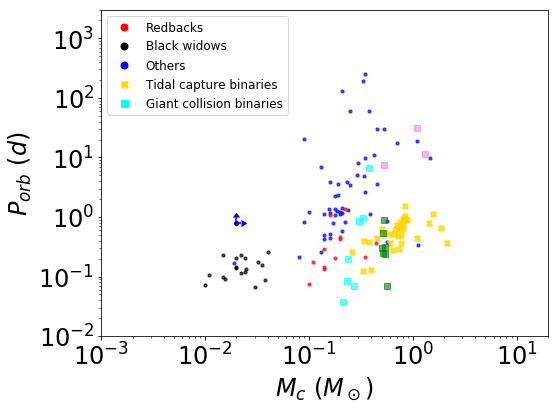

In [ ]:
##Compare model pulsars Mc_Period with observed ones
##for tidal capture and giant collision binaries between 9-12 Gyr

###Get model data
##Pulsars at the last timestep
datamsp=np.genfromtxt('/projects/b1095/syr904/cmc/cmc-mpi-tidalcapture/rvgrid/standard_models_tcon/msp_last_rvgrid_tcon.dat')
datapsr=np.genfromtxt('/projects/b1095/syr904/cmc/cmc-mpi-tidalcapture/rvgrid/standard_models_tcon/normalpsr_last_rvgrid_tcon.dat')
m0_msp=datamsp[:,10]; m1_msp=datamsp[:,11]; sma_msp=datamsp[:,16]; ecc_msp=datamsp[:,17]
k0_msp=datamsp[:,14]; k1_msp=datamsp[:,15]; B_msp=datamsp[:,4]; P_msp=datamsp[:,5]
id0_msp=datamsp[:,12]; id1_msp=datamsp[:,13]; model_msp=datamsp[:,0]

m0_psr=datapsr[:,10]; m1_psr=datapsr[:,11]; sma_psr=datapsr[:,16]; ecc_psr=datapsr[:,17]
k0_psr=datapsr[:,14]; k1_psr=datapsr[:,15]; B_psr=datapsr[:,4]; P_psr=datapsr[:,5]
id0_psr=datapsr[:,12]; id1_psr=datapsr[:,13]; model_psr=datapsr[:,0]

Pdot_psr=Kconst*yearsc*B_psr*B_psr/P_psr
Pdot_msp=Kconst*yearsc*B_msp*B_msp/P_msp
Pdot_msp=Pdot_msp *10**19*1000; Pdot_psr=Pdot_psr*10**19*1000
P_msp = P_msp*1000; P_psr = P_psr*1000


##Create distinc ids for different models
id0_new_psr = []
for x in range(len(model_psr)):
    id0_new_psr.append(str(int(model_psr[x]))+str(int(id0_psr[x])))
    
id0_new_msp = []
for y in range(len(model_msp)):
    id0_new_msp.append(str(int(model_msp[y]))+str(int(id0_msp[y])))



##NSWD and NSMS binaries that are not MSPs or young pulsars at the last timestep
data13ms=np.genfromtxt('/projects/b1095/syr904/cmc/cmc-mpi-tidalcapture/rvgrid/standard_models_tcon/NSMS_last_rvgrid_tcon.dat')
data13wd=np.genfromtxt('/projects/b1095/syr904/cmc/cmc-mpi-tidalcapture/rvgrid/standard_models_tcon/NSWD_last_rvgrid_tcon.dat')

id0_13ms=data13ms[:,2]; id1_13ms=data13ms[:,3]; m0_13ms=data13ms[:,4]; m1_13ms=data13ms[:,5]
sma_13ms=data13ms[:,8]; ecc_13ms=data13ms[:,9]; tcflag_13ms=data13ms[:,14]
model_13ms=data13ms[:,0]
k0_13ms=data13ms[:,6]; k1_13ms=data13ms[:,7]

id0_13wd=data13wd[:,2]; id1_13wd=data13wd[:,3]; m0_13wd=data13wd[:,4]; m1_13wd=data13wd[:,5]
sma_13wd=data13wd[:,8]; ecc_13wd=data13wd[:,9]; tcflag_13wd=data13wd[:,14]
model_13wd=data13wd[:,0]
k0_13wd=data13wd[:,6]; k1_13wd=data13wd[:,7]

##Create distinct ids for different models
id0_new_13ms = []
for x in range(len(model_13ms)):
    id0_new_13ms.append(str(int(model_13ms[x]))+str(int(id0_13ms[x])))
    
id0_new_13wd = []
for y in range(len(model_13wd)):
    id0_new_13wd.append(str(int(model_13wd[y]))+str(int(id0_13wd[y])))


##Tidal capture and giant collision binaries at all times
datatc = np.genfromtxt('/projects/b1095/syr904/cmc/cmc-mpi-tidalcapture/rvgrid/standard_models_tcon/all_tc_NSXX.dat')
datacoll = np.genfromtxt('/projects/b1095/syr904/cmc/cmc-mpi-tidalcapture/rvgrid/standard_models_tcon/all_coll_NSXX.dat')
time_tc = datatc[:,1]; m0_tc = datatc[:,14]; m1_tc = datatc[:,15]; pb_tc = datatc[:,18]
time_coll = datacoll[:,1]; m0_coll = datacoll[:,14]; m1_coll = datacoll[:,15]
pb_coll = datacoll[:,18]; k1_coll = datacoll[:,13]

m1_tc_912 = []; pb_tc_912 = []
m1_coll_912 = []; pb_coll_912 = []
m1_coll_912_ms = []; pb_coll_912_ms = []
m1_coll_912_hems = []; pb_coll_912_hems = []
m1_coll_912_hewd = []; pb_coll_912_hewd = []
m1_coll_912_other = []; pb_coll_912_other = []
for x in range(len(time_tc)):
    if 9000.<=time_tc[x]<=13000.:
        m1_tc_912.append(m1_tc[x]); pb_tc_912.append(pb_tc[x])

for y in range(len(time_coll)):
    if 9000.<=time_coll[y]<=13000.:
        m1_coll_912.append(m1_coll[y]); pb_coll_912.append(pb_coll[y])
        if k1_coll[y] <= 1:
            m1_coll_912_ms.append(m1_coll[y]); pb_coll_912_ms.append(pb_coll[y])
        elif k1_coll[y] == 7:
            m1_coll_912_hems.append(m1_coll[y]); pb_coll_912_hems.append(pb_coll[y])
        elif k1_coll[y] == 10:
            m1_coll_912_hewd.append(m1_coll[y]); pb_coll_912_hewd.append(pb_coll[y])
        else:
            m1_coll_912_other.append(m1_coll[y]); pb_coll_912_other.append(pb_coll[y])

                                        
###Get observed data
P, Pdot, Binflag, Namespin, Period, Ecc, Mc, Names, Pall, Bfall, Nameall = pc.readdata_freire()
print(len(Pall), len(Bfall))
print(Ecc)
datarb=np.genfromtxt('/projects/b1095/syr904/projects/PULSAR/data_observed/GCredback.dat', dtype=str)
databw=np.genfromtxt('/projects/b1095/syr904/projects/PULSAR/data_observed/GCblackwidow.dat', dtype=str)
namerb=datarb[:,0]; namebw=databw[:,0]


###Plotting
plt.rcParams['figure.figsize'] = [8,6]
rdot=mlines.Line2D([], [],  linestyle = 'None', color='r', marker='o',
                  markersize=7, label='Redbacks')
kdot=mlines.Line2D([], [],  linestyle = 'None', color='k', marker='o',
                  markersize=7, label='Black widows')
bdot=mlines.Line2D([], [],  linestyle = 'None', color='b', marker='o',
                  markersize=7, label='Others')
gtri=mlines.Line2D([], [],  linestyle = 'None', color='g', marker='^',
                  markersize=7, label='Others')
cross=mlines.Line2D([], [],  linestyle = 'None', color='gold', marker='X',
                  markersize=7, label='Tidal capture binaries')
square=mlines.Line2D([], [],  linestyle = 'None', color='aqua', marker='s',
                  markersize=7, label='Giant collision binaries')
tri=mlines.Line2D([], [],  linestyle = 'None', color='g', marker='^',
                  markersize=7, label='Others')


fig, axs = plt.subplots(nrows=1, sharey=False)
fig.subplots_adjust(wspace=0.05)
            
##Observed data
for i in range(len(Mc)):
    if Mc[i][0] != '>':
        if Names[i] in namerb:
            axs.scatter(float(Mc[i]), float(Period[i]), color='red', s = 10, 
                           alpha=0.7, zorder=2)
                
            
        elif Names[i] in namebw:
            axs.scatter(float(Mc[i]), float(Period[i]), color='k', s = 10, 
                           alpha=0.7, zorder=2)
            
        else:
            axs.scatter(float(Mc[i]), float(Period[i]), color='b', s = 10, 
                           alpha=0.7, zorder=1)
                
    
    else:
        axs.errorbar(float(Mc[i].split('>')[1]), float(Period[i].split('>')[1]), xerr=0.002, yerr=0.2, lolims=True, 
                        xlolims=True, marker='o', color='b', markersize = 4, linestyle='none')
        

axs.scatter(m1_tc_912, pb_tc_912, marker = 'X', color = 'gold', alpha=0.8)
#axs.scatter(m1_coll_912, pb_coll_912, label = 'GIANT COLL BINARIES')
axs.scatter(m1_coll_912_ms, pb_coll_912_ms, marker = 's', color = 'gold', alpha=0.8)
axs.scatter(m1_coll_912_hems, pb_coll_912_hems, marker = 's', color = 'green', alpha=0.6)
axs.scatter(m1_coll_912_hewd, pb_coll_912_hewd, marker = 's', color = 'aqua', alpha=0.6)
axs.scatter(m1_coll_912_other, pb_coll_912_other, marker = 's', color = 'violet', alpha=0.6)
        
axs.set_yscale('log')
axs.set_xscale('log')
axs.set_ylim(0.01, 3000)
axs.set_xlim(0.001, 20)
axs.set_xlabel(r'$M_c\ (M_\odot)$')
axs.set_ylabel(r'$P_{orb}\ (d)$')
axs.legend(handles=[rdot, kdot, bdot, cross, square], loc='upper left', prop={'size': 12}, numpoints=1, frameon=True)

223
0.0 1.321382 0.010554 0.0470957840324765 01038409 332706.0 10.0 81.0 61601000.0 0.00162
0.0 1.34194 0.008482 0.05867020059468275 0350273 114377.0 10.0 81.0 64791500.0 0.001595
1.0 1.790622 0.011248 0.04380097472403666 1110708 722335.0 10.0 81.0 50319400.0 0.002006
1.0 1.3053 0.02658 0.01851677649498908 11247602 357528.0 11.0 4.0 254713000.0 0.002013
1.0 1.341385 0.00904 0.05501753961089227 1958292 532235.0 11.0 4.0 77028300.0 0.001605
1.0 1.320224 0.011709 0.042421899699907235 1346476 7691.0 10.0 81.0 51652700.0 0.001643
2.0 1.335574 0.014887 0.033301835541898445 2996909 428458.0 11.0 4.0 52761200.0 0.001724
2.0 1.500662 0.014556 0.033935435228315686 21456476 146432.0 11.0 4.0 78067700.0 0.001859
2.0 1.628692 0.018953 0.02589345820096222 2801710 213963.0 11.0 4.0 50084200.0 0.002096
2.0 1.318231 0.013659 0.03633404214107982 244251 549481.0 10.0 81.0 51252300.0 0.001684
2.0 1.32067 0.011368 0.04371439057341846 2198119 504068.0 11.0 81.0 50929400.0 0.001635
3.0 1.53475 0.008778 0.055

Text(0.5,0,'$eccentricity$')

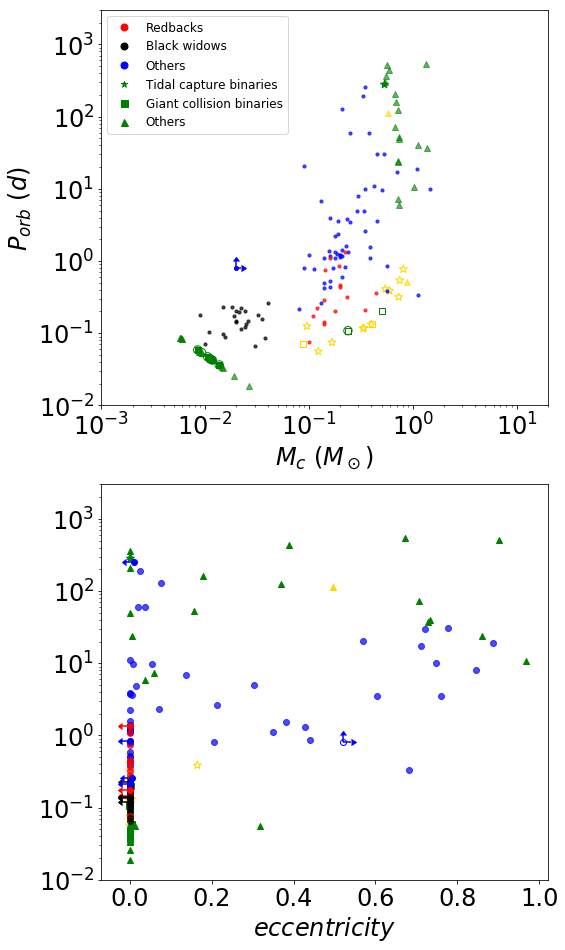

In [12]:
##Compare model pulsars Mc_Period with observed ones for models with tc rlof turned on
##EXCLUDING AIC NSs

###Get model data
##Pulsars at the last timestep
datamsp=np.genfromtxt('/projects/b1095/syr904/cmc/cmc-mpi-tidalcapture/rvgrid/standard_models_tcon/msp_last_tcon.dat')
datapsr=np.genfromtxt('/projects/b1095/syr904/cmc/cmc-mpi-tidalcapture/rvgrid/standard_models_tcon/normalpsr_last_tc_on.dat')
m0_msp=datamsp[:,10]; m1_msp=datamsp[:,11]; sma_msp=datamsp[:,16]; ecc_msp=datamsp[:,17]
k0_msp=datamsp[:,14]; k1_msp=datamsp[:,15]; B_msp=datamsp[:,4]; P_msp=datamsp[:,5]
id0_msp=datamsp[:,12]; id1_msp=datamsp[:,13]; model_msp=datamsp[:,0]

m0_psr=datapsr[:,10]; m1_psr=datapsr[:,11]; sma_psr=datapsr[:,16]; ecc_psr=datapsr[:,17]
k0_psr=datapsr[:,14]; k1_psr=datapsr[:,15]; B_psr=datapsr[:,4]; P_psr=datapsr[:,5]
id0_psr=datapsr[:,12]; id1_psr=datapsr[:,13]; model_psr=datapsr[:,0]

Pdot_psr=Kconst*yearsc*B_psr*B_psr/P_psr
Pdot_msp=Kconst*yearsc*B_msp*B_msp/P_msp
Pdot_msp=Pdot_msp *10**19*1000; Pdot_psr=Pdot_psr*10**19*1000
P_msp = P_msp*1000; P_psr = P_psr*1000


##Create distinc ids for different models
id0_new_psr = []
for x in range(len(model_psr)):
    id0_new_psr.append(str(int(model_psr[x]))+str(int(id0_psr[x])))
    
id0_new_msp = []
for y in range(len(model_msp)):
    id0_new_msp.append(str(int(model_msp[y]))+str(int(id0_msp[y])))



##NSWD and NSMS binaries that are not MSPs or young pulsars at the last timestep
data13ms=np.genfromtxt('/projects/b1095/syr904/cmc/cmc-mpi-tidalcapture/rvgrid/standard_models_tcon/NSMS_last_rvgrid.dat')
data13wd=np.genfromtxt('/projects/b1095/syr904/cmc/cmc-mpi-tidalcapture/rvgrid/standard_models_tcon/NSWD_last_rvgrid.dat')

id0_13ms=data13ms[:,2]; id1_13ms=data13ms[:,3]; m0_13ms=data13ms[:,4]; m1_13ms=data13ms[:,5]
sma_13ms=data13ms[:,8]; ecc_13ms=data13ms[:,9]; tcflag_13ms=data13ms[:,14]; SN_ms=data13ms[:,15]
model_13ms=data13ms[:,0]
k0_13ms=data13ms[:,6]; k1_13ms=data13ms[:,7]
B_13ms=data13ms[:,12]; P_13ms=data13ms[:,13]

id0_13wd=data13wd[:,2]; id1_13wd=data13wd[:,3]; m0_13wd=data13wd[:,4]; m1_13wd=data13wd[:,5]
sma_13wd=data13wd[:,8]; ecc_13wd=data13wd[:,9]; tcflag_13wd=data13wd[:,14]; SN_wd=data13wd[:,15]
model_13wd=data13wd[:,0]
k0_13wd=data13wd[:,6]; k1_13wd=data13wd[:,7]
B_13wd=data13wd[:,12]; P_13wd=data13wd[:,13]
#print(SN_wd)

##Create distinct ids for different models
id0_new_13ms = []
for x in range(len(model_13ms)):
    id0_new_13ms.append(str(int(model_13ms[x]))+str(int(id0_13ms[x])))
    
id0_new_13wd = []
for y in range(len(model_13wd)):
    id0_new_13wd.append(str(int(model_13wd[y]))+str(int(id0_13wd[y])))

                                        
###Get observed data
P, Pdot, Binflag, Namespin, Period, Ecc, Mc, Names, Pall, Bfall, Nameall = pc.readdata_freire()
#print(len(Pall), len(Bfall))
#print(Ecc)
datarb=np.genfromtxt('/projects/b1095/syr904/projects/PULSAR/data_observed/GCredback.dat', dtype=str)
databw=np.genfromtxt('/projects/b1095/syr904/projects/PULSAR/data_observed/GCblackwidow.dat', dtype=str)
namerb=datarb[:,0]; namebw=databw[:,0]


###Plotting
plt.rcParams['figure.figsize'] = [8,16]
rdot=mlines.Line2D([], [],  linestyle = 'None', color='r', marker='o',
                  markersize=7, label='Redbacks')
kdot=mlines.Line2D([], [],  linestyle = 'None', color='k', marker='o',
                  markersize=7, label='Black widows')
bdot=mlines.Line2D([], [],  linestyle = 'None', color='b', marker='o',
                  markersize=7, label='Others')
gtri=mlines.Line2D([], [],  linestyle = 'None', color='g', marker='^',
                  markersize=7, label='Others')
star=mlines.Line2D([], [],  linestyle = 'None', color='g', marker='*',
                  markersize=7, label='Tidal capture binaries')
square=mlines.Line2D([], [],  linestyle = 'None', color='g', marker='s',
                  markersize=7, label='Giant collision binaries')
tri=mlines.Line2D([], [],  linestyle = 'None', color='g', marker='^',
                  markersize=7, label='Others')


fig, axs = plt.subplots(nrows=2, sharey=False)
fig.subplots_adjust(wspace=0.05)

clrs = ['gold', 'green', 'green', 'gold']
##Model data
for ii in range(len(id0_new_13ms)):
    pb_13ms = uc.au_to_period(sma_13ms[ii], m0_13ms[ii], m1_13ms[ii])
    if SN_ms[ii]==4: continue
    if m1_13ms[ii]<0.04:
        print(model_13ms[ii], m0_13ms[ii], m1_13ms[ii], pb_13ms, id0_new_13ms[ii], id1_13ms[ii], k1_13ms[ii], 
              tcflag_13ms[ii], B_13ms[ii], P_13ms[ii])
    if tcflag_13ms[ii]==91:
        if id0_new_13ms[ii] in id0_new_msp:# or id0_new_13ms[ii] in id0_new_psr:
            axs[0].scatter(m1_13ms[ii], pb_13ms, color=clrs[0], marker = '*', s=70, lw = 1)
            #axs[0].scatter(m1_13ms[ii], pb_13ms, color='red', marker = 'o', 
            #               lw = 1, facecolor = 'none')
            axs[1].scatter(ecc_13ms[ii], pb_13ms,  color=clrs[0], marker = '*', s=70, lw = 1)
        else:
            axs[0].scatter(m1_13ms[ii], pb_13ms, color=clrs[0], marker = '*', s=70, 
                           lw = 1, facecolors='none')
            axs[1].scatter(ecc_13ms[ii], pb_13ms,  color=clrs[0], marker = '*', s=70, 
                           lw = 1, facecolors='none')
    elif tcflag_13ms[ii]==81:
        if id0_new_13ms[ii] in id0_new_msp:# or id0_new_13ms[ii] in id0_new_psr:
            axs[0].scatter(m1_13ms[ii], pb_13ms, color=clrs[0], marker = 's', lw = 1)
            axs[1].scatter(ecc_13ms[ii], pb_13ms,  color=clrs[0], marker = 's', lw = 1)
        else:
            axs[0].scatter(m1_13ms[ii], pb_13ms, color=clrs[0], marker = 's', 
                           lw = 1, facecolors='none')
            axs[1].scatter(ecc_13ms[ii], pb_13ms,  color=clrs[0], marker = 's', 
                           lw = 1, facecolors='none')
        
    else:
        if id0_new_13ms[ii] in id0_new_msp:# or id0_new_13ms[ii] in id0_new_psr:
            #print(id0_new_13ms[ii])
            axs[0].scatter(m1_13ms[ii], pb_13ms, color=clrs[0], marker = '^', 
                           lw = 1, alpha=0.6)
            axs[1].scatter(ecc_13ms[ii], pb_13ms,  color=clrs[0], marker = '^', lw = 1)
        #else:
        #    axs[0].scatter(m1_13ms[ii], pb_13ms, color='red', marker = '^', lw = 1, facecolors='none')
        #    axs[1].scatter(ecc_13ms[ii], pb_13ms,  color='red', marker = '^', lw = 1, facecolors='none')

            
for hh in range(len(id0_new_13wd)):
    pb_13wd = uc.au_to_period(sma_13wd[hh], m0_13wd[hh], m1_13wd[hh])
    if SN_wd[hh]==4: continue
    if m1_13wd[hh]<0.04:
        print(model_13wd[hh], m0_13wd[hh], m1_13wd[hh], pb_13wd, id0_new_13wd[hh], id1_13wd[hh], k1_13wd[hh], 
              tcflag_13wd[hh], B_13wd[hh], P_13wd[hh])
    #if ecc_13wd[hh]>1:
    #    print(id0_13wd[hh], id1_13wd[hh])
    if tcflag_13wd[hh]==91:
        if k1_13wd[hh]==10:
            if m1_13wd[hh]>0.06:
                if id0_new_13wd[hh] in id0_new_msp:# or id0_new_13wd[hh] in id0_new_psr:
                    axs[0].scatter(m1_13wd[hh], pb_13wd, color=clrs[1], marker = '*', s=70, lw = 1)
                    axs[0].scatter(m1_13wd[hh], pb_13wd, color=clrs[1], marker = 'o', 
                                   lw = 1, facecolor = 'none', s=70)
                    axs[1].scatter(ecc_13wd[hh], pb_13wd,  color=clrs[1], marker = '*', s=70, lw = 1) 
                else:
                    axs[0].scatter(m1_13wd[hh], pb_13wd, color=clrs[1], marker = '*', s=70, 
                                   lw = 1, facecolors='none')
                    axs[0].scatter(m1_13wd[hh], pb_13wd, color=clrs[1], marker = 'o', 
                                   lw = 1, facecolor = 'none', s=70)
                    axs[1].scatter(ecc_13wd[hh], pb_13wd,  color=clrs[1], marker = '*', s=70, 
                                   lw = 1, facecolors='none') 
            else:
                if id0_new_13wd[hh] in id0_new_msp:# or id0_new_13wd[hh] in id0_new_psr:
                    axs[0].scatter(m1_13wd[hh], pb_13wd, color=clrs[2], marker = '*', s=70, lw = 1)
                    axs[0].scatter(m1_13wd[hh], pb_13wd, color=clrs[2], marker = 'o', 
                                   lw = 1, facecolor = 'none', s=70)
                    axs[1].scatter(ecc_13wd[hh], pb_13wd,  color=clrs[2], marker = '*', s=70, lw = 1) 
                else:
                    axs[0].scatter(m1_13wd[hh], pb_13wd, color=clrs[2], marker = '*', s=70, 
                                   lw = 1, facecolors='none')
                    axs[0].scatter(m1_13wd[hh], pb_13wd, color=clrs[2], marker = 'o', 
                                   lw = 1, facecolor = 'none', s=70)
                    axs[1].scatter(ecc_13wd[hh], pb_13wd,  color=clrs[2], marker = '*', s=70, 
                                   lw = 1, facecolors='none') 
                
    
        elif k1_13wd[hh]>10:
            if m1_13wd[hh]>0.06:
                if id0_new_13wd[hh] in id0_new_msp:# or id0_new_13wd[hh] in id0_new_psr:
                    axs[0].scatter(m1_13wd[hh], pb_13wd, color=clrs[1], marker = '*', s=70, lw = 1)
                    axs[1].scatter(ecc_13wd[hh], pb_13wd,  color=clrs[1], marker = '*', s=70, lw = 1) 
                else:
                    axs[0].scatter(m1_13wd[hh], pb_13wd, color=clrs[1], marker = '*', s=70,
                                   lw = 1, facecolors='none')
                    axs[1].scatter(ecc_13wd[hh], pb_13wd,  color=clrs[1], marker = '*', s=70,
                                   lw = 1, facecolors='none') 
            else:
                if id0_new_13wd[hh] in id0_new_msp:# or id0_new_13wd[hh] in id0_new_psr:
                    axs[0].scatter(m1_13wd[hh], pb_13wd, color=clrs[2], marker = '*', s=70, lw = 1)
                    axs[1].scatter(ecc_13wd[hh], pb_13wd,  color=clrs[2], marker = '*', s=70, lw = 1) 
                else:
                    axs[0].scatter(m1_13wd[hh], pb_13wd, color=clrs[2], marker = '*', s=70,
                                   lw = 1, facecolors='none')
                    axs[1].scatter(ecc_13wd[hh], pb_13wd,  color=clrs[2], marker = '*', s=70,
                                   lw = 1, facecolors='none')
    
    elif tcflag_13wd[hh]==81:
        if k1_13wd[hh]==10:
            if m1_13wd[hh]>0.06:
                if id0_new_13wd[hh] in id0_new_msp:# or id0_new_13wd[hh] in id0_new_psr:
                    axs[0].scatter(m1_13wd[hh], pb_13wd, color=clrs[1], marker = 's', lw = 1)
                    axs[0].scatter(m1_13wd[hh], pb_13wd, color=clrs[1], marker = 'o', 
                                   lw = 1, facecolor = 'none', s=70)
                    axs[1].scatter(ecc_13wd[hh], pb_13wd,  color=clrs[1], marker = 's', lw = 1) 
                else:
                    axs[0].scatter(m1_13wd[hh], pb_13wd, color=clrs[1], marker = 's', 
                                   lw = 1, facecolors='none')
                    axs[0].scatter(m1_13wd[hh], pb_13wd, color=clrs[1], marker = 'o', 
                                   lw = 1, facecolor = 'none', s=70)
                    axs[1].scatter(ecc_13wd[hh], pb_13wd,  color=clrs[1], marker = 's', s=50, 
                                   lw = 1, facecolors='none')
                    
            else:
                if id0_new_13wd[hh] in id0_new_msp:# or id0_new_13wd[hh] in id0_new_psr:
                    axs[0].scatter(m1_13wd[hh], pb_13wd, color=clrs[2], marker = 's', lw = 1)
                    axs[0].scatter(m1_13wd[hh], pb_13wd, color=clrs[2], marker = 'o', 
                                   lw = 1, facecolor = 'none', s=70)
                    axs[1].scatter(ecc_13wd[hh], pb_13wd,  color=clrs[2], marker = 's', lw = 1) 
                else:
                    axs[0].scatter(m1_13wd[hh], pb_13wd, color=clrs[2], marker = 's', 
                                   lw = 1, facecolors='none')
                    axs[0].scatter(m1_13wd[hh], pb_13wd, color=clrs[2], marker = 'o', 
                                   lw = 1, facecolor = 'none', s=70)
                    axs[1].scatter(ecc_13wd[hh], pb_13wd,  color=clrs[2], marker = 's', s=50, 
                                   lw = 1, facecolors='none')
                
    
        elif k1_13wd[hh]>10:
            if m1_13wd[hh]>0.06:
                if id0_new_13wd[hh] in id0_new_msp:# or id0_new_13wd[hh] in id0_new_psr:
                    axs[0].scatter(m1_13wd[hh], pb_13wd, color=clrs[1], marker = 's', lw = 1)
                    axs[1].scatter(ecc_13wd[hh], pb_13wd,  color=clrs[1], marker = 's', lw = 1) 
                else:
                    axs[0].scatter(m1_13wd[hh], pb_13wd, color=clrs[1], marker = 's', 
                                   lw = 1, facecolors='none')
                    axs[1].scatter(ecc_13wd[hh], pb_13wd,  color=clrs[1], marker = 's', 
                                   lw = 1, facecolors='none') 
            else:
                if id0_new_13wd[hh] in id0_new_msp:# or id0_new_13wd[hh] in id0_new_psr:
                    axs[0].scatter(m1_13wd[hh], pb_13wd, color=clrs[2], marker = 's', lw = 1)
                    axs[1].scatter(ecc_13wd[hh], pb_13wd,  color=clrs[2], marker = 's', lw = 1) 
                else:
                    axs[0].scatter(m1_13wd[hh], pb_13wd, color=clrs[2], marker = 's', 
                                   lw = 1, facecolors='none')
                    axs[1].scatter(ecc_13wd[hh], pb_13wd,  color=clrs[2], marker = 's', 
                                   lw = 1, facecolors='none') 
                
    else: 
        if k1_13wd[hh]==10:
            if m1_13wd[hh]>0.06:
                if id0_new_13wd[hh] in id0_new_msp:# or id0_new_13wd[hh] in id0_new_psr:
                    axs[0].scatter(m1_13wd[hh], pb_13wd, color=clrs[1], marker = '^', 
                                   lw = 1, alpha=0.6)
                    axs[0].scatter(m1_13wd[hh], pb_13wd, color=clrs[1], marker = 'o', 
                                   lw = 1, facecolor = 'none', s=70)
                    axs[1].scatter(ecc_13wd[hh], pb_13wd,  color=clrs[1], marker = '^', lw = 1) 
            else:
                if id0_new_13wd[hh] in id0_new_msp:# or id0_new_13wd[hh] in id0_new_psr:
                    axs[0].scatter(m1_13wd[hh], pb_13wd, color=clrs[2], marker = '^', 
                                   lw = 1, alpha=0.6)
                    axs[0].scatter(m1_13wd[hh], pb_13wd, color=clrs[2], marker = 'o', 
                                   lw = 1, facecolor = 'none', s=70)
                    axs[1].scatter(ecc_13wd[hh], pb_13wd,  color=clrs[2], marker = '^', lw = 1) 
        elif k1_13wd[hh]>10:
            if m1_13wd[hh]>0.06:
                if id0_new_13wd[hh] in id0_new_msp:# or id0_new_13wd[hh] in id0_new_psr:
                    axs[0].scatter(m1_13wd[hh], pb_13wd, color=clrs[1], marker = '^', 
                                   lw = 1, alpha=0.6)
                    axs[1].scatter(ecc_13wd[hh], pb_13wd,  color=clrs[1], marker = '^', lw = 1)
            else:
                if id0_new_13wd[hh] in id0_new_msp:# or id0_new_13wd[hh] in id0_new_psr:
                    axs[0].scatter(m1_13wd[hh], pb_13wd, color=clrs[2], marker = '^', 
                                   lw = 1, alpha=0.6)
                    axs[1].scatter(ecc_13wd[hh], pb_13wd,  color=clrs[2], marker = '^', lw = 1)

            
##Observed data
for i in range(len(Mc)):
    if Mc[i][0] != '>':
        if Names[i] in namerb:
            axs[0].scatter(float(Mc[i]), float(Period[i]), color='red', s = 10, 
                           alpha=0.7, zorder=2)
            if Ecc[i][0]!='<' and Ecc[i][0]!='-':
                axs[1].scatter(float(Ecc[i]), float(Period[i]),  color='red', alpha=0.7, zorder=2)
            elif Ecc[i][0]!='-':
                axs[1].errorbar(float(Ecc[i].split('<')[1]), float(Period[i]), xerr=0.02, 
                                xuplims=True,  marker='o', color='red', linestyle='none')
                
            
        elif Names[i] in namebw:
            axs[0].scatter(float(Mc[i]), float(Period[i]), color='k', s = 10, 
                           alpha=0.7, zorder=2)
            if Ecc[i][0]!='<':
                axs[1].scatter(float(Ecc[i]), float(Period[i]), color='k', alpha=0.7, zorder=2)
            else:
                axs[1].errorbar(float(Ecc[i].split('<')[1]), float(Period[i]), xerr=0.02, 
                                xuplims=True,  marker='o', color='k', linestyle='none')
                
            
        else:
            axs[0].scatter(float(Mc[i]), float(Period[i]), color='b', s = 10, 
                           alpha=0.7, zorder=1)
            if Ecc[i][0]!='<':
                axs[1].scatter(float(Ecc[i]), float(Period[i]), color='b', alpha=0.7, zorder=1)
            else:
                #print(Ecc[i])
                axs[1].errorbar(float(Ecc[i].split('<')[1]), float(Period[i]), xerr=0.02, 
                                xuplims=True,  marker='o', color='b', linestyle='none')
                
    
    else:
        axs[0].errorbar(float(Mc[i].split('>')[1]), float(Period[i].split('>')[1]), xerr=0.002, yerr=0.2, lolims=True, 
                        xlolims=True, marker='o', color='b', markersize = 4, linestyle='none')
        axs[1].errorbar(float(Ecc[i].split('>')[1]), float(Period[i].split('>')[1]), xerr=0.02, yerr=0.2, lolims=True, 
                        xlolims=True, marker='o', markerfacecolor='none', color='b', linestyle='none')
        
        
            
        
axs[0].set_yscale('log')
axs[0].set_xscale('log')
axs[0].set_ylim(0.01, 3000)
axs[0].set_xlim(0.001, 20)
axs[0].set_xlabel(r'$M_c\ (M_\odot)$')
axs[0].set_ylabel(r'$P_{orb}\ (d)$')
axs[0].legend(handles=[rdot, kdot, bdot, star, square, tri], loc='upper left', prop={'size': 12}, numpoints=1, frameon=True)

axs[1].set_yscale('log')
#axs[1].set_xscale('symlog')
axs[1].set_ylim(0.01, 3000)
#axs[1].set_xlim(-0.1, 1)
axs[1].set_xlabel(r'$eccentricity$')
#axs[1].set_ylabel(r'$P_{orb}\ (d)$')

223
1038409.0
350273.0
110708.0
1247602.0
958292.0
346476.0
996909.0
1456476.0
801710.0
44251.0
198119.0
96902.0
707729.0
1163097.0
185250.0
462481.0
261473.0
290222.0
701104.0


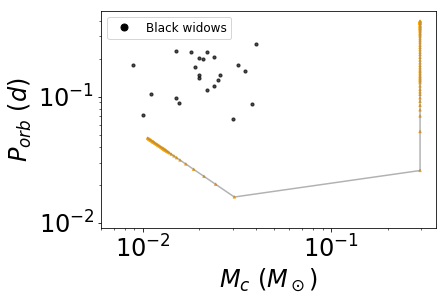

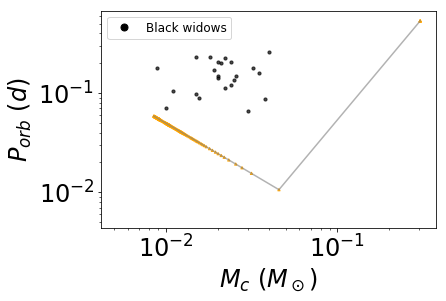

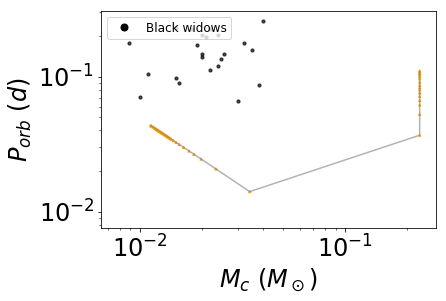

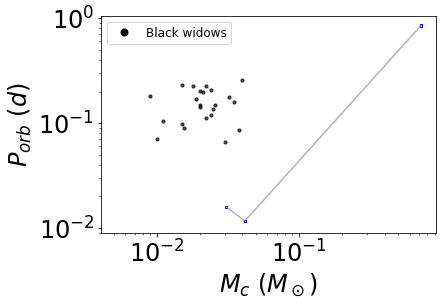

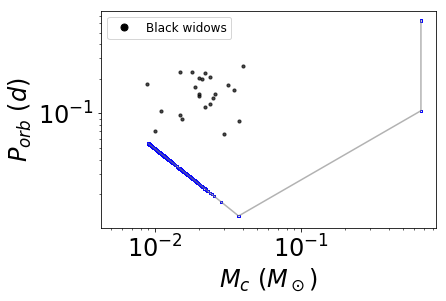

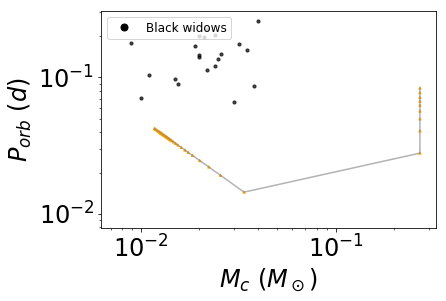

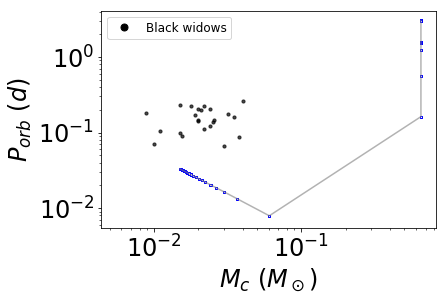

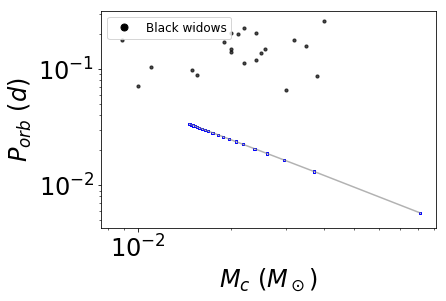

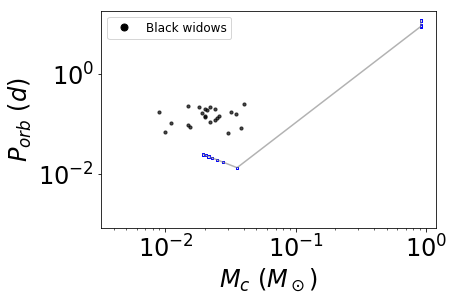

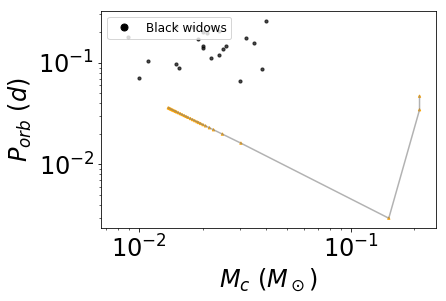

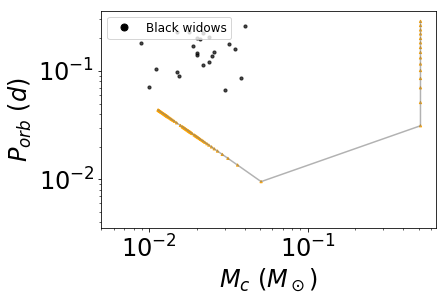

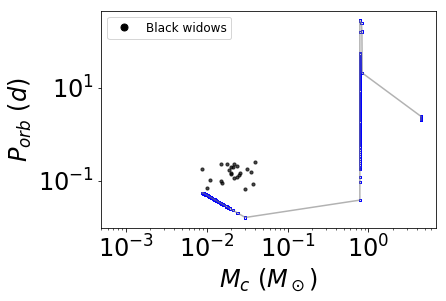

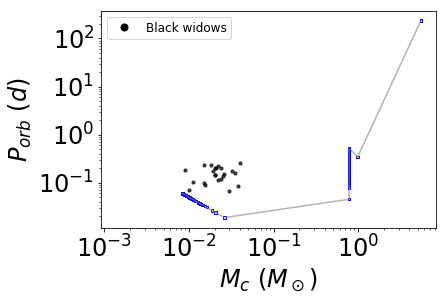

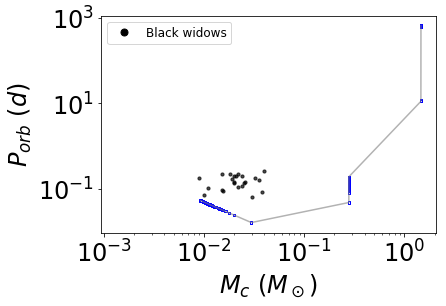

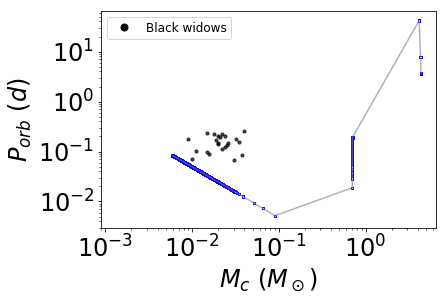

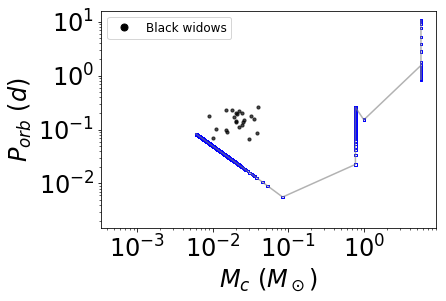

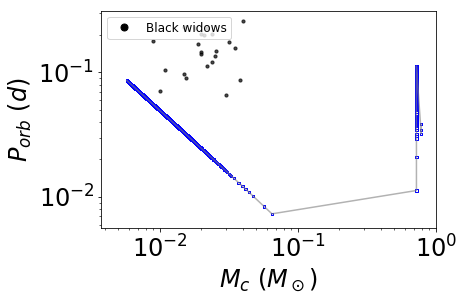

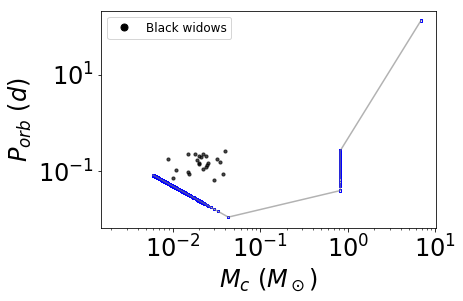

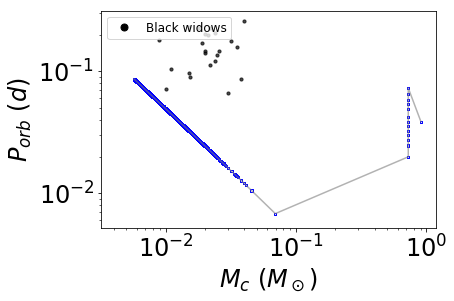

In [19]:
##History of NONAIC straightline ststems
paths = np.genfromtxt('/projects/b1095/syr904/cmc/cmc-mpi-tidalcapture/rvgrid/standard_models_tcon/path_rvgrid_tcon.dat', dtype=str)
datasl = np.genfromtxt('/projects/b1095/syr904/cmc/cmc-mpi-tidalcapture/rvgrid/standard_models_tcon/straightline_nonaic_systems.dat')
model_sl = datasl[:,0]; id0_sl = datasl[:,4]; id1_sl = datasl[:,5]; k1 = datasl[:,6]; tcflag = datasl[:,7]

###Get observed data
P, Pdot, Binflag, Namespin, Period, Ecc, Mc, Names, Pall, Bfall, Nameall = pc.readdata_freire()
#print(len(Pall), len(Bfall))
#print(Ecc)
datarb=np.genfromtxt('/projects/b1095/syr904/projects/PULSAR/data_observed/GCredback.dat', dtype=str)
databw=np.genfromtxt('/projects/b1095/syr904/projects/PULSAR/data_observed/GCblackwidow.dat', dtype=str)
namerb=datarb[:,0]; namebw=databw[:,0]


###Plotting
rdot=mlines.Line2D([], [],  linestyle = 'None', color='r', marker='o',
                  markersize=7, label='Redbacks')
kdot=mlines.Line2D([], [],  linestyle = 'None', color='k', marker='o',
                  markersize=7, label='Black widows')
bdot=mlines.Line2D([], [],  linestyle = 'None', color='b', marker='o',
                  markersize=7, label='Others')
gtri=mlines.Line2D([], [],  linestyle = 'None', color='g', marker='^',
                  markersize=7, label='Others')
star=mlines.Line2D([], [],  linestyle = 'None', color='g', marker='*',
                  markersize=7, label='Tidal capture binaries')
square=mlines.Line2D([], [],  linestyle = 'None', color='g', marker='s',
                  markersize=7, label='Giant collision binaries')
tri=mlines.Line2D([], [],  linestyle = 'None', color='g', marker='^',
                  markersize=7, label='Others')



for kk in range(len(id0_sl)):
    Pb_gc = []; Pb_nongc = []
    M1_gc = []; M1_nongc = []
    
    modelpath = paths[int(model_sl[kk])]
    Age, B0, B1, P0, P1, M0, M1, K0, K1, A, Ecc, ID0, ID1, Radrol0, Radrol1 = nh.get_history_inpsrfile(int(id0_sl[kk]), modelpath)
    
    for xx in range(len(K1)):
        if K1[xx]!=-100 and tcflag[kk]!=81. and int(ID1[xx])==int(id1_sl[kk]):
            PB = uc.au_to_period(A[xx], M0[xx], M1[xx])
            Pb_nongc.append(PB); M1_nongc.append(M1[xx])
        if K1[xx]!=-100 and tcflag[kk]==81. and int(ID1[xx])==int(id1_sl[kk]):
            PB = uc.au_to_period(A[xx], M0[xx], M1[xx])
            Pb_gc.append(PB); M1_gc.append(M1[xx])
            
    print(id0_sl[kk])
    fig, axs = plt.subplots(figsize = (6, 4))
    axs.scatter(M1_gc, Pb_gc, marker = '^', facecolor = 'none', s = 5, color = 'orange')
    axs.plot(M1_gc, Pb_gc, color = 'gray', alpha = 0.6)
    axs.scatter(M1_nongc, Pb_nongc, marker = 's', facecolor = 'none', s = 5, color = 'blue')
    axs.plot(M1_nongc, Pb_nongc, color = 'gray', alpha = 0.6)
                                            
    ##Observed data
    for i in range(len(Mc)):
        if Mc[i][0] != '>':
            if Names[i] in namebw:
                axs.scatter(float(Mc[i]), float(Period[i]), color='k', s = 10, alpha=0.7, zorder=2)
    
    axs.set_yscale('log')
    axs.set_xscale('log')
    #axs.set_ylim(0.01, 3000)
    #axs.set_xlim(0.001, 20)
    axs.set_xlabel(r'$M_c\ (M_\odot)$')
    axs.set_ylabel(r'$P_{orb}\ (d)$')
    axs.legend(handles=[kdot], loc='upper left', prop={'size': 12}, numpoints=1, frameon=True)

223


/software/anaconda3.6/lib/python3.6/site-packages/matplotlib/pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


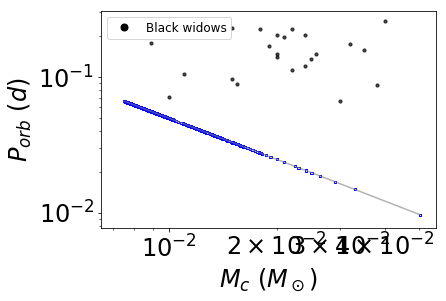

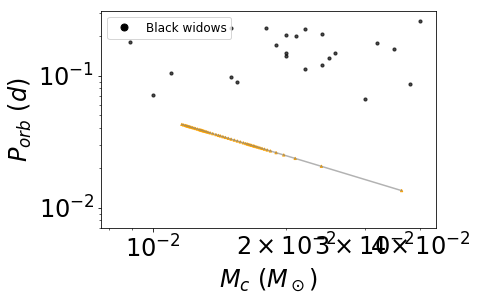

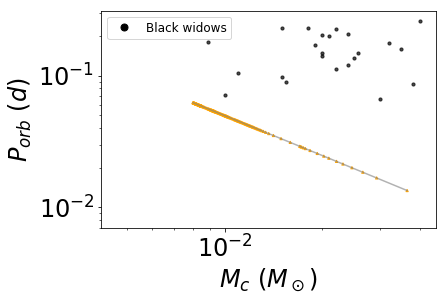

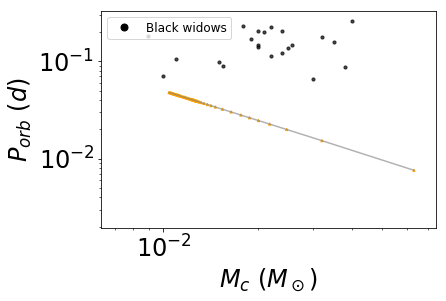

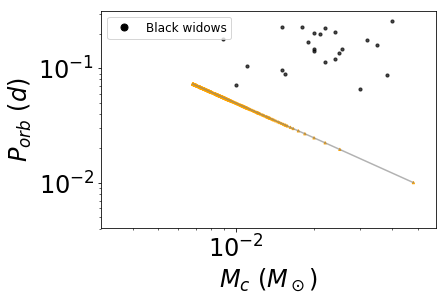

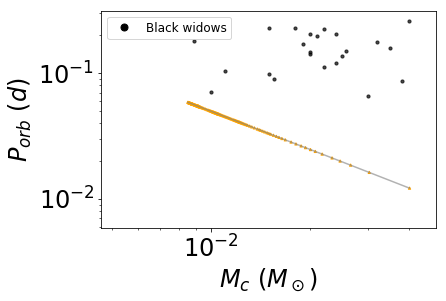

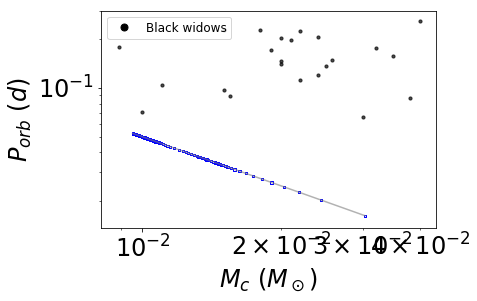

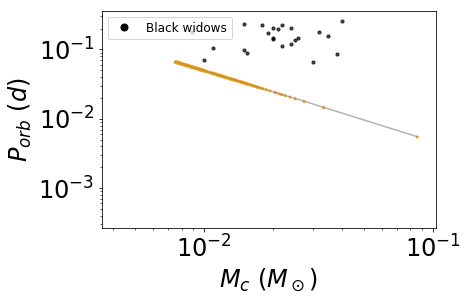

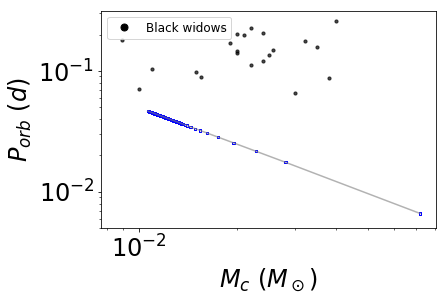

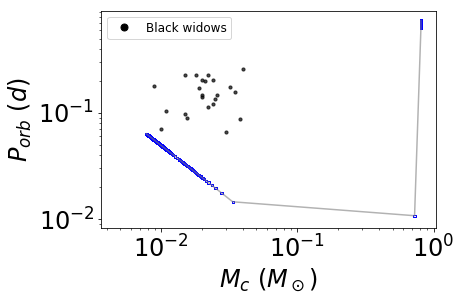

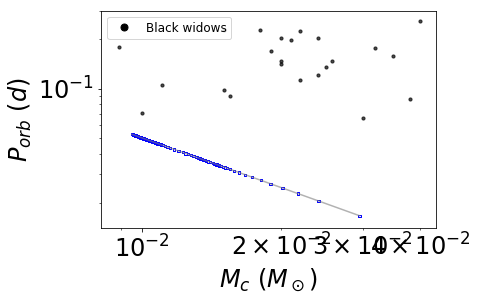

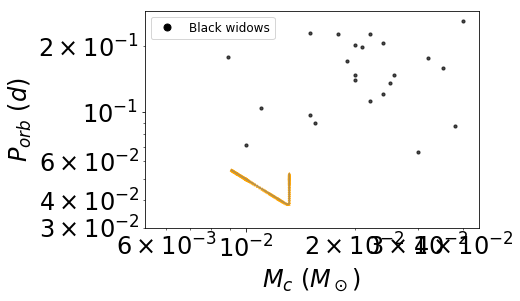

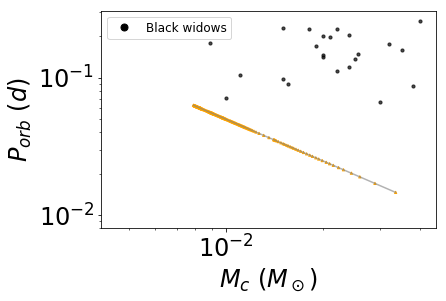

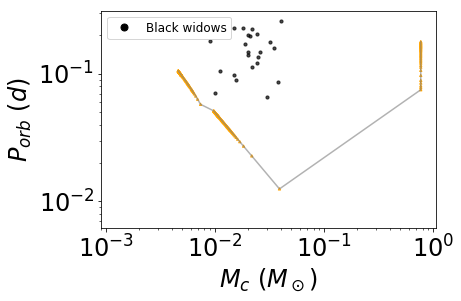

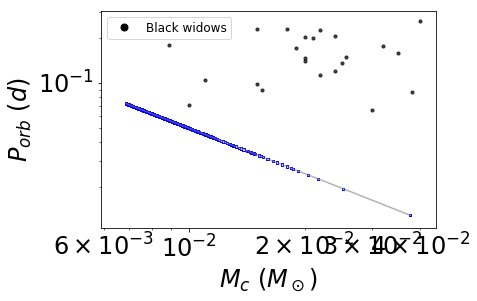

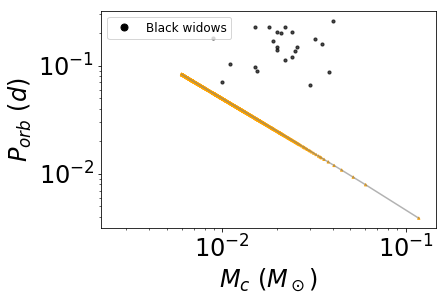

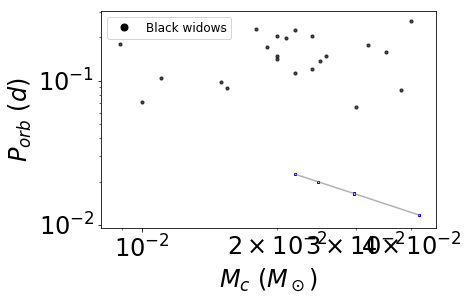

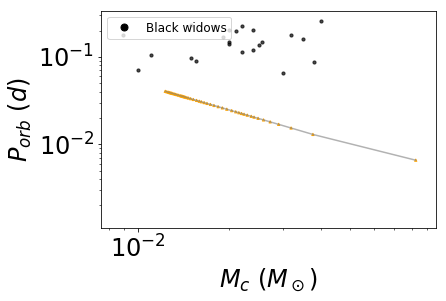

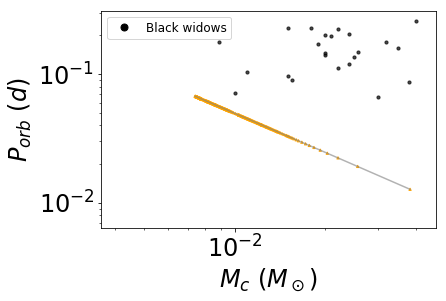

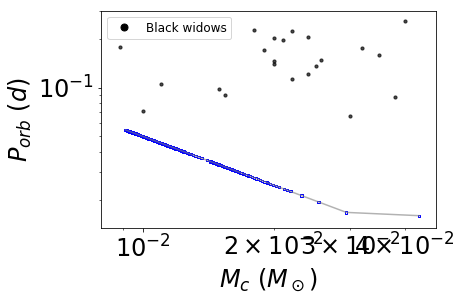

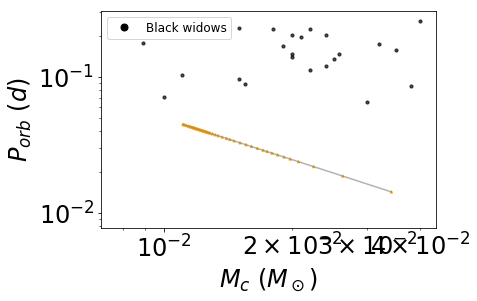

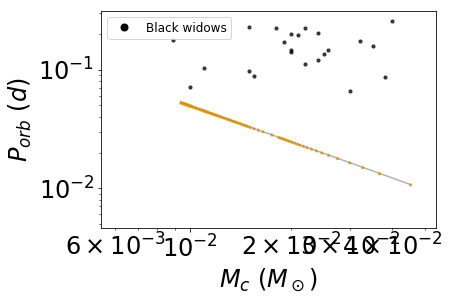

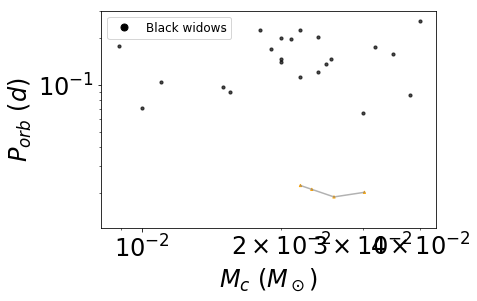

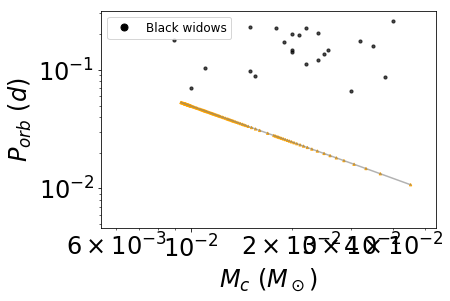

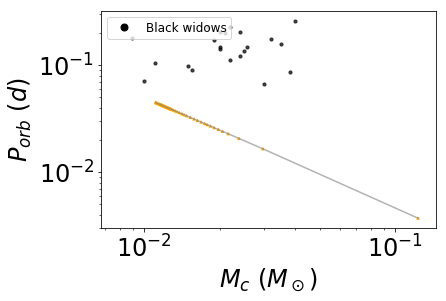

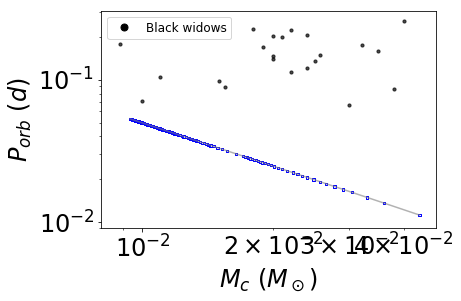

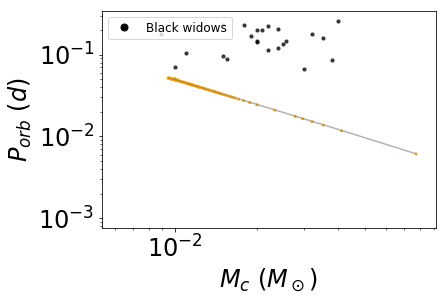

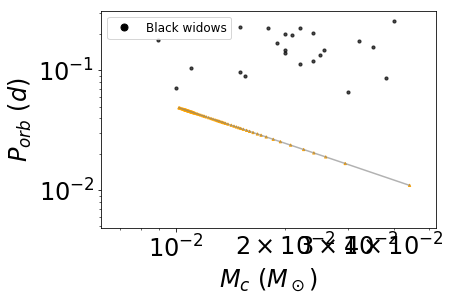

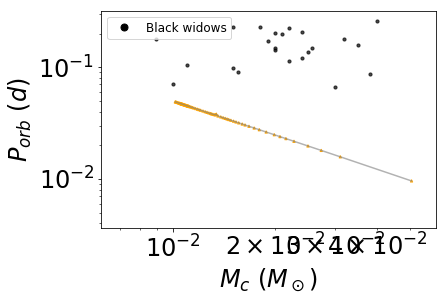

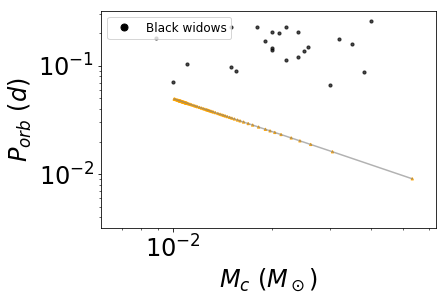

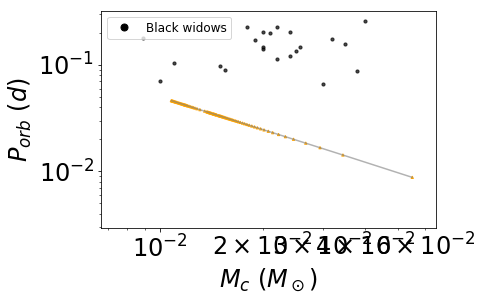

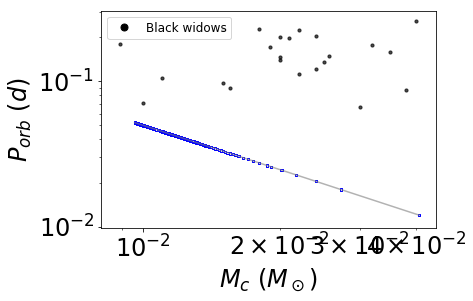

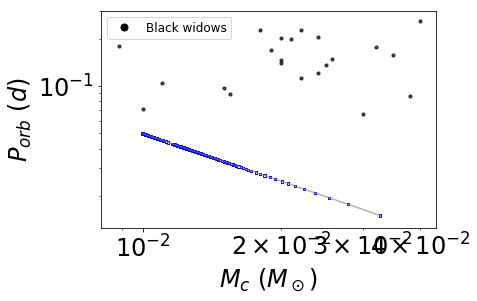

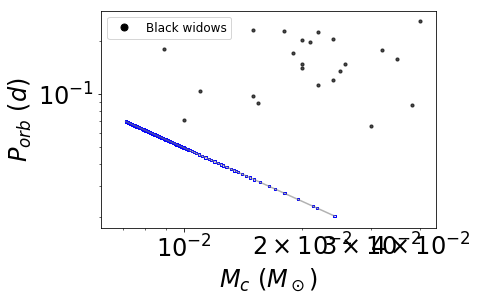

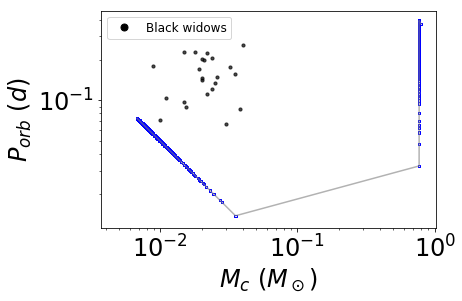

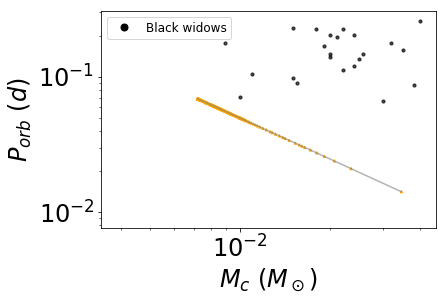

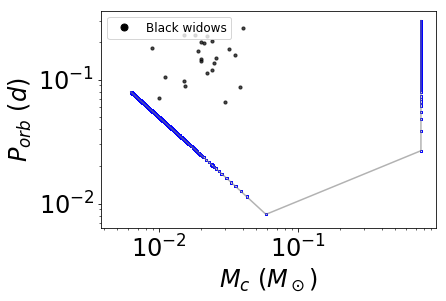

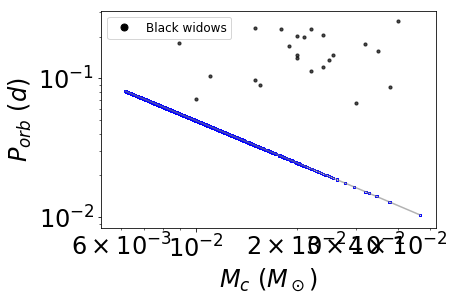

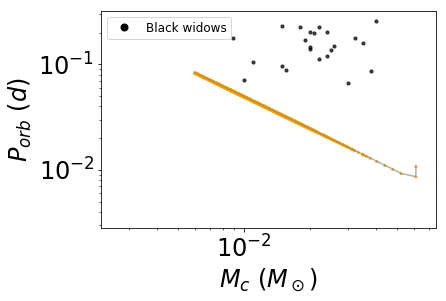

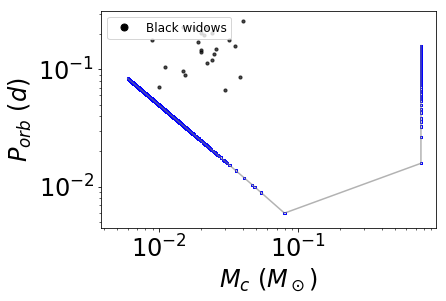

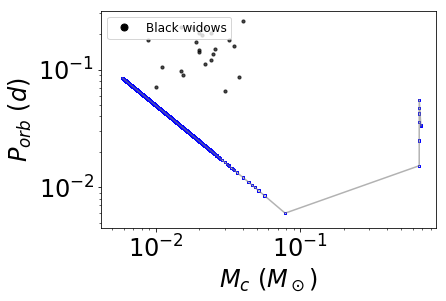

In [11]:
##History of AIC straightline ststems
paths = np.genfromtxt('/projects/b1095/syr904/cmc/cmc-mpi-tidalcapture/rvgrid/standard_models_tcon/path_rvgrid_tcon.dat', dtype=str)
datasl = np.genfromtxt('/projects/b1095/syr904/cmc/cmc-mpi-tidalcapture/rvgrid/standard_models_tcon/straightline_aic_systems.dat')
model_sl = datasl[:,0]; id0_sl = datasl[:,4]; id1_sl = datasl[:,5]; k1 = datasl[:,6]; tcflag = datasl[:,7]

###Get observed data
P, Pdot, Binflag, Namespin, Period, Ecc, Mc, Names, Pall, Bfall, Nameall = pc.readdata_freire()
#print(len(Pall), len(Bfall))
#print(Ecc)
datarb=np.genfromtxt('/projects/b1095/syr904/projects/PULSAR/data_observed/GCredback.dat', dtype=str)
databw=np.genfromtxt('/projects/b1095/syr904/projects/PULSAR/data_observed/GCblackwidow.dat', dtype=str)
namerb=datarb[:,0]; namebw=databw[:,0]


###Plotting
rdot=mlines.Line2D([], [],  linestyle = 'None', color='r', marker='o',
                  markersize=7, label='Redbacks')
kdot=mlines.Line2D([], [],  linestyle = 'None', color='k', marker='o',
                  markersize=7, label='Black widows')
bdot=mlines.Line2D([], [],  linestyle = 'None', color='b', marker='o',
                  markersize=7, label='Others')
gtri=mlines.Line2D([], [],  linestyle = 'None', color='g', marker='^',
                  markersize=7, label='Others')
star=mlines.Line2D([], [],  linestyle = 'None', color='g', marker='*',
                  markersize=7, label='Tidal capture binaries')
square=mlines.Line2D([], [],  linestyle = 'None', color='g', marker='s',
                  markersize=7, label='Giant collision binaries')
tri=mlines.Line2D([], [],  linestyle = 'None', color='g', marker='^',
                  markersize=7, label='Others')



for kk in range(len(id0_sl)):
    Pb_gc = []; Pb_nongc = []
    M1_gc = []; M1_nongc = []
    
    modelpath = paths[int(model_sl[kk])]
    Age, B0, B1, P0, P1, M0, M1, K0, K1, A, Ecc, ID0, ID1, Radrol0, Radrol1 = nh.get_history_inpsrfile(int(id0_sl[kk]), modelpath)    
    for xx in range(len(K1)):
        if K1[xx]!=-100 and tcflag[kk]!=81.:
            PB = uc.au_to_period(A[xx], M0[xx], M1[xx])
            Pb_nongc.append(PB); M1_nongc.append(M1[xx])
        if K1[xx]!=-100 and tcflag[kk]==81.:
            PB = uc.au_to_period(A[xx], M0[xx], M1[xx])
            Pb_gc.append(PB); M1_gc.append(M1[xx])
            
    fig, axs = plt.subplots(figsize = (6, 4))
    axs.scatter(M1_gc, Pb_gc, marker = '^', facecolor = 'none', s = 5, color = 'orange')
    axs.plot(M1_gc, Pb_gc, color = 'gray', alpha = 0.6)
    axs.scatter(M1_nongc, Pb_nongc, marker = 's', facecolor = 'none', s = 5, color = 'blue')
    axs.plot(M1_nongc, Pb_nongc, color = 'gray', alpha = 0.6)
                                            
    ##Observed data
    for i in range(len(Mc)):
        if Mc[i][0] != '>':
            if Names[i] in namebw:
                axs.scatter(float(Mc[i]), float(Period[i]), color='k', s = 10, alpha=0.7, zorder=2)
    
    axs.set_yscale('log')
    axs.set_xscale('log')
    #axs.set_ylim(0.01, 3000)
    #axs.set_xlim(0.001, 20)
    axs.set_xlabel(r'$M_c\ (M_\odot)$')
    axs.set_ylabel(r'$P_{orb}\ (d)$')
    axs.legend(handles=[kdot], loc='upper left', prop={'size': 12}, numpoints=1, frameon=True)

223
223 223
['0.00031', '0.07056', '<0.0004', '<0.00004', '<0.00016', '0.0', '0.00008', '0.0', '0.00039', '0.00040', '0.00014', '0.0', '0.0', '0.0000005', '0.000003', '0', '0', '0.88798', '<0.01', '0.0', '0.0', '0.0753', '0.13784', '0.0', '0.0', '0.0', '0.0', '0.0', '0.02532', '0.000002', '0.0005730', '0.00012', '0.0', '0.000004', '<0.00007', '<0.00006', '0.00045', '0.0', '0.0', '0.000907', '0', '<0.005', '0', '0', '0', '<0.0001', '0.0', '0.02', '0.428', '0.350', '0', '0.000045', '0', '0', '0.722', '0.60498', '0', '0.015', '0.3024', '0.00002', '0.7608', '0', '0', '0.4400', '0.20475', '0.0065856', '0.57016', '0.00', '0.0531', '0.71243', '0.00404', '0.038', '0.21206', '0.0', '0.74703', '0', '0.380466', '0.84704372', '0.776334', '0.0', '0.0', '0.0', '0.0', '0.001524', '0.0', '0', '0.000021', '0.0', '0', '0.0', '<0.00001', '<0.00013', '0.0', '0.68139', '<0.00012', '>0.52']
2185250
0.015133 0.03234923166531305 0892412 127148.0 11.0 4.0
0.009937 0.050054917629428375 01296876 1301924.0 10.0 4

Text(0.5,0,'$eccentricity$')

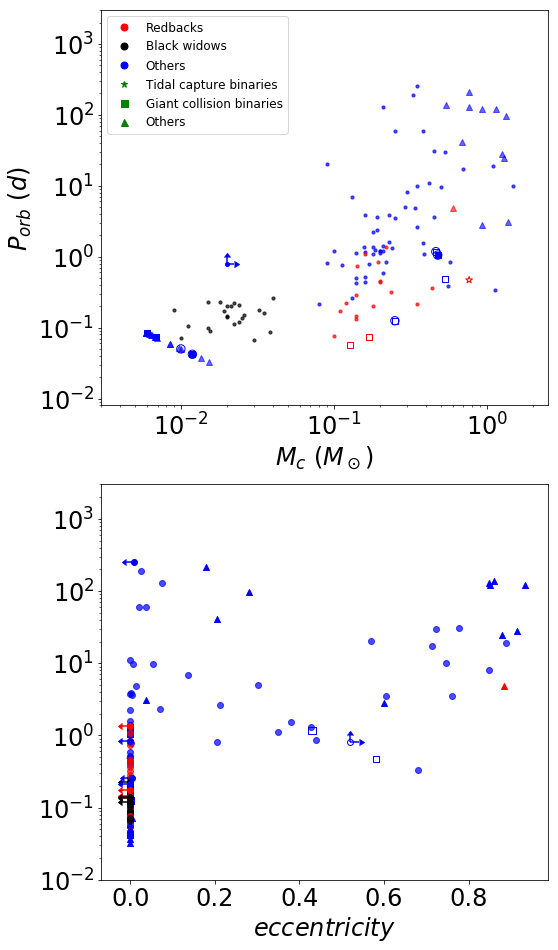

In [6]:
##Compare model pulsars Mc_Period with observed ones for different models

###Get model data
##Pulsars at the last timestep
datamsp=np.genfromtxt('/projects/b1095/syr904/cmc/cmc-mpi-tidalcapture/rvgrid/standard_models_tcon/test18_mpi1/msp_last_fb20.dat')
datapsr=np.genfromtxt('/projects/b1095/syr904/cmc/cmc-mpi-tidalcapture/rvgrid/standard_models_tcon/test18_mpi1/normalpsr_last_fb20.dat')
m0_msp=datamsp[:,10]; m1_msp=datamsp[:,11]; sma_msp=datamsp[:,16]; ecc_msp=datamsp[:,17]
k0_msp=datamsp[:,14]; k1_msp=datamsp[:,15]; B_msp=datamsp[:,4]; P_msp=datamsp[:,5]
id0_msp=datamsp[:,12]; id1_msp=datamsp[:,13]; model_msp=datamsp[:,0]

m0_psr=datapsr[:,10]; m1_psr=datapsr[:,11]; sma_psr=datapsr[:,16]; ecc_psr=datapsr[:,17]
k0_psr=datapsr[:,14]; k1_psr=datapsr[:,15]; B_psr=datapsr[:,4]; P_psr=datapsr[:,5]
id0_psr=datapsr[:,12]; id1_psr=datapsr[:,13]; model_psr=datapsr[:,0]

Pdot_psr=Kconst*yearsc*B_psr*B_psr/P_psr
Pdot_msp=Kconst*yearsc*B_msp*B_msp/P_msp
Pdot_msp=Pdot_msp *10**19*1000; Pdot_psr=Pdot_psr*10**19*1000
P_msp = P_msp*1000; P_psr = P_psr*1000


##Create distinc ids for different models
id0_new_psr = []
for x in range(len(model_psr)):
    id0_new_psr.append(str(int(model_psr[x]))+str(int(id0_psr[x])))
    
id0_new_msp = []
for y in range(len(model_msp)):
    id0_new_msp.append(str(int(model_msp[y]))+str(int(id0_msp[y])))



##NSWD and NSMS binaries that are not MSPs or young pulsars at the last timestep
data13ms=np.genfromtxt('/projects/b1095/syr904/cmc/cmc-mpi-tidalcapture/rvgrid/standard_models_tcon/test18_mpi1/NSMS_last_fb20.dat')
data13wd=np.genfromtxt('/projects/b1095/syr904/cmc/cmc-mpi-tidalcapture/rvgrid/standard_models_tcon/test18_mpi1/NSWD_last_fb20.dat')

id0_13ms=data13ms[:,2]; id1_13ms=data13ms[:,3]; m0_13ms=data13ms[:,4]; m1_13ms=data13ms[:,5]
sma_13ms=data13ms[:,8]; ecc_13ms=data13ms[:,9]; tcflag_13ms=data13ms[:,14]; SN_13ms=data13ms[:,15]
model_13ms=data13ms[:,0]
k0_13ms=data13ms[:,6]; k1_13ms=data13ms[:,7]

id0_13wd=data13wd[:,2]; id1_13wd=data13wd[:,3]; m0_13wd=data13wd[:,4]; m1_13wd=data13wd[:,5]
sma_13wd=data13wd[:,8]; ecc_13wd=data13wd[:,9]; tcflag_13wd=data13wd[:,14]; SN_13wd=data13wd[:,15]
model_13wd=data13wd[:,0]
k0_13wd=data13wd[:,6]; k1_13wd=data13wd[:,7]

##Create distinct ids for different models
id0_new_13ms = []
for x in range(len(model_13ms)):
    id0_new_13ms.append(str(int(model_13ms[x]))+str(int(id0_13ms[x])))
    
id0_new_13wd = []
for y in range(len(model_13wd)):
    id0_new_13wd.append(str(int(model_13wd[y]))+str(int(id0_13wd[y])))

                                        
###Get observed data
P, Pdot, Binflag, Namespin, Period, Ecc, Mc, Names, Pall, Bfall, Nameall = pc.readdata_freire()
print(len(Pall), len(Bfall))
print(Ecc)
datarb=np.genfromtxt('/projects/b1095/syr904/projects/PULSAR/data_observed/GCredback.dat', dtype=str)
databw=np.genfromtxt('/projects/b1095/syr904/projects/PULSAR/data_observed/GCblackwidow.dat', dtype=str)
namerb=datarb[:,0]; namebw=databw[:,0]


###Plotting
plt.rcParams['figure.figsize'] = [8,16]
rdot=mlines.Line2D([], [],  linestyle = 'None', color='r', marker='o',
                  markersize=7, label='Redbacks')
kdot=mlines.Line2D([], [],  linestyle = 'None', color='k', marker='o',
                  markersize=7, label='Black widows')
bdot=mlines.Line2D([], [],  linestyle = 'None', color='b', marker='o',
                  markersize=7, label='Others')
gtri=mlines.Line2D([], [],  linestyle = 'None', color='g', marker='^',
                  markersize=7, label='Others')
star=mlines.Line2D([], [],  linestyle = 'None', color='g', marker='*',
                  markersize=7, label='Tidal capture binaries')
square=mlines.Line2D([], [],  linestyle = 'None', color='g', marker='s',
                  markersize=7, label='Giant collision binaries')
tri=mlines.Line2D([], [],  linestyle = 'None', color='g', marker='^',
                  markersize=7, label='Others')


fig, axs = plt.subplots(nrows=2, sharey=False)
fig.subplots_adjust(wspace=0.05)

##Model data
for ii in range(len(id0_new_13ms)):
    pb_13ms = uc.au_to_period(sma_13ms[ii], m0_13ms[ii], m1_13ms[ii])
    if SN_13ms[ii]==4: continue
    if m1_13ms[ii]<0.04:
        print(m1_13ms[ii], pb_13ms, id0_new_13ms[ii], id1_13ms[ii], k1_13ms[ii], tcflag_13ms[ii])
    if tcflag_13ms[ii]==91:
        if id0_new_13ms[ii] in id0_new_msp:# or id0_new_13ms[ii] in id0_new_psr:
            axs[0].scatter(m1_13ms[ii], pb_13ms, color='red', marker = '*', s=50, lw = 1)
            #axs[0].scatter(m1_13ms[ii], pb_13ms, color='red', marker = 'o', 
            #               lw = 1, facecolor = 'none')
            axs[1].scatter(ecc_13ms[ii], pb_13ms,  color='red', marker = '*', s=50, lw = 1)
        else:
            axs[0].scatter(m1_13ms[ii], pb_13ms, color='red', marker = '*', s=50, 
                           lw = 1, facecolors='none')
            axs[1].scatter(ecc_13ms[ii], pb_13ms,  color='red', marker = '*', s=50, 
                           lw = 1, facecolors='none')
    elif tcflag_13ms[ii]==81:
        if id0_new_13ms[ii] in id0_new_msp:# or id0_new_13ms[ii] in id0_new_psr:
            axs[0].scatter(m1_13ms[ii], pb_13ms, color='red', marker = 's', lw = 1)
            axs[1].scatter(ecc_13ms[ii], pb_13ms,  color='red', marker = 's', lw = 1)
        else:
            axs[0].scatter(m1_13ms[ii], pb_13ms, color='red', marker = 's', 
                           lw = 1, facecolors='none')
            axs[1].scatter(ecc_13ms[ii], pb_13ms,  color='red', marker = 's', 
                           lw = 1, facecolors='none')
        
    else:
        if id0_new_13ms[ii] in id0_new_msp:# or id0_new_13ms[ii] in id0_new_psr:
            print(id0_new_13ms[ii])
            axs[0].scatter(m1_13ms[ii], pb_13ms, color='red', marker = '^', 
                           lw = 1, alpha=0.6)
            axs[1].scatter(ecc_13ms[ii], pb_13ms,  color='red', marker = '^', lw = 1)
        #else:
        #    axs[0].scatter(m1_13ms[ii], pb_13ms, color='red', marker = '^', lw = 1, facecolors='none')
        #    axs[1].scatter(ecc_13ms[ii], pb_13ms,  color='red', marker = '^', lw = 1, facecolors='none')

            
for hh in range(len(id0_new_13wd)):
    pb_13wd = uc.au_to_period(sma_13wd[hh], m0_13wd[hh], m1_13wd[hh])
    if SN_13wd[hh]==4: continue
    if m1_13wd[hh]<0.04:
        print(m1_13wd[hh], pb_13wd, id0_new_13wd[hh], id1_13wd[hh], k1_13wd[hh], tcflag_13wd[hh])
    if ecc_13wd[hh]>1:
        print(id0_13wd[hh], id1_13wd[hh])
    if tcflag_13wd[hh]==91:
        if k1_13wd[hh]==10:
            if id0_new_13wd[hh] in id0_new_msp:# or id0_new_13wd[hh] in id0_new_psr:
                axs[0].scatter(m1_13wd[hh], pb_13wd, color='b', marker = '*', s=50, lw = 1)
                axs[0].scatter(m1_13wd[hh], pb_13wd, color='b', marker = 'o', 
                               lw = 1, facecolor = 'none', s=70)
                axs[1].scatter(ecc_13wd[hh], pb_13wd,  color='b', marker = '*', s=50, lw = 1) 
            else:
                axs[0].scatter(m1_13wd[hh], pb_13wd, color='b', marker = '*', s=50, 
                               lw = 1, facecolors='none')
                axs[0].scatter(m1_13wd[hh], pb_13wd, color='b', marker = 'o', 
                               lw = 1, facecolor = 'none', s=70)
                axs[1].scatter(ecc_13wd[hh], pb_13wd,  color='b', marker = '*', s=50, 
                               lw = 1, facecolors='none') 
    
        elif k1_13wd[hh]>10:
            if id0_new_13wd[hh] in id0_new_msp:# or id0_new_13wd[hh] in id0_new_psr:
                axs[0].scatter(m1_13wd[hh], pb_13wd, color='b', marker = '*', s=50, lw = 1)
                axs[1].scatter(ecc_13wd[hh], pb_13wd,  color='b', marker = '*', s=50, lw = 1) 
            else:
                axs[0].scatter(m1_13wd[hh], pb_13wd, color='b', marker = '*', s=50,
                               lw = 1, facecolors='none')
                axs[1].scatter(ecc_13wd[hh], pb_13wd,  color='b', marker = '*', s=50,
                               lw = 1, facecolors='none') 
    
    elif tcflag_13wd[hh]==81:
        if k1_13wd[hh]==10:
            if id0_new_13wd[hh] in id0_new_msp:# or id0_new_13wd[hh] in id0_new_psr:
                axs[0].scatter(m1_13wd[hh], pb_13wd, color='b', marker = 's', lw = 1)
                axs[0].scatter(m1_13wd[hh], pb_13wd, color='b', marker = 'o', 
                               lw = 1, facecolor = 'none', s=70)
                axs[1].scatter(ecc_13wd[hh], pb_13wd,  color='b', marker = 's', lw = 1) 
            else:
                axs[0].scatter(m1_13wd[hh], pb_13wd, color='b', marker = 's', 
                               lw = 1, facecolors='none')
                axs[0].scatter(m1_13wd[hh], pb_13wd, color='b', marker = 'o', 
                               lw = 1, facecolor = 'none', s=70)
                axs[1].scatter(ecc_13wd[hh], pb_13wd,  color='b', marker = 's', s=50, 
                               lw = 1, facecolors='none') 
    
        elif k1_13wd[hh]>10:
            if id0_new_13wd[hh] in id0_new_msp:# or id0_new_13wd[hh] in id0_new_psr:
                axs[0].scatter(m1_13wd[hh], pb_13wd, color='b', marker = 's', lw = 1)
                axs[1].scatter(ecc_13wd[hh], pb_13wd,  color='b', marker = 's', lw = 1) 
            else:
                axs[0].scatter(m1_13wd[hh], pb_13wd, color='b', marker = 's', 
                               lw = 1, facecolors='none')
                axs[1].scatter(ecc_13wd[hh], pb_13wd,  color='b', marker = 's', 
                               lw = 1, facecolors='none') 
    else: 
        if k1_13wd[hh]==10:
            if id0_new_13wd[hh] in id0_new_msp:# or id0_new_13wd[hh] in id0_new_psr:
                axs[0].scatter(m1_13wd[hh], pb_13wd, color='b', marker = '^', 
                               lw = 1, alpha=0.6)
                axs[0].scatter(m1_13wd[hh], pb_13wd, color='b', marker = 'o', 
                               lw = 1, facecolor = 'none', s=70)
                axs[1].scatter(ecc_13wd[hh], pb_13wd,  color='b', marker = '^', lw = 1)  
        elif k1_13wd[hh]>10:
            if id0_new_13wd[hh] in id0_new_msp:# or id0_new_13wd[hh] in id0_new_psr:
                axs[0].scatter(m1_13wd[hh], pb_13wd, color='b', marker = '^', 
                               lw = 1, alpha=0.6)
                axs[1].scatter(ecc_13wd[hh], pb_13wd,  color='b', marker = '^', lw = 1)  

            
##Observed data
for i in range(len(Mc)):
    if Mc[i][0] != '>':
        if Names[i] in namerb:
            axs[0].scatter(float(Mc[i]), float(Period[i]), color='red', s = 10, 
                           alpha=0.7, zorder=2)
            if Ecc[i][0]!='<' and Ecc[i][0]!='-':
                axs[1].scatter(float(Ecc[i]), float(Period[i]),  color='red', alpha=0.7, zorder=2)
            elif Ecc[i][0]!='-':
                axs[1].errorbar(float(Ecc[i].split('<')[1]), float(Period[i]), xerr=0.02, 
                                xuplims=True,  marker='o', color='red', linestyle='none')
                
            
        elif Names[i] in namebw:
            axs[0].scatter(float(Mc[i]), float(Period[i]), color='k', s = 10, 
                           alpha=0.7, zorder=2)
            if Ecc[i][0]!='<':
                axs[1].scatter(float(Ecc[i]), float(Period[i]), color='k', alpha=0.7, zorder=2)
            else:
                axs[1].errorbar(float(Ecc[i].split('<')[1]), float(Period[i]), xerr=0.02, 
                                xuplims=True,  marker='o', color='k', linestyle='none')
                
            
        else:
            axs[0].scatter(float(Mc[i]), float(Period[i]), color='b', s = 10, 
                           alpha=0.7, zorder=1)
            if Ecc[i][0]!='<':
                axs[1].scatter(float(Ecc[i]), float(Period[i]), color='b', alpha=0.7, zorder=1)
            else:
                #print(Ecc[i])
                axs[1].errorbar(float(Ecc[i].split('<')[1]), float(Period[i]), xerr=0.02, 
                                xuplims=True,  marker='o', color='b', linestyle='none')
                
    
    else:
        axs[0].errorbar(float(Mc[i].split('>')[1]), float(Period[i].split('>')[1]), xerr=0.002, yerr=0.2, lolims=True, 
                        xlolims=True, marker='o', color='b', markersize = 4, linestyle='none')
        axs[1].errorbar(float(Ecc[i].split('>')[1]), float(Period[i].split('>')[1]), xerr=0.02, yerr=0.2, lolims=True, 
                        xlolims=True, marker='o', markerfacecolor='none', color='b', linestyle='none')
        
        
            
        
axs[0].set_yscale('log')
axs[0].set_xscale('log')
axs[0].set_ylim(0.008, 3000)
axs[0].set_xlim(0.003, 2.5)
axs[0].set_xlabel(r'$M_c\ (M_\odot)$')
axs[0].set_ylabel(r'$P_{orb}\ (d)$')
axs[0].legend(handles=[rdot, kdot, bdot, star, square, tri], loc='upper left', prop={'size': 12}, numpoints=1, frameon=True)

axs[1].set_yscale('log')
#axs[1].set_xscale('symlog')
axs[1].set_ylim(0.01, 3000)
#axs[1].set_xlim(-0.1, 1)
axs[1].set_xlabel(r'$eccentricity$')
#axs[1].set_ylabel(r'$P_{orb}\ (d)$')

In [26]:
##
##NSWD and NSMS binaries that are not MSPs or young pulsars at the last timestep
data13ms=np.genfromtxt('/projects/b1095/syr904/cmc/cmc-mpi-tidalcapture/rvgrid/bhcapture_off/NSMS_rvgrid_last.dat')
data13wd=np.genfromtxt('/projects/b1095/syr904/cmc/cmc-mpi-tidalcapture/rvgrid/bhcapture_off/NSWD_rvgrid_last.dat')

id0_13ms=data13ms[:,2]; id1_13ms=data13ms[:,3]; m0_13ms=data13ms[:,4]; m1_13ms=data13ms[:,5]
sma_13ms=data13ms[:,8]; ecc_13ms=data13ms[:,9]; tcflag_13ms=data13ms[:,14]
model_13ms=data13ms[:,0]

id0_13wd=data13wd[:,2]; id1_13wd=data13wd[:,3]; m0_13wd=data13wd[:,4]; m1_13wd=data13wd[:,5]
sma_13wd=data13wd[:,8]; ecc_13wd=data13wd[:,9]; tcflag_13wd=data13wd[:,14]
model_13wd=data13wd[:,0]


n_tcwd = 0
for hh in range(len(id0_13wd)):
    if tcflag_13wd[hh]==1:
        n_tcwd+=1
        mn = str(int(model_13wd[hh]))
        t_conv = dyn.conv('t', paths[int(mn)]+'initial.conv.sh')
        pb_13wd = uc.au_to_period(sma_13wd[hh], m0_13wd[hh], m1_13wd[hh])
        for i in range(len(prop_init[mn]['id0'])):
            if (prop_init[mn]['id0'][i]==id0_13wd[hh] and prop_init[mn]['id1'][i]==id1_13wd[hh]) or \
                prop_init[mn]['id1'][i]==id0_13wd[hh] and prop_init[mn]['id0'][i]==id1_13wd[hh]:
                pb_tc = uc.au_to_period(prop_finl[mn]['sma'][i], prop_finl[mn]['m0'][i], prop_finl[mn]['m1'][i])
                print(mn, prop_init[mn]['time'][i]*t_conv, 
                      int(id0_13wd[hh]), int(id1_13wd[hh]),
                      prop_init[mn]['k0'][i], prop_init[mn]['k1'][i], 
                      prop_finl[mn]['k0'][i], prop_finl[mn]['k1'][i], prop_finl[mn]['m0'][i], prop_finl[mn]['m1'][i],
                      pb_tc, prop_finl[mn]['ecc'][i])
            
print(n_tcwd)


0 5047.2564021 531272 199447 3 12 10 12 0.249 1.3 0.05931944240066833 0.0
0 3815.0363126700004 192869 838801 4 13 7 13 0.361 1.24 0.0517449749040119 0.0
0 8263.275966000001 341072 296168 12 3 12 10 1.36 0.397 4.87042603154102 0.0
0 12417.0850287 719180 746274 3 13 10 13 0.439 1.26 3.219111435559838 0.8195899371
0 9334.900614600001 651731 296304 3 12 10 12 0.386 1.25 3.611571053745934 0.0
0 9356.1282441 439868 388978 3 12 10 12 0.242 1.22 0.08967974917259615 0.0
0 12774.9222117 804521 351281 12 3 12 10 1.26 0.218 0.06101869501086819 0.0
0 8552.9825667 480451 1581124 12 4 12 7 1.24 0.485 0.09510356428906835 0.0
0 11987.0739054 336797 604500 12 3 12 10 1.28 0.302 0.22952055499846868 0.8446253417
0 9633.5699922 68337 1547052 4 12 7 12 0.524 1.29 0.0885908972718434 0.0
0 8885.5487622 461148 341244 12 3 12 10 1.36 0.255 0.13917046297311192 0.0
0 10421.553077100001 224892 1290361 12 4 12 7 1.19 0.506 0.16787504138016973 0.0
0 69.873943491 209826 529219 1 5 1 8 1.81 1.93 1.3459310794458499 0.0

In [21]:
##Tidap capture rate as a function of rv?
data_num = np.genfromtxt('/projects/b1095/syr904/cmc/cmc-mpi-tidalcapture/rvgrid/num_tidalcapture.dat')

def analytic_ssrate(Mcl, rv, ):
    

SyntaxError: unexpected EOF while parsing (<ipython-input-21-1c050db591c7>, line 5)

0
1
2
3


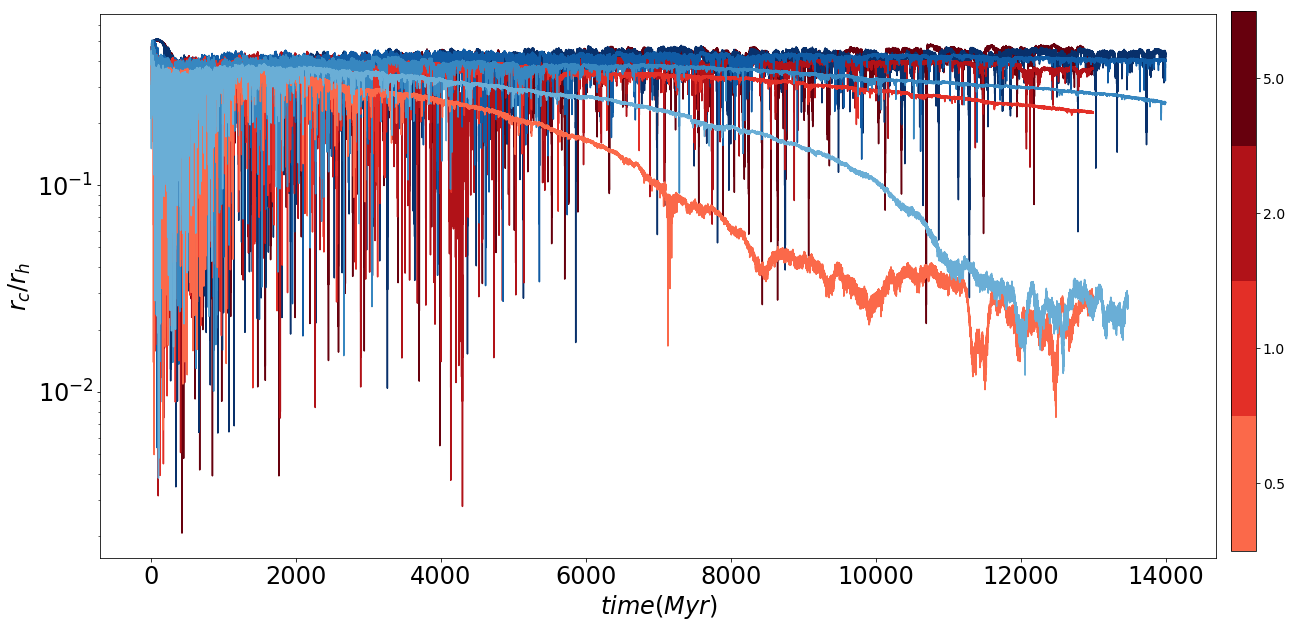

In [7]:
dyn_tc_sel = []; bh_tc_sel = []; ns_tc_sel = []
dyn_comp_sel = []; bh_comp_sel = []; ns_comp_sel = []

path_tc_select = np.genfromtxt('/projects/b1095/syr904/cmc/cmc-mpi-tidalcapture/rvgrid/path_rv_short.dat', dtype=str)
path_comp_select = np.genfromtxt('/projects/b1095/syr904/cmc/cmc-mpi-tidalcapture/rvgrid/path_maingrid_select.dat', dtype=str)

for jj in range(len(path_tc_select)):
    print(jj)
    dyn_tc_sel.append(np.genfromtxt(path_tc_select[jj]+'initial.dyn.dat'))
    dyn_comp_sel.append(np.genfromtxt(path_comp_select[jj]+'initial.dyn.dat'))
    bh_tc_sel.append(np.genfromtxt(path_tc_select[jj]+'initial.bh.dat'))
    bh_comp_sel.append(np.genfromtxt(path_comp_select[jj]+'initial.bh.dat'))
    ns_tc_sel.append(np.genfromtxt(path_tc_select[jj]+'initial.ns.dat'))
    ns_comp_sel.append(np.genfromtxt(path_comp_select[jj]+'initial.ns.dat'))

    
##Compare rc/rh of tidal capture model and standard model
cb = cm.Blues(np.linspace(0.5, 1, 4))
cmapb=matplotlib.colors.ListedColormap([cb[0], cb[1], cb[2], cb[3]])
cr = cm.Reds(np.linspace(0.5, 1, 4))
cmapr=matplotlib.colors.ListedColormap([cr[0], cr[1], cr[2], cr[3]])

fig, ax=plt.subplots(figsize=(20, 10))
for jj in range(len(path_tc_select)-1, -1, -1):
    conv_tc = dyn.conv('t', path_tc_select[jj]+'initial.conv.sh')
    conv_comp = dyn.conv('t', path_comp_select[jj]+'initial.conv.sh')
    
    rc_tc = dyn_tc_sel[jj][:,7]; rh_tc = dyn_tc_sel[jj][:,20]; t_tc = dyn_tc_sel[jj][:,0]
    rc_comp = dyn_comp_sel[jj][:,7]; rh_comp = dyn_comp_sel[jj][:,20]; t_comp = dyn_comp_sel[jj][:,0]

    tmyr_tc = conv_tc*np.array(t_tc)
    tmyr_comp = conv_comp*np.array(t_comp)
    r_ratio_tc = np.array(rc_tc)/np.array(rh_tc)
    r_ratio_comp = np.array(rc_comp)/np.array(rh_comp)

    ax.plot(tmyr_tc, r_ratio_tc, color = cr[jj])
    ax.plot(tmyr_comp, r_ratio_comp, color = cb[jj])
    
addColorbar(ax, cmapr, 0, 8, label=None, tick_tuple=([1.,3.,5.,7.],[0.5,1.0,2.0,5.0]))

ax.set_xlabel(r'$time(Myr)$')
ax.set_ylabel(r'$r_c/r_h$')
ax.set_yscale('log')
#ax.set_xscale('log')

#plt.legend(loc='best', fontsize=12)